# The life of an athlete with type 1 diabetes: analysis

In [59]:
# TODO: for one athlete (dark blue) the data looks very weird

Descriptives for the 2019 training season of 14 TNN athletes

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
from copy import copy

from plot import *
from calc import glucose_levels, mmoll_mgdl, mgdl_mmoll, timestamp_to_seconds
from config import DATA_PATH

In [2]:
SAVE_PATH = 'results/'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [3]:
COL = 'Glucose Value (mg/dL)'
SECTIONS = ('wake', 'exercise', 'recovery', 'sleep')

### Read data

**Athlete characteristics**

In [4]:
info = pd.read_csv(DATA_PATH+'agg/info.csv')
info = info.reset_index()
info = info.rename(columns={'index':'RIDER'})
info

RIDER gender  nationality  age  diabetes_duration     weight      bf(%)  \
0       1      M  Switzerland   22                 11  60.500000   9.066667   
1       2      M        Italy   30                 14  71.633333   8.833333   
2       3      M      Ireland   26                  7  66.733333   6.566667   
3       4      M    Australia   19                  7  78.666667   9.433333   
4       5      M  Netherlands   25                  6  69.633333   7.700000   
5       6      M    Australia   20                  9  56.700000   4.950000   
6       7      M        Italy   22                  6  65.333333   8.066667   
7       8      M  New Zealand   20                 17  65.000000  11.900000   
8       9      M       France   23                 10  63.100000   8.533333   
9      10      M           UK   27                 17  75.466667   7.700000   
10     11      M  Netherlands   24                 15  70.700000   8.900000   
11     12      M        Spain   30                  8  64.000000   5.600000   
12     13      M      Hungary   34                  1  60.333333   4.866667   
13     14      M      Finland   27                 17  75.166667   9.333333   
14     15      M       France   25                 15  73.766667   7.200000   
15     16      M   Uzbekistan   22                 13  56.666667   9.466667   
16     17      M       France   22                  4        NaN        NaN   
17     18      M           US   26                  2        NaN        NaN   

    HbA1c         FTP        LTHR       HRmax     VO2max  height  
0     6.7  307.000000  176.333333  192.333333  68.888889   174.0  
1     6.6  326.000000  168.666667  181.666667  66.915285   178.0  
2     6.8  298.000000  171.000000  180.000000  66.666164   171.0  
3     7.8  356.000000  170.333333  187.333333  67.333333   178.0  
4     6.5  341.000000  179.666667  192.666667  72.857143   183.0  
5     6.4  298.500000  173.000000  184.500000  70.781588   169.0  
6     5.9  298.500000  171.500000  180.500000  72.203125   167.0  
7     7.7  292.000000  187.000000  204.000000  64.000000   165.0  
8     7.2  278.666667  182.333333  195.000000  67.522310   173.0  
9     7.3  377.333333  177.000000  194.333333  73.982571   185.0  
10    6.4  317.000000  175.000000  190.000000  65.000000   179.0  
11    6.0  347.000000  158.333333  178.666667  75.937500   178.0  
12    6.3  345.666667  173.000000  182.333333  76.666667   179.0  
13    7.1  348.000000  169.000000  189.500000  66.500000   187.0  
14    6.4  389.000000  185.000000  198.000000  66.000000   179.0  
15    6.6  283.333333  125.610000  200.333333  74.678571   170.0  
16    NaN         NaN         NaN         NaN        NaN   167.0  
17    NaN         NaN         NaN         NaN        NaN   180.0

**Professional**

In [5]:
pro = pd.read_csv(DATA_PATH+'info/pro.csv')
pro = pro.sort_values('RIDER')

Select only people for whom we have *ethics*

In [6]:
pro = pro[pro.ethics == 1]
pro = pro.drop('ethics', axis=1)

# anonymize file
pro = pro.drop('name', axis=1)
pro['RIDER'] = pro['RIDER'].astype(int)
pro = pro.reset_index(drop=True)

pro

RIDER 2014 2015 2016 2017 2018 2019 2020 2021
0       1    -    -    -  DEV  DEV  PRO  PRO  PRO
1       2  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
2       3  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
3       4    -    -    -  DEV  PRO  PRO  PRO  PRO
4       5    -  PRO  PRO  PRO  PRO  PRO  PRO  PRO
5       6    -    -    -  DEV  DEV  PRO  PRO  PRO
6       7    -    -  DEV  PRO  PRO  PRO  PRO  PRO
7       8    -    -    -  DEV  DEV  DEV  PRO  PRO
8       9    -    -    -  PRO  PRO  PRO  PRO  PRO
9      10    -    -  DEV  DEV  PRO  PRO  PRO  PRO
10     11    -  PRO  PRO  PRO    -  DEV  PRO  PRO
11     12  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
12     13    -    -    -    -    -  PRO  PRO  PRO
13     14  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
14     15  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
15     16    -    -    -  DEV  DEV  PRO  PRO  DEV
16     17    -    -    -    -    -    -    -    -
17     18    -    -    -  DEV  DEV  DEV  DEV  PRO

**Season dates**

In [7]:
season = pd.read_csv(DATA_PATH+'calendar/season_dates.csv', index_col=[0,1], header=[0,1])
season = season.reset_index().drop('level_1', axis=1)
season = season.rename(columns={'level_0':'RIDER'})
season

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


RIDER        2015                    2016                    2017  \
               start         end       start         end       start   
0      1         NaN         NaN         NaN         NaN  2016-12-06   
1      2  2014-11-17  2015-10-18  2015-11-24  2016-10-28  2016-11-15   
2      3  2014-11-06  2015-10-18  2015-11-06  2016-10-23  2016-12-06   
3      4         NaN         NaN         NaN         NaN  2016-11-15   
4      5  2014-11-14  2015-11-08  2015-11-27  2016-10-30  2016-11-12   
5      6         NaN         NaN         NaN         NaN  2016-12-12   
6      7         NaN         NaN  2015-10-07  2016-04-16  2016-11-07   
7      8         NaN         NaN         NaN         NaN  2016-12-14   
8      9         NaN         NaN         NaN         NaN  2016-12-06   
9     10         NaN         NaN  2015-11-06  2016-10-17  2016-11-04   
10    11  2014-11-02  2015-11-12  2015-12-01  2016-11-12  2016-12-07   
11    12  2014-11-15  2015-10-29  2015-11-24  2016-10-22  2016-11-07   
12    13         NaN         NaN         NaN         NaN         NaN   
13    14  2014-11-14  2015-10-25  2015-12-02  2016-10-30  2016-11-13   
14    15  2014-11-17  2015-10-18  2015-11-12  2016-10-23  2016-11-14   
15    16         NaN         NaN         NaN         NaN  2016-12-14   
16    17         NaN         NaN         NaN         NaN         NaN   
17    18         NaN         NaN         NaN         NaN  2016-12-13   

                      2018                    2019                    2020  \
           end       start         end       start         end       start   
0   2017-11-05  2017-11-13  2018-10-20  2018-11-05  2019-10-20  2019-11-04   
1   2017-09-11  2017-10-23  2018-10-02  2018-10-23  2019-10-16  2019-11-04   
2   2017-10-05  2017-11-13  2018-10-31  2018-11-19  2019-10-20  2019-11-13   
3   2017-09-30  2017-10-05  2018-11-01  2018-11-12  2019-10-16  2019-11-04   
4   2017-09-23  2017-10-03  2018-10-17  2018-11-12  2019-10-20  2019-11-11   
5   2017-10-14  2017-10-30  2018-10-25  2018-12-01  2019-10-01  2019-10-21   
6   2017-11-05  2017-11-28  2018-10-17  2018-11-29  2019-10-27  2019-12-02   
7   2017-11-05  2017-11-19  2018-12-12  2018-12-24  2019-10-16  2019-10-24   
8   2017-11-05  2017-11-20  2018-09-24  2018-11-05  2019-09-23  2019-10-14   
9   2017-11-12  2017-11-27  2018-11-10  2018-11-22  2019-10-28  2019-11-11   
10  2017-10-22         NaN         NaN  2018-10-15  2019-06-23  2019-10-23   
11  2017-10-31  2017-11-06  2018-11-11  2018-11-26  2019-11-05  2019-11-18   
12         NaN         NaN         NaN  2018-12-12  2019-10-20  2019-11-18   
13  2017-11-20  2017-12-21  2018-11-01  2018-11-12  2019-09-09  2019-10-21   
14  2017-11-01  2017-11-27  2018-10-21  2018-11-12  2019-10-20  2019-11-09   
15  2017-09-10  2017-11-21  2018-11-02  2018-11-19  2019-09-29  2019-11-14   
16         NaN         NaN         NaN         NaN         NaN         NaN   
17  2017-10-22  2017-11-20  2018-08-12  2018-10-22  2019-10-13  2019-11-09   

                      2021              
           end       start         end  
0   2020-09-23  2020-10-08  2021-10-30  
1   2020-10-11  2020-11-09  2021-10-04  
2   2020-10-16  2020-11-16  2021-10-03  
3   2020-10-28  2020-11-16  2021-08-14  
4   2020-10-31  2020-11-16  2021-08-31  
5   2020-07-17  2020-11-01  2021-09-03  
6   2020-10-12  2020-11-09  2021-09-30  
7   2020-09-27  2020-11-01  2021-10-03  
8   2020-10-12  2020-11-05  2021-10-01  
9   2020-10-11  2020-11-16  2021-10-17  
10  2020-10-02  2020-11-01  2021-09-17  
11  2020-10-08  2020-11-01  2021-09-03  
12  2020-10-11  2020-11-16  2021-09-05  
13  2020-10-12  2020-11-02  2021-09-20  
14  2020-10-15  2020-11-07  2021-10-29  
15  2020-10-31  2020-11-23  2021-09-30  
16         NaN         NaN         NaN  
17  2020-10-18  2020-11-11  2021-10-05

**TrainingPeaks (aggregated)**

In [8]:
tp_agg = pd.read_csv(DATA_PATH+'agg/trainingpeaks_day.csv', index_col=[0,1], header=[0,1])
tp_agg = tp_agg.reset_index()
tp_agg['date'] = pd.to_datetime(tp_agg['date'])
tp_agg

RIDER       date            TIME                       \
                       timestamp_count  local_timestamp_min   
0         1 2016-11-22          7446.0  2016-11-22 12:58:57   
1         1 2016-11-23          7312.0  2016-11-23 14:29:13   
2         1 2016-11-24          6285.0  2016-11-24 09:53:38   
3         1 2016-11-26          7445.0  2016-11-26 10:00:35   
4         1 2016-12-06         11222.0  2016-12-06 09:11:34   
...     ...        ...             ...                  ...   
30207    18 2021-11-18          4767.0  2021-11-18 14:58:17   
30208    18 2021-11-25         10912.0  2021-11-25 09:50:57   
30209    18 2021-11-26          8737.0  2021-11-26 10:12:34   
30210    18 2021-11-27         18222.0  2021-11-27 09:31:58   
30211    18 2021-11-28         14549.0  2021-11-28 10:02:22   

                           CALENDAR                                   \
       local_timestamp_max     race travel race_3d_mean race_7d_mean   
0      2016-11-22 15:15:40    False   True          0.0          0.0   
1      2016-11-23 16:35:14    False  False          0.0          0.0   
2      2016-11-24 16:56:38    False  False          0.0          0.0   
3      2016-11-26 12:12:52    False  False          0.0          0.0   
4      2016-12-06 16:11:38    False  False          0.0          0.0   
...                    ...      ...    ...          ...          ...   
30207  2021-11-18 16:19:15    False  False          0.0          0.0   
30208  2021-11-25 12:54:14    False  False          0.0          0.0   
30209  2021-11-26 12:39:08    False  False          0.0          0.0   
30210  2021-11-27 14:36:43    False  False          0.0          0.0   
30211  2021-11-28 14:21:57    False  False          0.0          0.0   

                     ...             LOC                                  \
      travel_3d_any  ... distance_up_std distance_up_min distance_up_max   
0              True  ...    17801.944942            3.02        60211.87   
1              True  ...    19148.044265            0.00        66126.45   
2              True  ...     9053.264194            3.43        34317.18   
3             False  ...    18440.805479            1.10        65340.95   
4             False  ...    19543.224138            0.00        64799.24   
...             ...  ...             ...             ...             ...   
30207         False  ...     9128.714210            0.00        29709.74   
30208         False  ...    21912.188008            0.00        80574.10   
30209         False  ...    19439.456819            0.00        62597.98   
30210         False  ...    38862.374584            0.00       130010.95   
30211         False  ...    33132.807679            3.57       109086.89   

                                                                            \
      distance_up_sum distance_up_energy distance_up_peaks distance_up_rms   
0        1.615842e+08       6.454802e+12               0.0    29442.856294   
1        2.109715e+08       9.441041e+12               0.0    35932.864834   
2        6.765391e+07       1.379010e+12               0.0    14812.591736   
3        1.908990e+08       8.218843e+12               0.0    33225.612828   
4        2.761122e+08       1.133536e+13               1.0    31782.096599   
...               ...                ...               ...             ...   
30207    5.001524e+07       1.099600e+12               0.0    15187.800246   
30208    2.989028e+08       1.488329e+13               0.0    36931.529437   
30209    1.875908e+08       8.146286e+12               0.0    30535.051494   
30210    7.310406e+08       6.144018e+13               0.0    58066.844495   
30211    5.640191e+08       4.316849e+13               0.0    54471.190338   

                                                           
      distance_up_iqr acceleration_iqr elevation_gain_iqr  
0                 NaN              NaN                NaN  
1                 NaN              NaN                NaN  
2    

**Dexcom (aggregated)**

In [9]:
dc_agg = pd.read_csv(DATA_PATH+'agg/dexcom_day.csv')
dc_agg['date'] = pd.to_datetime(dc_agg['date'])

dc_agg = dc_agg.dropna(subset=['glucose_mean_1d'])
dc_agg

/local/home/evanweenen/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (55,56,73,74,91,92) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


RIDER       date  time_in_hypo_exercise  time_in_hypoL2_exercise  \
1351       1 2017-09-12                    0.0                      0.0   
1352       1 2017-09-13                    0.0                      0.0   
1353       1 2017-09-14                    0.0                      0.0   
1354       1 2017-09-15                    7.0                      0.0   
1355       1 2017-09-16                    0.0                      0.0   
...      ...        ...                    ...                      ...   
52563     18 2021-11-11                    NaN                      NaN   
52564     18 2021-11-12                    NaN                      NaN   
52565     18 2021-11-13                    NaN                      NaN   
52566     18 2021-11-14                    NaN                      NaN   
52567     18 2021-11-15                    NaN                      NaN   

       time_in_hypoL1_exercise  time_in_target_exercise  \
1351                       0.0                      0.0   
1352                       0.0                     66.0   
1353                       0.0                     19.0   
1354                       7.0                    107.0   
1355                       0.0                     29.0   
...                        ...                      ...   
52563                      NaN                      NaN   
52564                      NaN                      NaN   
52565                      NaN                      NaN   
52566                      NaN                      NaN   
52567                      NaN                      NaN   

       time_in_hyper_exercise  time_in_hyperL1_exercise  \
1351                      0.0                       0.0   
1352                      3.0                       3.0   
1353                      8.0                       8.0   
1354                     17.0                      17.0   
1355                      9.0                       9.0   
...                       ...                       ...   
52563                     NaN                       NaN   
52564                     NaN                       NaN   
52565                     NaN                       NaN   
52566                     NaN                       NaN   
52567                     NaN                       NaN   

       time_in_hyperL2_exercise  glucose_mean_exercise  ...  glucose_std_14d  \
1351                        0.0                    NaN  ...        40.969276   
1352                        0.0             122.130435  ...        46.700315   
1353                        0.0             173.370370  ...        48.064211   
1354                        0.0             118.305344  ...        48.532327   
1355                        0.0             164.473684  ...        46.039394   
...                         ...                    ...  ...              ...   
52563                       NaN                    NaN  ...        72.477125   
52564                       NaN                    NaN  ...        72.514296   
52565                       NaN                    NaN  ...        73.671939   
52566                       NaN                    NaN  ...        73.043166   
52567                       NaN                    NaN  ...        72.599145   

       glucose_cv_14d  glucose_rate_14d  completeness_14d  count_14d  \
1351         0.255206        160.534091          0.021825         88   
1352         0.283073        164.976064          0.093254        376   
1353         0.322406        149.079882          0.167659        676   
1354         0.357283        135.837137          0.239087        964   
1355         0.339021        135.800844          0.293899       1185   
...               ...               ...               ...        ...   
52563        0.438070        165.446548          0.930308       3751   
52564        0.433276        167.362961          0.934772       3769   
52565        0.440168        167.372321          0.937252       3779   
52566  

In [10]:
print("Data available: ")
print("TrainingPeaks: N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom: N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))

Data available: 
TrainingPeaks: N = 18 ; D = 30212
Dexcom: N = 18 ; D = 11786


### Select data

Select riders that were pro in 2019

In [11]:
ATHLETES = pro.loc[pro['2019'] == 'PRO', 'RIDER'].to_list()

In [12]:
info = info[info.RIDER.isin(ATHLETES)].set_index('RIDER')
season = season[season.RIDER.isin(ATHLETES)].set_index('RIDER')

In [13]:
print("Data available: ")
print("TrainingPeaks: N =", len(tp_agg[tp_agg.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(tp_agg[tp_agg.RIDER.isin(ATHLETES)]))
print("Dexcom: N =", len(dc_agg[dc_agg.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(dc_agg[dc_agg.RIDER.isin(ATHLETES)]))

Data available: 
TrainingPeaks: N = 14 ; D = 25116
Dexcom: N = 14 ; D = 9229


Select beginning and end of the training season in 2019

In [14]:
season = season['2019']

season['start'] = pd.to_datetime(season['start'])
season['end'] = pd.to_datetime(season['end'])

season_list = season.apply(lambda x: pd.date_range(x[0], x[1], freq='1D'), axis=1)\
    .apply(pd.Series).stack().reset_index().drop('level_1', axis=1).rename(columns={0:'date'})

tp_agg = pd.merge(tp_agg, season_list, how='inner', on=['RIDER', 'date'])

dc_agg = pd.merge(dc_agg, season_list, how='inner', on=['RIDER', 'date'])

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [15]:
print("Data available: ")
print("TrainingPeaks: N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom: N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))

Data available: 
TrainingPeaks: N = 14 ; D = 3828
Dexcom: N = 14 ; D = 3060


Redefine day to be between 06am - 06am

In [16]:
dc_agg = dc_agg.set_index(['RIDER', 'date'])

# move all data from sleep to the next day, so that sleep always contains next day sleep
date_range = pd.date_range(start=season['start'].min(), end=season['end'].max())
dc_agg = dc_agg.reindex(pd.MultiIndex.from_product([dc_agg.index.get_level_values(0).unique(), date_range], names=['RIDER', 'date']))

cols_sleep = dc_agg.columns[dc_agg.columns.str.endswith('sleep')]
dc_agg[cols_sleep] = dc_agg.groupby('RIDER')[cols_sleep].apply(lambda x: x.shift(-1))

dc_agg = dc_agg.dropna(how='all')
dc_agg = dc_agg.reset_index()

In [17]:
print("Data available: ")
print("TrainingPeaks: N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom: N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))

Data available: 
TrainingPeaks: N = 14 ; D = 3828
Dexcom: N = 14 ; D = 3232


Select data with glucose completeness >= 70% and remove nans from dexcom data

In [18]:
dc_agg = dc_agg[dc_agg['completeness_1d'] >= 0.7]

In [19]:
print("Data available: ")
print("TrainingPeaks: N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom: N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))

Data available: 
TrainingPeaks: N = 14 ; D = 3828
Dexcom: N = 14 ; D = 2120


Select participants with 14 or more days of data

In [20]:
mask = dc_agg.groupby('RIDER')['date'].nunique() >= 14
ATHLETES = mask[mask].index
tp_agg = tp_agg[tp_agg.RIDER.isin(ATHLETES)]
dc_agg = dc_agg[dc_agg.RIDER.isin(ATHLETES)]

In [21]:
print("Data available: ")
print("TrainingPeaks: N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom: N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))

Data available: 
TrainingPeaks: N = 12 ; D = 3370
Dexcom: N = 12 ; D = 2102


### Prepare features

Glucose data preparation

In [22]:
dc_agg = dc_agg.set_index(['RIDER', 'date'])

col_mask = dc_agg.columns.str.startswith('hypo') |  dc_agg.columns.str.startswith('hyper')
dc_agg.loc[:, col_mask] = dc_agg.loc[:, col_mask].astype('category')

# drop samples if glucose during sleep, exercise and recovery are zero
dc_agg = dc_agg.dropna(subset=['glucose_mean_exercise', 'glucose_mean_recovery', 'glucose_mean_sleep'], how='all')
dc_agg = dc_agg.reset_index()

In [23]:
print("Data available: ")
print("TrainingPeaks: N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom: N =", len(dc_agg.index.get_level_values(0).unique()), "; D =", len(dc_agg))

Data available: 
TrainingPeaks: N = 12 ; D = 3370
Dexcom: N = 2096 ; D = 2096


TrainingPeaks data preparation

In [24]:
# TODO: count is not exactly duration (because we only count when there's a measurement)

# prepare time features
tp_agg[('TIME', 'time_start')] = timestamp_to_seconds(tp_agg[('TIME', 'local_timestamp_min')])
tp_agg[('TIME', 'time_end')] = timestamp_to_seconds(tp_agg[('TIME', 'local_timestamp_max')])
tp_agg = tp_agg.drop([('TIME', 'local_timestamp_min'),
                      ('TIME', 'local_timestamp_max')], axis=1)
tp_agg = tp_agg.rename(columns={'timestamp_count':'duration'})

# get day in season
season_list['day_in_season'] = season_list.groupby('RIDER')['date'].transform(lambda x: x - x.min()).dt.days
season_list.columns = pd.MultiIndex.from_tuples([('RIDER', ''), ('date', ''), ('TIME', 'day_in_season')])
tp_agg = pd.merge(tp_agg, season_list, how='left', on=['RIDER', 'date'])

cols_cat = [('CALENDAR', 'race'), ('CALENDAR', 'travel'),
            ('CALENDAR', 'travel_3d_any'), ('CALENDAR', 'travel_7d_any')]
tp_agg[cols_cat] = tp_agg[cols_cat].astype('category')

# replace np.inf
tp_agg = tp_agg.replace({np.inf:np.nan})

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Replace extreme values

In [25]:
from scipy.stats import zscore

def clip_extremes(df, z_max=4, **kwargs):
    """
    Clip extreme values: when values exceed z_max, replace with mu+-z_max*std
    """
    z = zscore(df, **kwargs)
    mu = df.mean() 
    sigma = df.std()
    df = df.mask(z > z_max, mu + z_max*sigma)
    df = df.mask(z < -z_max, mu - z_max*sigma)
    return df
    
# note: we do not winsorize as that is based on percentiles, rather clip based on std
cols_extreme = tp_agg.set_index(['RIDER', 'date']).columns.drop(cols_cat).drop([('CALENDAR', 'race_3d_mean'), 
                                                                                ('CALENDAR', 'race_7d_mean')])
z = np.abs(zscore(tp_agg[cols_extreme], nan_policy='omit'))
print("Percentage of extreme values in data: {:.2f}%".format(
    (z > 4).sum().sum() / tp_agg[cols_extreme].count().sum() * 100))
for col in cols_extreme:
    tp_agg[col] = clip_extremes(tp_agg[col], nan_policy='omit')
# TODO: aggregate on raw data (clip peaks??)

Percentage of extreme values in data: 0.46%


In [26]:
tp_agg = tp_agg.set_index(['RIDER', 'date'])
tp_agg.columns = ['_'.join(col) for col in tp_agg.columns]

In [27]:
dc_agg = dc_agg.set_index(['RIDER', 'date'])
dc_agg.columns = ['GLUCOSE_'+col for col in dc_agg.columns]
dc_agg = dc_agg.astype(float)

Calculate percentage in zones

In [28]:
def perc_zones_glucose(y):
    # calculate percentage in glucose levels
    for sec in ('wake', 'sleep', 'exercise', 'recovery', '1h', '3h', '6h', '12h', '18h', '1d', '3d', '7d', '14d'):
        cols_zones = [f'GLUCOSE_time_in_{n}_{sec}' for n in ('hypo', 'hypoL2', 'hypoL1', 'target', 'hyper', 'hyperL1', 'hyperL2')]
        y[['GLUCOSE_perc_'+'_'.join(col.split('_')[2:]) for col in cols_zones]] = y[cols_zones].apply(lambda col: col.divide(y['GLUCOSE_count_'+sec]))
        y = y.drop(cols_zones, axis=1)
    return y

In [29]:
def perc_zones_phr(X):
    # calculate percentage in hr and power zones
    cols_zones = ['POWER_time_in_power_zone%s'%n for n in range(1,7)] + ['HR_time_in_hr_zone%s'%n for n in range(1,6)]
    X[[col.split('_')[0]+'_perc_'+'_'.join(col.split('_')[2:]) for col in cols_zones]] = X[cols_zones].apply(lambda col: col.divide(X['TIME_duration']))
    X = X.drop(cols_zones, axis=1)
    return X

Clean, standardize and impute

In [30]:
# TODO: scale per individual athlete
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

def preprocessing(df, drop_vif=False):    
    # normalize
    scaler = StandardScaler()
    df[:] = scaler.fit_transform(df)

    # remove features with more than 30% nan
    plt.hist(df.notna().sum() / df.shape[0]) ; plt.axvline(0.3, color='red') ; plt.xlim((0,1)) ; plt.show()
    print("DROP: features with more than 30% nan: ", df.columns[df.notna().sum() / df.shape[0] < 0.3])
    df = df[df.columns[df.notna().sum() / df.shape[0] >= 0.3]]

    # remove features with low variance
    selector = VarianceThreshold()
    selector.fit(df)
    print("DROP: features with zero variance: ", df.columns[~selector.get_support()])
    df = df.loc[:, selector.get_support()]
    
    # impute variables
    imputer = SimpleImputer()
    df[:] = imputer.fit_transform(df)
    
    #Note: VIF is infinite if there is 100% correlation
    if drop_vif:
        # remove multicollinearity with variance inflation factor
        df['const'] = 1
        vif = pd.Series([variance_inflation_factor(df.values, i) for i in range(df.shape[1])], index=df.columns)
        print("DROP: features with high VIF: ", vif[vif > 10])
        df = df[vif.index[vif <= 10]]
        if 'const' in df:
            df = df.drop('const', axis=1)
    return df

# Generalized Linear Mixed Model (Multivariate)

**TODO**:
- Dropna y
- Clean individual peaks

**IDEAS**
- Zero-inflated model (split into log-res and normal res)
- Only add random effects for variables that you are interested in (or that make sense)

**STEPS independent variables**:
1. Decide whether variable is included or not
2. For each variable, check:
    * *distribution*
    * *outliers*
3. For each variable, decide if should be *discretized*.
4. For each variable, create:
    * *non-linearities*
    * *interactions*
5. For each variable, potentially add: *random effects*

**STEPS dependent variables**:
1. Decide on *link function*, e.g. binomial (logit) or zero-inflated.
2. Pool dependent variables.

**STEPS robustness**:
1. Test on other years
2. Leave one-athlete-out cross-validation

## Select data

In [31]:
cols_X = {'TIME_duration'              : 'Duration', # length of cycling
          'POWER_intensity_factor'     : 'Intensity factor', # normalized power / FTP (intensity of exercise, normalized by athlete's FTP)
          'HR_heart_rate_mean'         : 'Heart rate', # mean heart rate during session
          'POWER_variability_index'    : 'Variability index', # normalized power / mean power (variability of workout)
          'POWER_efficiency_factor'    : 'Efficiency factor', # normalized power / mean heart rate (proxy for fitness)         
          #'POWER_training_stress_score': 'Training stress score', # duration * intensity factor (too high VIF)
          
          # competitive aspect
          'CALENDAR_race'              : 'Competition', # race or not
          
          # circumstantial effects
          'TIME_day_in_season'         : 'Day in season', # day in the season
          'TIME_time_start'            : 'Starting time', # first timestamp of exercise
          'CALENDAR_travel_3d_any'     : 'Travel', # any travel in the last 3 days
          'LOC_temperature_mean'       : 'Temperature', # mean temperature during execise
          'LOC_altitude_mean'          : 'Altitude'} # mean altitude during exercise

cols_y = ['GLUCOSE_hypo_'+sec for sec in SECTIONS] + ['GLUCOSE_hyper_'+sec for sec in SECTIONS]

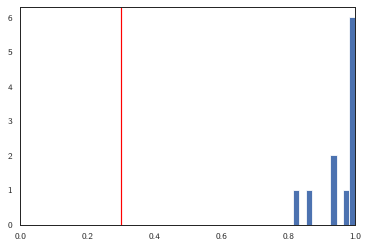

DROP: features with more than 30% nan:  Index([], dtype='object')
DROP: features with zero variance:  Index([], dtype='object')
DROP: features with high VIF:  Series([], dtype: float64)


In [32]:
X = perc_zones_phr(tp_agg)
X = X[cols_X]
X = preprocessing(X, drop_vif=True)
X = X.reset_index()

In [33]:
y = perc_zones_glucose(dc_agg)
y = y[cols_y]

Merge cycling + glucose data

In [34]:
y = y.reset_index()

data = pd.merge(X, y, on=['RIDER', 'date'], how='inner') # TODO: think about how
data = data.drop('date', axis=1)
data = data.set_index('RIDER')

In [35]:
data

TIME_duration  POWER_intensity_factor  HR_heart_rate_mean  \
RIDER                                                              
1          -0.703558                0.079044            2.779715   
1          -0.645832               -0.878847            1.923385   
1          -0.009685                0.080275            2.263520   
1          -0.726415               -0.154524            1.232171   
1          -0.019758                0.070946            1.116426   
...              ...                     ...                 ...   
16          1.810617                0.798582            1.704040   
16          0.517403                0.522791            0.263616   
16          0.557501                0.238957            0.678628   
16         -0.443597               -1.165942           -2.439529   
16          0.431783                1.125299            0.668727   

       POWER_variability_index  POWER_efficiency_factor  CALENDAR_race  \
RIDER                                                                    
1                    -1.262524                -1.432728      -0.375268   
1                    -1.294339                -1.871374      -0.375268   
1                    -1.256486                -1.267348      -0.375268   
1                    -1.420507                -1.082013      -0.375268   
1                    -1.365465                -0.857072      -0.375268   
...                        ...                      ...            ...   
16                    0.536768                -0.909040      -0.375268   
16                    0.483929                -0.515644      -0.375268   
16                   -0.253171                -0.918931      -0.375268   
16                    2.369741                -0.647987      -0.375268   
16                    0.620073                -0.232167      -0.375268   

       TIME_day_in_season  TIME_time_start  CALENDAR_travel_3d_any  \
RIDER                                                                
1               -1.746144        -0.470770               -0.486982   
1               -1.735689        -0.538822               -0.486982   
1               -1.725235        -0.256926               -0.486982   
1               -1.714781        -0.344812               -0.486982   
1               -1.704327         0.214762               -0.486982   
...                   ...              ...                     ...   
16              -1.077079        -0.380832               -0.486982   
16              -1.066625        -0.282232               -0.486982   
16              -1.056171        -0.466894               -0.486982   
16              -1.045717        -0.120253               -0.486982   
16              -1.035263        -0.403744               -0.486982   

       LOC_temperature_mean  LOC_altitude_mean  GLUCOSE_hypo_wake  \
RIDER                                                               
1                 -1.410583           0.208488                1.0   
1                 -1.348438           0.146318                1.0   
1                 -1.183087           0.555569                1.0   
1                 -1.323046           0.441459                1.0   
1                 -1.168189           0.481107                1.0   
...                     ...                ...                ...   
16                -1.386524           0.115076                1.0   
16                -0.393061          -0.043062                1.0   
16                -0.850857          -0.045556                1.0   
16                -0.180559          -0.547662                1.0   
16                -0.250050          -0.143595                1.0   

       GLUCOSE_hypo_exercise  GLUCOSE_hypo_recovery  GLUCOSE_hypo_sleep  \
RIDER                                                                     
1                        1.0                    1.0                 1.0   
1                        0.0                    1.0                 1.0   
1                        1.0                    1.

In [36]:
print("Data available: N =", len(data.index.get_level_values(0).unique()), "; D =", len(data))

Data available: N = 12 ; D = 1778


/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


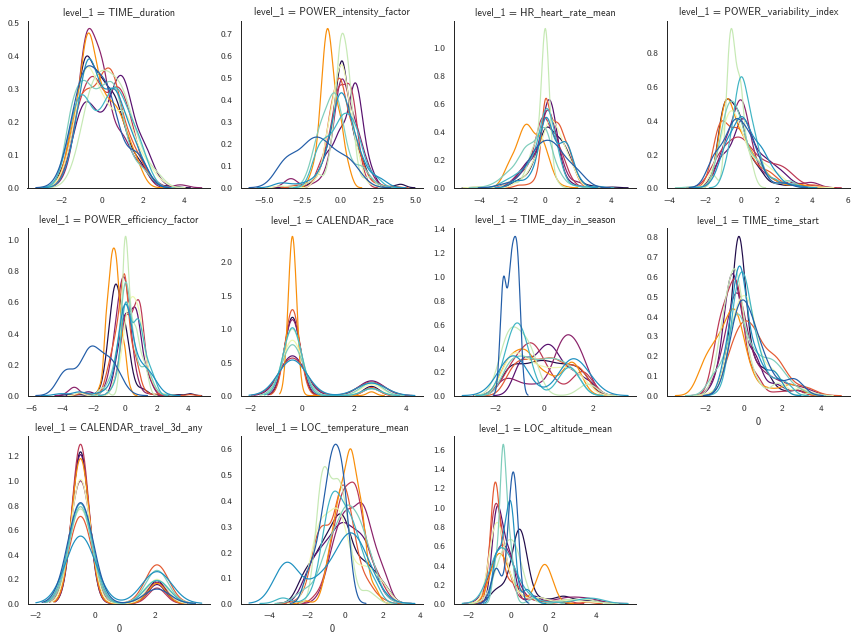

In [37]:
g = sns.FacetGrid(data[cols_X].stack().reset_index(), hue='RIDER', palette=palette_ath, 
                  col="level_1", col_wrap=4, sharex=False, sharey=False)
g.map(sns.kdeplot, 0)

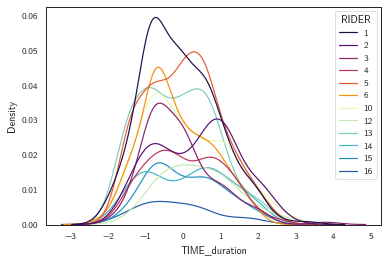

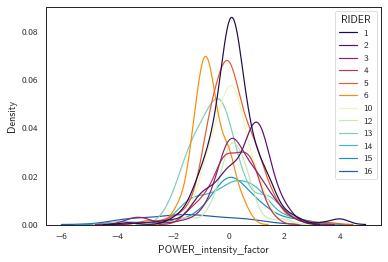

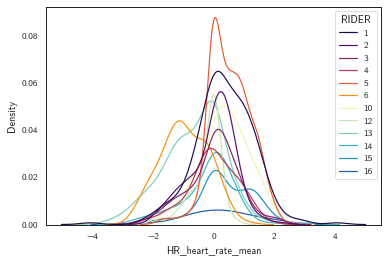

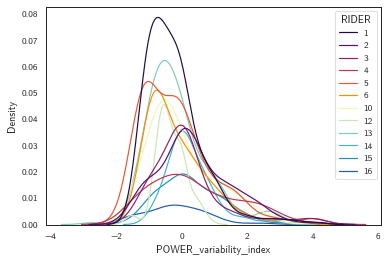

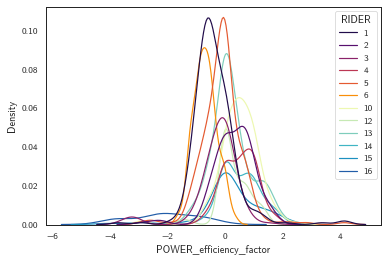

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


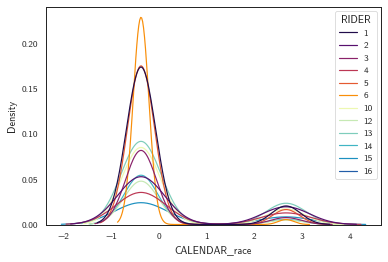

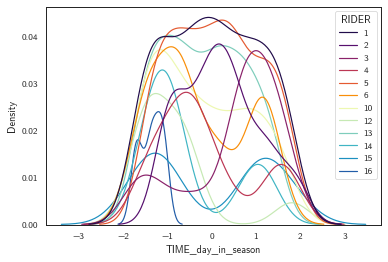

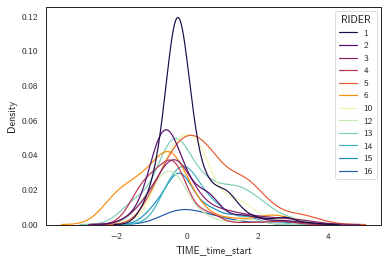

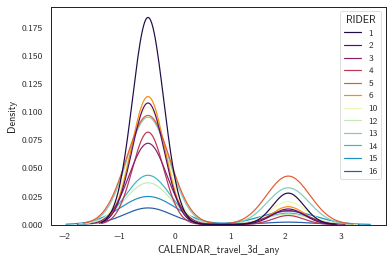

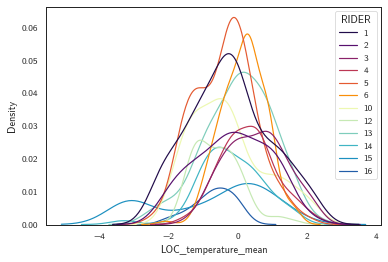

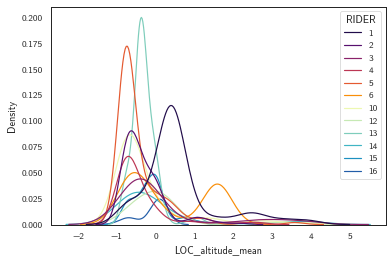

In [38]:
for col in cols_X:
    sns.kdeplot(data=data, x=col, hue='RIDER', palette=palette_ath)
    plt.show()

In [39]:
corr = data[cols_X.keys()].corr()

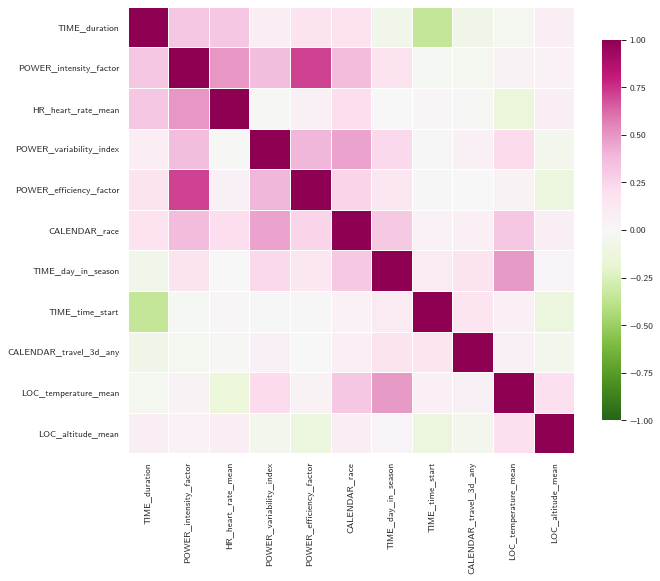

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap='PiYG_r',
            linewidths=.5, cbar_kws=dict(shrink=0.7), square=True)
plt.xlabel('') ; plt.ylabel('') ; plt.show()

## Model

Perform analysis in R

In [41]:
from rpy2.robjects.packages import importr

from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

base = importr('base')
stats = importr('stats')
lme4 = importr('lme4')

/local/home/evanweenen/.local/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [61]:
from itertools import combinations

def get_formula(X, y, interactions=False, random_effects=False):
    """
    Get regression formula based on data given
    Note: current implementation only allows for interactions and random effects of all variables
    
    Arguments
        X - independent variables
        y - dependent variable
        interactions - whether to include interactions for all variables
        random effects - whether to include random effects for all variables
        
    Returns
        formula_y - dependent part of formula
        formula_fix - fixed effects formula
        formula_int - interactions formula
        formula_rnd - random effects formula
    """
    cols_X = X.columns if type(X) == pd.DataFrame else [X.name]
    groups = list(X.index.names)[0]
        
    # get formula
    formula_y = y.columns[0] + '~'
    formula_fix = '1+' + '+'.join(cols_X)
    formula_int = ''.join([f'+{col_A}*{col_B}' if interactions else '' for col_A, col_B in combinations(cols_X, 2)])
    if random_effects:
        formula_rnd = '+(1+' + '+'.join(cols_X)+f'|{groups})'
    else:
        formula_rnd = f'+(1|{groups})'

    return formula_y, formula_fix, formula_int, formula_rnd

In [43]:
def GLMM(X, y, family='binomial', fname='', **kwargs):  
    """
    Perform Generalized Linear Mixed Model using lme4 in R
    
    Arguments
        X - independent variables
        y - dependent variable
        family - model family (link function)
        fname - filename for saving model results
        kwargs - any arguments passed to get_formula (e.g. whether to use interactions or random effects)
    
    Returns
        model - R lme4.glmer model
        summary - model summary
    """
    formula = ''.join(get_formula(X, y, **kwargs))
    print(formula)

    data = pd.concat([X,y], axis=1).reset_index()
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_df = ro.conversion.py2rpy(data)
        
    model = lme4.glmer(formula, data=r_df, family=family)
    
    base.sink(f'{SAVE_PATH}model_{family}_{fname}.txt')
    print(base.summary(model))
    base.sink()  # returns output to the console

    return model, base.summary(model)

In [44]:
def read_regression_results(filename):
    """
    Read regression results from R to pandas table in python
    
    Arguments
        filename - full filename where regression results are stored
    
    Returns
        fe - fixed effects results
        re - random effects results
        score - evaluation of model
        res - residuals
    """
    with open(filename) as f:
        lines = f.readlines()

    # identify start and end
    start_score = np.where([l.lstrip().startswith('AIC') for l in lines])[0][0]
    start_res = np.where([l.startswith('Scaled residuals') for l in lines])[0][0]
        
    start = np.where([l.startswith('Random effects') for l in lines])[0][0]
    mid = np.where([l.startswith('Fixed effects') for l in lines])[0][0]
    end = np.where([l.startswith(('Signif. codes', 'Correlation of Fixed Effects')) for l in lines])[0][0]

    # read csv
    fe = pd.read_csv(filename, skiprows=mid+1, skipfooter=len(lines)-end+1, 
                     delimiter="\s+(?!<)", engine='python')
    re = pd.read_csv(filename, skiprows=start+1, skipfooter=len(lines)-mid+2, 
                     delimiter="\s+(?!<)", engine='python')
    fe.columns = ['Feature', 'Estimate', 'Std. Error', 'z value', 'Pr(>|z|)', 'Sign']
    
    score = pd.read_csv(filename, skiprows=start_score, skipfooter=len(lines)-start_score-3, 
                    delimiter="\s+(?!<)", engine='python')
    res = pd.read_csv(filename, skiprows=start_res+1, skipfooter=len(lines)-start_res-4, 
                    delimiter="\s+(?!<)", engine='python')
    
    return fe, re, score, res

In [172]:
from copy import copy

def combine_regression_results(event, name, family='binomial'):
    """
    Combine the results of the regressions on three sections: exercise, recovery and sleep
    Read the regression results, calculate 95% CI, and convert the results to the appropriate format
    
    Arguments
        event - event of dependent variable (i.e. either hypo or hyper)
        name - name of the regression (often just independent variables, e.g. "duration")
        family - model family used in the regression
        
    Returns
        fe - fixed effects results of three sections
        re - random effects results of three sections
        score - evaluation of model of three sections
        res - residuals of three sections
    """
    # read model results from files
    fe, re, score, res = {}, {}, {}, {}
    for sec in ('exercise', 'recovery', 'sleep'):
        fe[sec], re[sec], score[sec], res[sec] = read_regression_results(SAVE_PATH+f'model_{family}_{event}_{sec}_{name}.txt')
        fe[sec] = fe[sec].set_index('Feature')
        
        re[sec] = re[sec].T.reset_index()
        for col in re[sec].columns.drop(['index', 0]):
            re[sec][col] = re[sec][col].shift()
            re[sec][col] = re[sec][col].fillna(re[sec].loc[0,0])
        re[sec] = re[sec].set_index('index').T
        
    fe = pd.concat(fe)
    re = pd.concat(re)
    score = pd.concat(score, axis=1)
    res = pd.concat(res, axis=1)

    # calculate upper and lower 95% CI boundary
    fe['CI_lower'] = fe['Estimate'] - 1.96*fe['Std. Error']
    fe['CI_upper'] = fe['Estimate'] + 1.96*fe['Std. Error']
    
    # transform everything from log-odds to odds
    fe['CI_lower'] = np.exp(fe['CI_lower'])
    fe['CI_upper'] = np.exp(fe['CI_upper'])
    fe['Estimate'] = np.exp(fe['Estimate'])
    
    # round off
    cols_fe = ['Estimate', 'CI_lower', 'CI_upper', 'Pr(>|z|)']
    fe[cols_fe] = fe[cols_fe].round(2)
    
    # convert format
    cols_fe += ['Sign']
    fe = fe[cols_fe].reset_index().pivot(index='Feature', columns='level_0')
    fe.columns = fe.columns.swaplevel(0,1)
    fe = fe[pd.MultiIndex.from_product([fe.columns.get_level_values(0).unique(), cols_fe])]
    fe.columns.names = [None, None]

    cols_0 = {**{"(Intercept)": "Intercept"}, **copy(cols_X)}
    cols_re = ['Variance', 'Std.Dev.', 'Corr']
    re = re.reset_index().pivot(index=['Groups', 'Name'], columns=['level_0'], values=cols_re)
    re.columns = re.columns.swaplevel(0,1)
    re = re[pd.MultiIndex.from_product([re.columns.get_level_values(0).unique(), cols_re])]
    re.columns.names = [None, None]
    re = re.round(2)
    re = re.rename(index=cols_0)
    
    fe = fe.sort_index(key = lambda x: x.map({key:k+1 for k, key in enumerate(cols_0.keys())}))
    fe = fe.rename(index=cols_0)
    fe = fe.replace({None:''})
    return fe, re, score, res

In [ ]:
from IPython.display import display

def regress(data, x, name, event, family='binomial', show_boxplot=False, show_hist=False, **kwargs):
    """
    Do regression and read and save results
    
    Arguments
        data - data used for regression
        x - (list) independent variables
        event - event of dependent variable (i.e. either hypo or hyper)
        name - name of the regression (often just independent variables, e.g. "duration")
        family - model family used in the regression
        show_boxplot - whether to show boxplot of independent vs target variable
        show_hist - whether to show histogram of independent variables
        kwargs - any arguments passed to get_formula (e.g. whether to use interactions or random effects)
        
    Returns
        fe - fixed effects results of three sections
        re - random effects results of three sections
        score - evaluation of model of three sections
        res - residuals of three sections
    """
    print(event.upper())
    print(f"{family}: {event} ~ {'+'.join(x)}")
    if show_hist:
        for col in x:
            sns.kdeplot(data=data, x=col, hue='RIDER', palette=palette_ath) ; plt.show()
    for sec in ('exercise', 'recovery', 'sleep'):
        y = f'GLUCOSE_{event}_{sec}'
        if show_boxplot:
            for col in x:
                fig, ax = plt.subplots(figsize=(8,4))
                sns.boxplot(ax=ax, data=data.reset_index(), x='RIDER', y=col, hue=y)
                plt.show()
        model, summary = GLMM(data[x], data[[y]], fname=f'{event}_{sec}_{name}', family=family, **kwargs)
    fe, re, score, res = combine_regression_results(event, name, family)
    display(score)
    display(res)
    display(re)
    display(fe)
    return fe, re, score, res

In [47]:
fe, re, score, res = regress(data, x=cols_X, name='all', event='hypo')

HYPO
binomial: hypo ~ TIME_duration+POWER_intensity_factor+HR_heart_rate_mean+POWER_variability_index+POWER_efficiency_factor+CALENDAR_race+TIME_day_in_season+TIME_time_start+CALENDAR_travel_3d_any+LOC_temperature_mean+LOC_altitude_mean
GLUCOSE_hypo_exercise~1+TIME_duration+POWER_intensity_factor+HR_heart_rate_mean+POWER_variability_index+POWER_efficiency_factor+CALENDAR_race+TIME_day_in_season+TIME_time_start+CALENDAR_travel_3d_any+LOC_temperature_mean+LOC_altitude_mean+(1|RIDER)

GLUCOSE_hypo_recovery~1+TIME_duration+POWER_intensity_factor+HR_heart_rate_mean+POWER_variability_index+POWER_efficiency_factor+CALENDAR_race+TIME_day_in_season+TIME_time_start+CALENDAR_travel_3d_any+LOC_temperature_mean+LOC_altitude_mean+(1|RIDER)

GLUCOSE_hypo_sleep~1+TIME_duration+POWER_intensity_factor+HR_heart_rate_mean+POWER_variability_index+POWER_efficiency_factor+CALENDAR_race+TIME_day_in_season+TIME_time_start+CALENDAR_travel_3d_any+LOC_temperature_mean+LOC_altitude_mean+(1|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1525.5  1596.8 -749.8   1499.5     1765   1696.5  1767.8 -835.3   1670.5   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1761  1898.8  1970.0 -936.4   1872.8     1745

exercise                                  recovery                        \
       Min      1Q  Median      3Q      Max      Min      1Q  Median    3Q   
0  -2.0981 -0.5147 -0.2857 -0.0872  14.0047   -1.725 -0.5065 -0.3745 -0.17   

            sleep                                 
      Max     Min      1Q Median      3Q     Max  
0  5.5248 -1.4392 -0.6536 -0.416  0.8784  4.5283

exercise          recovery             sleep         
       Variance Std.Dev. Variance Std.Dev. Variance Std.Dev.
Groups                                                      
RIDER      1.56     1.25     1.36     1.16     0.67     0.82

exercise                                 recovery           \
                  Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                        
Intercept            -1.75    -2.48    -1.02     0.00  ***    -1.35    -2.03   
Duration              0.40     0.25     0.56     0.00  ***     0.10    -0.04   
Intensity factor     -0.00    -0.39     0.39     1.00          0.18    -0.12   
Heart rate           -0.09    -0.35     0.16     0.47         -0.17    -0.38   
Variability index    -0.26    -0.44    -0.08     0.00   **    -0.06    -0.20   
Efficiency factor     0.00    -0.42     0.42     0.99          0.11    -0.23   
Competition          -0.58    -0.79    -0.37     0.00  ***    -0.13    -0.28   
Day in season        -0.12    -0.27     0.03     0.13         -0.07    -0.21   
Starting time        -0.02    -0.18     0.13     0.77          0.01    -0.13   
Travel                0.02    -0.13     0.16     0.82          0.08    -0.05   
Temperature           0.17     0.01     0.33     0.04    *     0.04    -0.11   
Altitude             -0.40    -0.59    -0.21     0.00  ***    -0.21    -0.37   

                                            sleep                             \
                  CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                        
Intercept            -0.67     0.00  ***    -1.04    -1.52    -0.55     0.00   
Duration              0.24     0.17          0.14     0.01     0.28     0.03   
Intensity factor      0.49     0.23         -0.00    -0.29     0.29     0.99   
Heart rate            0.04     0.11          0.11    -0.09     0.30     0.29   
Variability index     0.09     0.47         -0.01    -0.15     0.13     0.85   
Efficiency factor     0.44     0.53          0.09    -0.24     0.42     0.59   
Competition           0.02     0.09    .    -0.03    -0.17     0.11     0.69   
Day in season         0.07     0.35          0.23     0.10     0.37     0.00   
Starting time         0.15     0.89          0.13    -0.01     0.26     0.06   
Travel                0.21     0.24         -0.13    -0.26    -0.00     0.04   
Temperature           0.19     0.64         -0.26    -0.40    -0.12     0.00   
Altitude             -0.05     0.01    *    -0.04    -0.18     0.10     0.55   

                        
                  Sign  
Feature                 
Intercept          ***  
Duration             *  
Intensity factor        
Heart rate              
Variability index       
Efficiency factor       
Competition             
Day in season      ***  
Starting time        .  
Travel               *  
Temperature        ***  
Altitude

In [50]:
with open(SAVE_PATH+"model_binomial_hypo_multivariate.tex", 'w') as file:
	file.write(fe.to_latex(column_format='c', escape=False))
	file.write(re.to_latex(column_format='c', escape=False))

In [51]:
fe, re, score, res = regress(data, x=cols_X, name='all', event='hyper')

HYPER
binomial: hyper ~ TIME_duration+POWER_intensity_factor+HR_heart_rate_mean+POWER_variability_index+POWER_efficiency_factor+CALENDAR_race+TIME_day_in_season+TIME_time_start+CALENDAR_travel_3d_any+LOC_temperature_mean+LOC_altitude_mean
GLUCOSE_hyper_exercise~1+TIME_duration+POWER_intensity_factor+HR_heart_rate_mean+POWER_variability_index+POWER_efficiency_factor+CALENDAR_race+TIME_day_in_season+TIME_time_start+CALENDAR_travel_3d_any+LOC_temperature_mean+LOC_altitude_mean+(1|RIDER)

GLUCOSE_hyper_recovery~1+TIME_duration+POWER_intensity_factor+HR_heart_rate_mean+POWER_variability_index+POWER_efficiency_factor+CALENDAR_race+TIME_day_in_season+TIME_time_start+CALENDAR_travel_3d_any+LOC_temperature_mean+LOC_altitude_mean+(1|RIDER)

GLUCOSE_hyper_sleep~1+TIME_duration+POWER_intensity_factor+HR_heart_rate_mean+POWER_variability_index+POWER_efficiency_factor+CALENDAR_race+TIME_day_in_season+TIME_time_start+CALENDAR_travel_3d_any+LOC_temperature_mean+LOC_altitude_mean+(1|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2131.5  2202.8 -1052.7   2105.5     1765   1908.0  1979.3 -941.0   1882.0   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1761  2186.3  2257.4 -1080.1   2160.3     1745

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -4.3162 -0.8156  0.3808  0.7437  2.4961   -4.645 -0.6835  0.3829  0.6105   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  2.5714 -1.9628 -0.8268 -0.3833  0.9683  3.0423

exercise          recovery             sleep         
       Variance Std.Dev. Variance Std.Dev. Variance Std.Dev.
Groups                                                      
RIDER      0.41     0.64     1.22      1.1      0.8      0.9

exercise                                 recovery           \
                  Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                        
Intercept             0.57     0.19     0.95     0.00   **     0.94     0.29   
Duration              0.19     0.06     0.31     0.00   **    -0.21    -0.34   
Intensity factor      0.06    -0.23     0.34     0.70          0.11    -0.20   
Heart rate            0.27     0.08     0.45     0.01   **    -0.10    -0.30   
Variability index     0.29     0.16     0.43     0.00  ***     0.11    -0.04   
Efficiency factor     0.12    -0.19     0.43     0.44         -0.26    -0.59   
Competition           0.15     0.01     0.29     0.04    *     0.23     0.08   
Day in season         0.01    -0.11     0.14     0.85          0.02    -0.11   
Starting time         0.05    -0.07     0.17     0.43          0.09    -0.04   
Travel                0.10    -0.01     0.21     0.07    .     0.06    -0.07   
Temperature           0.22     0.09     0.35     0.00  ***     0.22     0.08   
Altitude             -0.01    -0.14     0.12     0.85         -0.02    -0.17   

                                            sleep                             \
                  CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                        
Intercept             1.58     0.00   **    -0.26    -0.79     0.26     0.32   
Duration             -0.08     0.00   **    -0.08    -0.20     0.04     0.19   
Intensity factor      0.42     0.49         -0.16    -0.43     0.11     0.25   
Heart rate            0.10     0.34          0.11    -0.07     0.29     0.24   
Variability index     0.26     0.14         -0.07    -0.20     0.05     0.25   
Efficiency factor     0.08     0.14          0.14    -0.16     0.44     0.35   
Competition           0.37     0.00   **     0.09    -0.04     0.22     0.17   
Day in season         0.15     0.77         -0.06    -0.18     0.07     0.37   
Starting time         0.22     0.16         -0.01    -0.13     0.11     0.89   
Travel                0.18     0.37          0.04    -0.06     0.15     0.42   
Temperature           0.36     0.00   **     0.11    -0.02     0.23     0.10   
Altitude              0.12     0.77         -0.02    -0.15     0.10     0.71   

                        
                  Sign  
Feature                 
Intercept               
Duration                
Intensity factor        
Heart rate              
Variability index       
Efficiency factor       
Competition             
Day in season           
Starting time           
Travel                  
Temperature          .  
Altitude

In [52]:
with open(SAVE_PATH+"model_binomial_hyper_multivariate.tex", 'w') as file:
	file.write(fe.to_latex(column_format='c', escape=False))
	file.write(re.to_latex(column_format='c', escape=False))

# Generalized Linear Mixed Model (Univariate)

Select only features that we think are relevant for this analysis

In [53]:
cols_X = {# exercise intensity output
          'POWER_normalised_power'       : 'Normalised power',
          'POWER_intensity_factor'       : 'Intensity factor',
          'POWER_training_stress_score'  : 'Training stress score',
          'POWER_variability_index'      : 'Variability index',
          'POWER_efficiency_factor'      : 'Efficiency factor',
          'POWER_time_in_power_zone1'    : 'Time in power zone 1 (Active Recovery)',
          'POWER_time_in_power_zone2'    : 'Time in power zone 2 (Endurance)',
          'POWER_time_in_power_zone3'    : 'Time in power zone 3 (Tempo)',
          'POWER_time_in_power_zone4'    : 'Time in power zone 4 (Lactate Threshold)',
          'POWER_time_in_power_zone5'    : 'Time in power zone 5 (VO2max)',
          'POWER_time_in_power_zone6'    : 'Time in power zone 6 (Anaerobic Capacity)',
          
          # exercise intensity input
          'HR_heart_rate_mean'           : 'Heart rate',
          'HR_time_in_hr_zone1'          : 'Time in HR zone 1 (Active Recovery)',
          'HR_time_in_hr_zone2'          : 'Time in HR zone 2 (Endurance)',
          'HR_time_in_hr_zone3'          : 'Time in HR zone 3 (Tempo)',
          'HR_time_in_hr_zone4'          : 'Time in HR zone 4 (Lactate Threshold)',
          'HR_time_in_hr_zone5'          : 'Time in HR zone 5 (Anaerobic Capacity)',

          # competitive aspect
          'CALENDAR_race'                : 'Competition',
    
          # duration
          'TIME_duration'                : 'Duration',
    
          # physical fitness
          'POWER_chronic_training_load'  : 'Chronic training load (fitness)', # fitness
          'POWER_acute_training_load'    : 'Acute training load (fatigue)', # fatigue
          'POWER_training_stress_balance': 'Training stress balance (form)', # form
          'TIME_day_in_season'           : 'Day in season',
    
          # external/environmental/circumstantial effects
          'CALENDAR_travel_3d_any'       : 'Travel',
          'LOC_temperature_mean'         : 'Temperature',
          'LOC_altitude_mean'            : 'Altitude',
          'TIME_time_start'              : 'Starting time'}

cols_y = ['GLUCOSE_hypo_'+sec for sec in SECTIONS] + ['GLUCOSE_hyper_'+sec for sec in SECTIONS]

/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


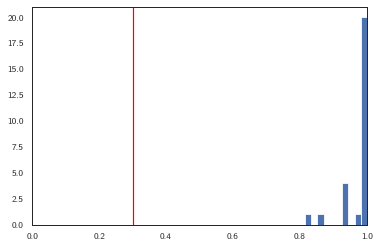

DROP: features with more than 30% nan:  Index([], dtype='object')
DROP: features with zero variance:  Index([], dtype='object')


In [54]:
X = tp_agg[cols_X]
X = preprocessing(X)
X = X.reset_index()

In [55]:
y = dc_agg[cols_y]

Merge cycling + glucose data

In [56]:
y = y.reset_index()

data = pd.merge(X, y, on=['RIDER', 'date'], how='inner') # TODO: think about how
data = data.drop('date', axis=1)
data = data.set_index('RIDER')

In [57]:
data

POWER_normalised_power  POWER_intensity_factor  \
RIDER                                                   
1                   -0.366461                0.079044   
1                   -1.109072               -0.878847   
1                   -0.365507                0.080275   
1                   -0.547536               -0.154524   
1                   -0.372739                0.070946   
...                       ...                     ...   
16                  -0.198756                0.798582   
16                  -0.396082                0.522791   
16                  -0.599163                0.238957   
16                  -1.604358               -1.165942   
16                   0.035008                1.125299   

       POWER_training_stress_score  POWER_variability_index  \
RIDER                                                         
1                        -0.604728                -1.262524   
1                        -0.896859                -1.294339   
1                        -0.115746                -1.256486   
1                        -0.702998                -1.420507   
1                        -0.127782                -1.365465   
...                            ...                      ...   
16                        1.908840                 0.536768   
16                        0.558840                 0.483929   
16                        0.391420                -0.253171   
16                       -0.897092                 2.369741   
16                        0.923924                 0.620073   

       POWER_efficiency_factor  POWER_time_in_power_zone1  \
RIDER                                                       
1                    -1.432728                  -1.254182   
1                    -1.871374                  -0.211993   
1                    -1.267348                  -1.198303   
1                    -1.082013                  -1.339775   
1                    -0.857072                  -1.316713   
...                        ...                        ...   
16                   -0.909040                  -0.853716   
16                   -0.515644                   0.408441   
16                   -0.918931                   0.223065   
16                   -0.647987                   1.011580   
16                   -0.232167                   0.137472   

       POWER_time_in_power_zone2  POWER_time_in_power_zone3  \
RIDER                                                         
1                       0.511066                  -0.171694   
1                       0.291236                  -0.956716   
1                       1.440055                   0.108928   
1                       0.806045                  -0.494050   
1                       1.717326                   0.147063   
...                          ...                        ...   
16                     -0.700808                  -0.127083   
16                     -0.098326                   1.255161   
16                      0.431167                   1.419216   
16                     -0.871836                  -0.895555   
16                     -0.453337                   0.732052   

       POWER_time_in_power_zone4  POWER_time_in_power_zone5  ...  \
RIDER                                                        ...   
1                      -0.562394                  -0.542479  ...   
1                      -0.833954                  -0.676376  ...   
1                      -0.519375                  -0.594212  ...   
1                      -0.675320                  -0.703764  ...   
1                      -0.612135                  -0.642901  ...   
...                          ...                        ...  ...   
16                     -0.101280                   0.047886  ...   
16                      1.108640                   0.300464  ...   
16                      0.652904                  -0.229038  ...   
16                     -0.797657                  -0.685505  ...   
16             

In [58]:
print("Data available: N =", len(data.index.get_level_values(0).unique()), "; D =", len(data))

Data available: N = 12 ; D = 1778


/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


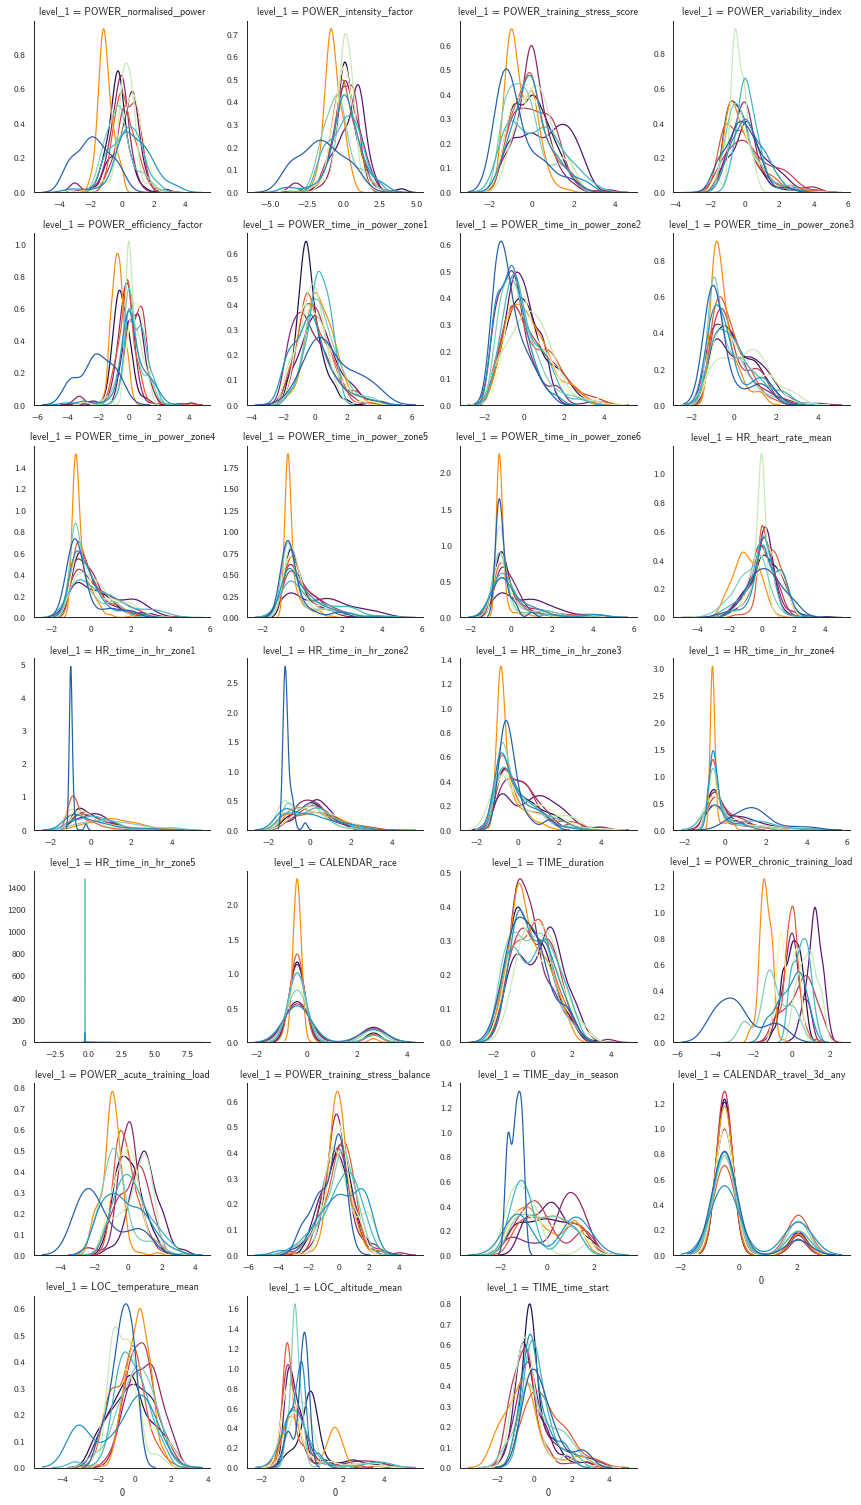

In [141]:
g = sns.FacetGrid(data[cols_X].stack().reset_index(), hue='RIDER', palette=palette_ath, 
                  col="level_1", col_wrap=4, sharex=False, sharey=False)
g.map(sns.kdeplot, 0)

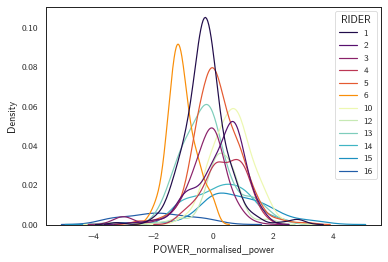

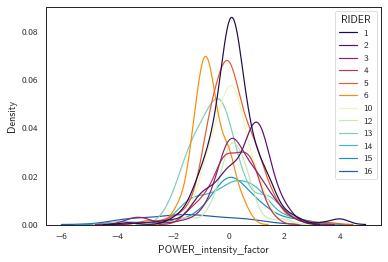

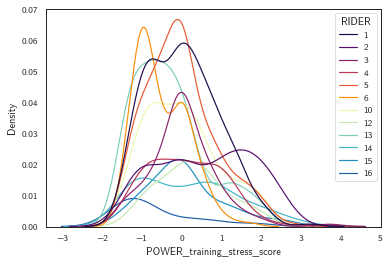

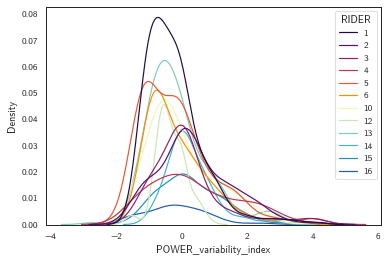

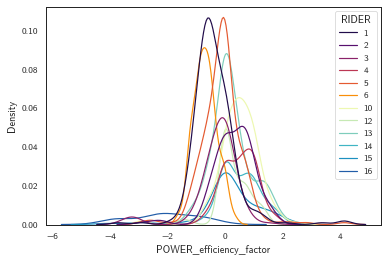

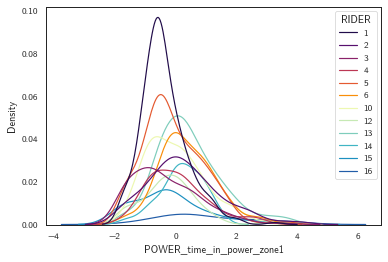

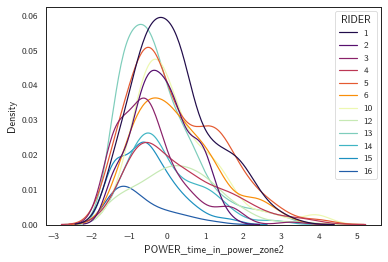

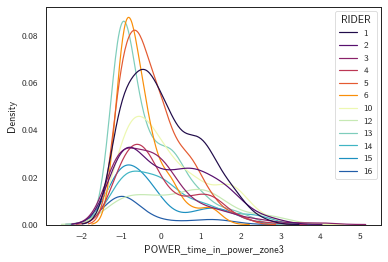

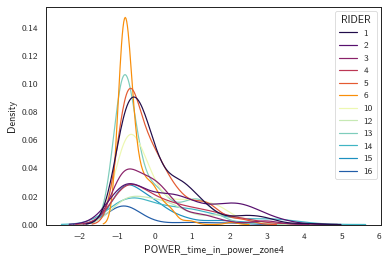

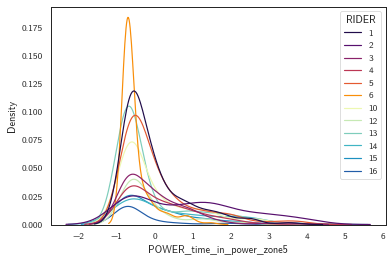

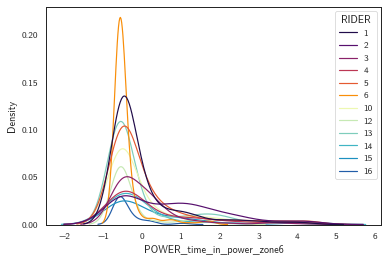

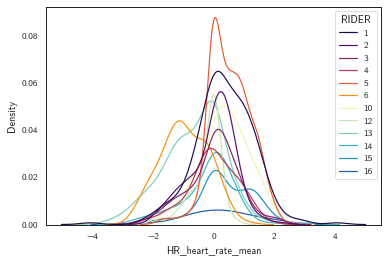

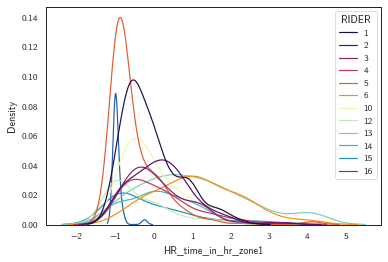

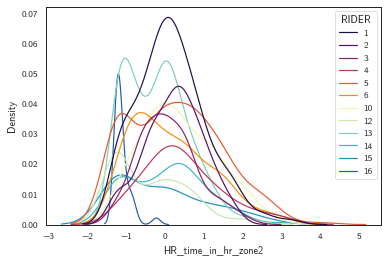

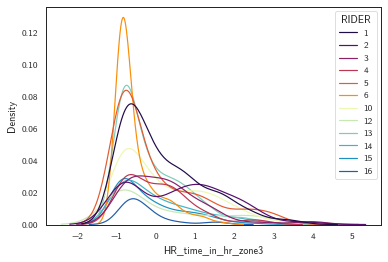

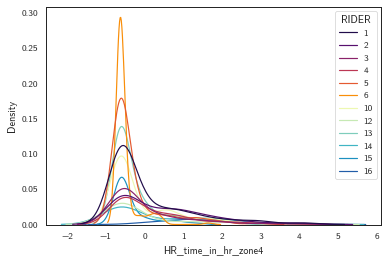

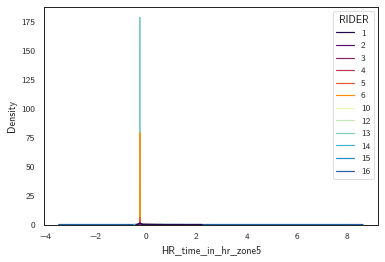

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


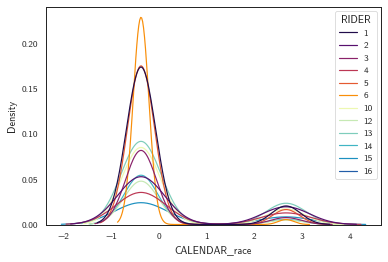

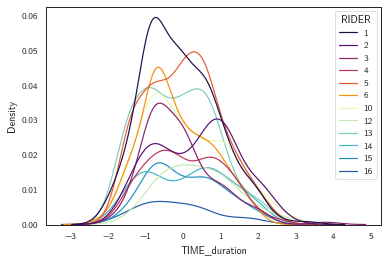

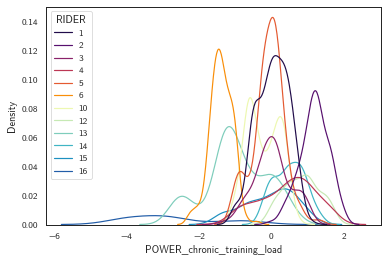

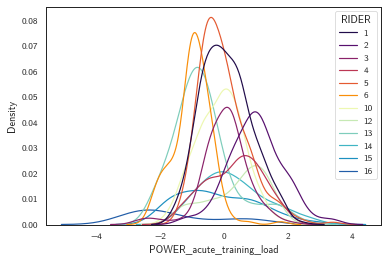

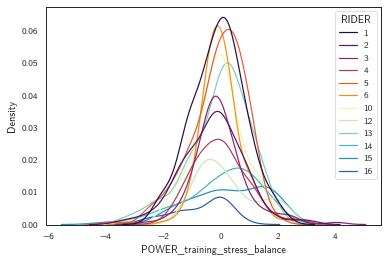

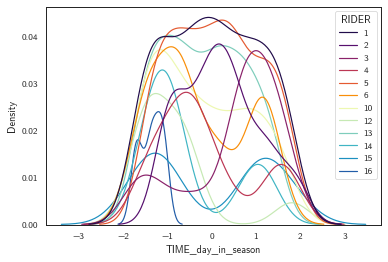

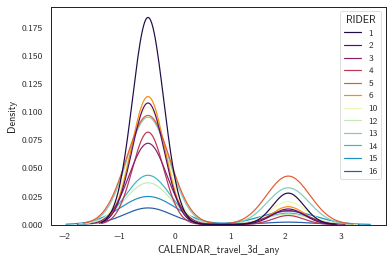

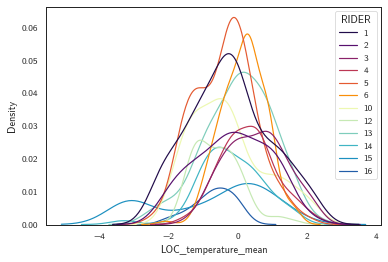

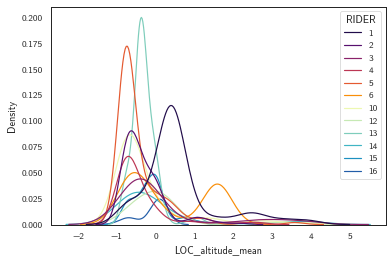

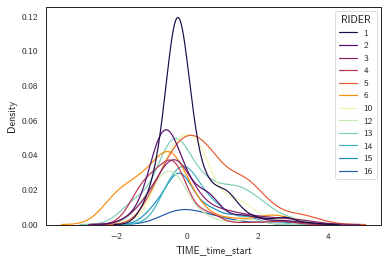

In [142]:
for col in cols_X:
    sns.kdeplot(data=data, x=col, hue='RIDER', palette=palette_ath)
    plt.show()

In [143]:
corr = data[cols_X.keys()].corr()

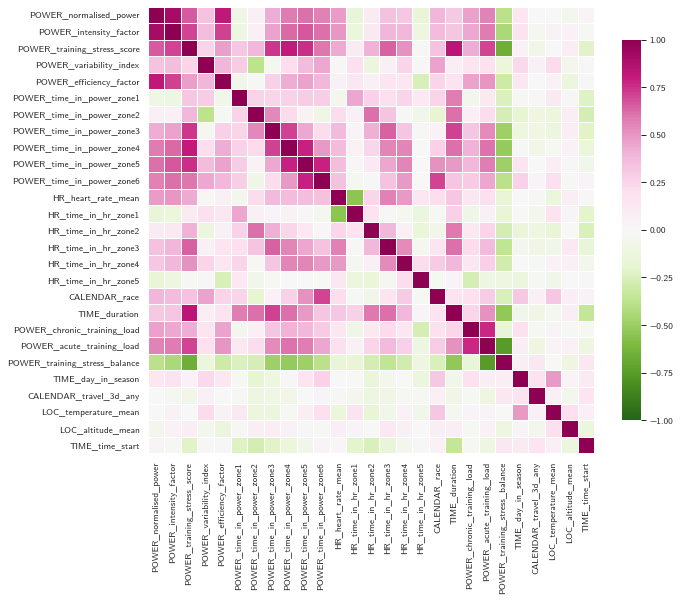

In [144]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap='PiYG_r',
            linewidths=.5, cbar_kws=dict(shrink=0.7), square=True)
plt.xlabel('') ; plt.ylabel('') ; plt.show()

HYPO
binomial: hypo ~ POWER_normalised_power


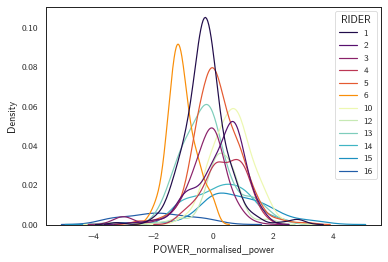

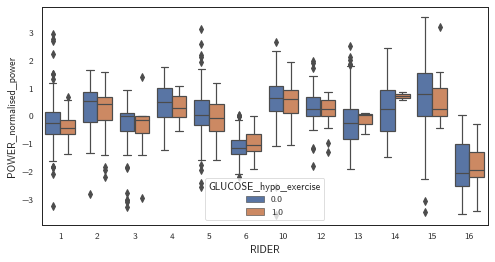

GLUCOSE_hypo_exercise~1+POWER_normalised_power+(1+POWER_normalised_power|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



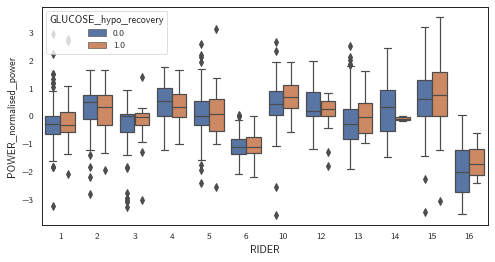

GLUCOSE_hypo_recovery~1+POWER_normalised_power+(1+POWER_normalised_power|RIDER)



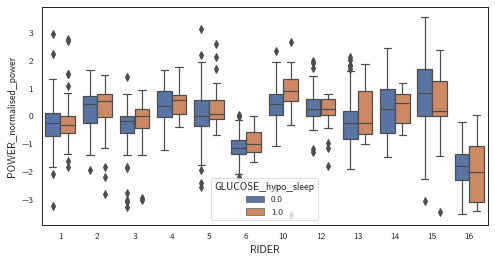

GLUCOSE_hypo_sleep~1+POWER_normalised_power+(1+POWER_normalised_power|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1631.3  1658.7 -810.6   1621.3     1773   1703.3  1730.8 -846.7   1693.3   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1905.9  1933.3 -948.0   1895.9     1753

exercise                                 recovery                         \
       Min      1Q  Median      3Q     Max      Min      1Q Median      3Q   
0  -1.5084 -0.5337 -0.3434 -0.1438  6.9459  -1.4283 -0.4774 -0.389 -0.1914   

           sleep                                  
      Max    Min      1Q  Median      3Q     Max  
0  5.1733 -1.161 -0.7166 -0.4185  0.8949  5.1593

exercise                 recovery           \
                                Variance  Std.Dev. Corr  Variance Std.Dev.   
Groups Name                                                                  
RIDER  (Intercept)                 1.423  1.193051  NaN  1.244459  1.11555   
       POWER_normalised_power  6.101e-05  0.007811 -1.0  0.006896  0.08304   

                                        sleep                 
                               Corr  Variance Std.Dev.  Corr  
Groups Name                                                   
RIDER  (Intercept)              NaN  0.753430   0.8680   NaN  
       POWER_normalised_power  0.58   0.08083   0.2843 -0.64

exercise                                 recovery           \
                 Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                       
Intercept           -1.59    -2.29    -0.89      0.0  ***    -1.33    -1.99   
Normalised power    -0.15    -0.33     0.03      0.1    .     0.13    -0.04   

                                           sleep                             \
                 CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                       
Intercept           -0.68     0.00  ***    -1.03    -1.54    -0.52     0.00   
Normalised power     0.30     0.14          0.20    -0.03     0.42     0.08   

                       
                 Sign  
Feature                
Intercept         ***  
Normalised power    .

HYPO
binomial: hypo ~ POWER_intensity_factor


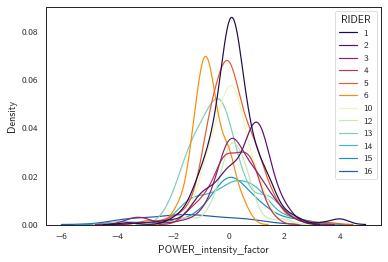

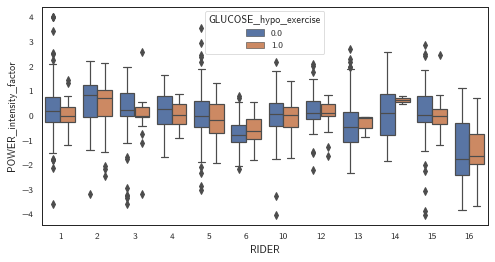

GLUCOSE_hypo_exercise~1+POWER_intensity_factor+(1+POWER_intensity_factor|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



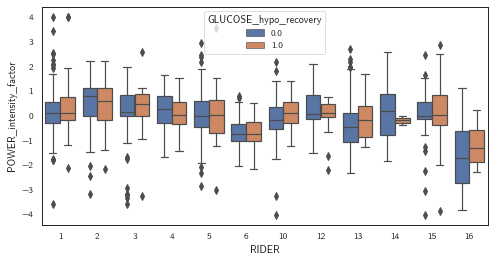

GLUCOSE_hypo_recovery~1+POWER_intensity_factor+(1+POWER_intensity_factor|RIDER)



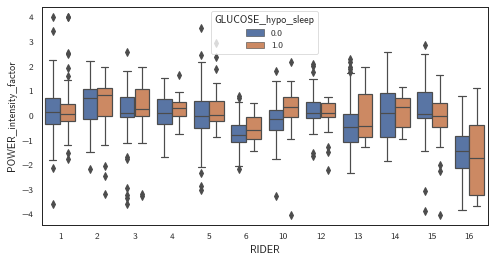

GLUCOSE_hypo_sleep~1+POWER_intensity_factor+(1+POWER_intensity_factor|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1630.6  1658.0 -810.3   1620.6     1773   1704.7  1732.1 -847.4   1694.7   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1906.8  1934.2 -948.4   1896.8     1753

exercise                                 recovery                         \
       Min      1Q  Median      3Q     Max      Min      1Q Median      3Q   
0  -1.5194 -0.5353 -0.3431 -0.1448  6.8946  -1.3915 -0.4787 -0.389 -0.1884   

            sleep                                 
      Max     Min      1Q  Median     3Q     Max  
0  5.2353 -1.1389 -0.7186 -0.4169  0.894  5.1292

exercise                recovery           \
                                Variance Std.Dev. Corr  Variance Std.Dev.   
Groups Name                                                                 
RIDER  (Intercept)              1.408316  1.18672  NaN  1.323686  1.15052   
       POWER_intensity_factor  0.0006144  0.02479 -1.0  0.002668  0.05165   

                                        sleep                 
                               Corr  Variance Std.Dev.  Corr  
Groups Name                                                   
RIDER  (Intercept)              NaN  0.685150   0.8277   NaN  
       POWER_intensity_factor  0.53   0.05319   0.2306 -0.61

exercise                                 recovery           \
                 Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                       
Intercept           -1.59    -2.28    -0.89     0.00  ***    -1.33    -2.00   
Intensity factor    -0.14    -0.29     0.02     0.08    .     0.10    -0.04   

                                           sleep                             \
                 CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                       
Intercept           -0.66     0.00  ***    -1.01     -1.5    -0.52     0.00   
Intensity factor     0.24     0.18          0.18     -0.0     0.37     0.05   

                       
                 Sign  
Feature                
Intercept         ***  
Intensity factor    .

HYPO
binomial: hypo ~ POWER_training_stress_score


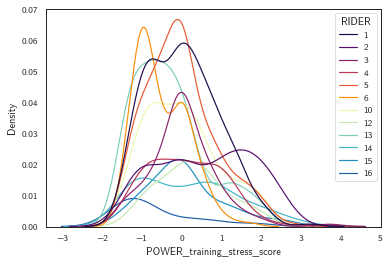

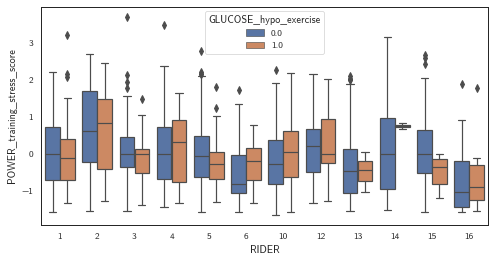

GLUCOSE_hypo_exercise~1+POWER_training_stress_score+(1+POWER_training_stress_score|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



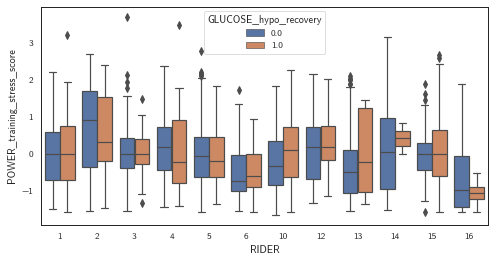

GLUCOSE_hypo_recovery~1+POWER_training_stress_score+(1+POWER_training_stress_score|RIDER)



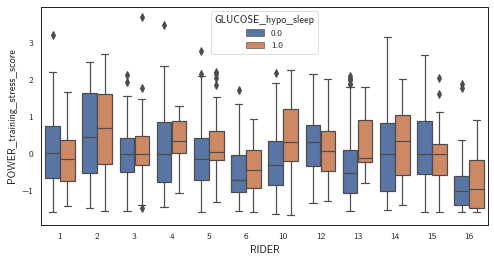

GLUCOSE_hypo_sleep~1+POWER_training_stress_score+(1+POWER_training_stress_score|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1632.0  1659.5 -811.0   1622.0     1773   1703.3  1730.7 -846.7   1693.3   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1897.6  1924.9 -943.8   1887.6     1753

exercise                                recovery                          \
       Min     1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -1.3487 -0.531 -0.3396 -0.1406  7.0848  -1.5106 -0.4739 -0.3861 -0.1866   

            sleep                                 
      Max     Min      1Q  Median      3Q    Max  
0  5.2967 -1.2466 -0.7093 -0.4156  0.8945  4.909

exercise                recovery           \
                                    Variance Std.Dev. Corr  Variance Std.Dev.   
Groups Name                                                                     
RIDER  (Intercept)                  1.394650   1.1810  NaN  1.318860   1.1484   
       POWER_training_stress_score   0.01892   0.1375  1.0   0.01168   0.1081   

                                             sleep                 
                                    Corr  Variance Std.Dev.  Corr  
Groups Name                                                        
RIDER  (Intercept)                   NaN  0.701350   0.8375   NaN  
       POWER_training_stress_score  0.89   0.08096   0.2845 -0.59

exercise                                 recovery  \
                      Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate   
Feature                                                                   
Intercept                -1.58    -2.27    -0.89     0.00  ***    -1.34   
Training stress score    -0.01    -0.19     0.17     0.93          0.07   

                                                         sleep           \
                      CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                   
Intercept                -2.01    -0.67     0.00  ***    -1.02    -1.51   
Training stress score    -0.08     0.23     0.35          0.19    -0.02   

                                              
                      CI_upper Pr(>|z|) Sign  
Feature                                       
Intercept                -0.53     0.00  ***  
Training stress score     0.39     0.08    .

HYPO
binomial: hypo ~ POWER_variability_index


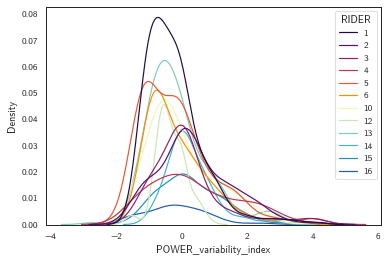

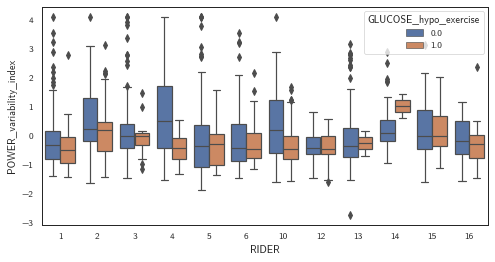

GLUCOSE_hypo_exercise~1+POWER_variability_index+(1+POWER_variability_index|RIDER)



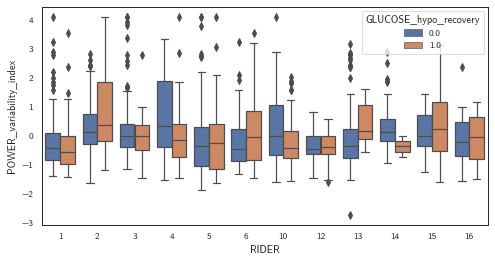

GLUCOSE_hypo_recovery~1+POWER_variability_index+(1+POWER_variability_index|RIDER)



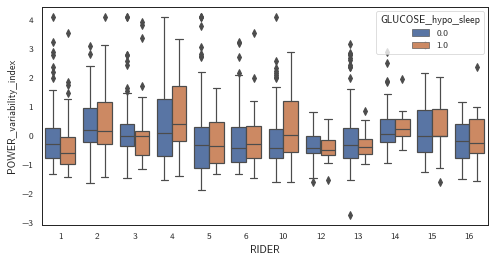

GLUCOSE_hypo_sleep~1+POWER_variability_index+(1+POWER_variability_index|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1594.7  1622.1 -792.4   1584.7     1773   1693.2  1720.6 -841.6   1683.2   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1914.1  1941.5 -952.1   1904.1     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -1.8242 -0.5309 -0.3455 -0.1422  7.0271  -1.4708 -0.4673 -0.3909 -0.1808   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  5.6344 -1.1415 -0.6943 -0.4248  0.8962  4.0241

exercise                 recovery           \
                                Variance Std.Dev.  Corr  Variance Std.Dev.   
Groups Name                                                                  
RIDER  (Intercept)              1.399780    1.183   NaN  1.341440   1.1582   
       POWER_variability_index   0.06603    0.257 -0.92   0.07931   0.2816   

                                         sleep                 
                                Corr  Variance Std.Dev.  Corr  
Groups Name                                                    
RIDER  (Intercept)               NaN  0.696640   0.8347   NaN  
       POWER_variability_index -0.67   0.02788   0.1670 -0.12

exercise                                 recovery           \
                  Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                        
Intercept            -1.59    -2.29    -0.90     0.00  ***    -1.34    -2.02   
Variability index    -0.27    -0.49    -0.05     0.02    *     0.04    -0.18   

                                            sleep                             \
                  CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                        
Intercept            -0.67     0.00  ***    -1.03    -1.52    -0.54     0.00   
Variability index     0.25     0.73          0.00    -0.16     0.16     0.98   

                        
                  Sign  
Feature                 
Intercept          ***  
Variability index

HYPO
binomial: hypo ~ POWER_efficiency_factor


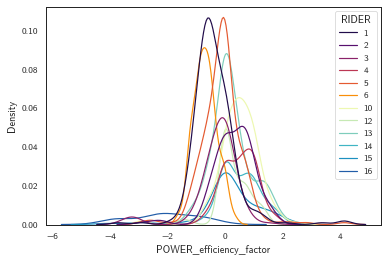

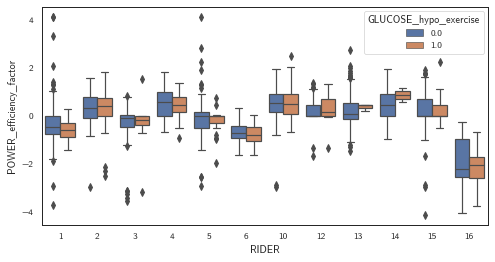

GLUCOSE_hypo_exercise~1+POWER_efficiency_factor+(1+POWER_efficiency_factor|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



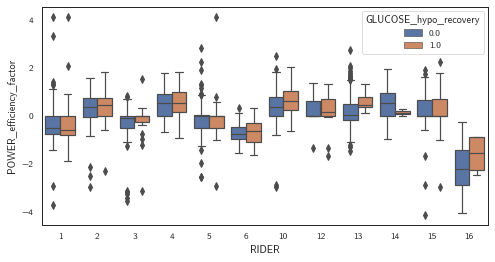

GLUCOSE_hypo_recovery~1+POWER_efficiency_factor+(1+POWER_efficiency_factor|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



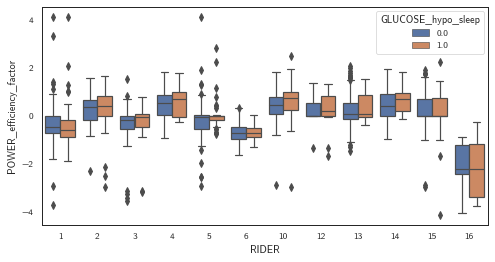

GLUCOSE_hypo_sleep~1+POWER_efficiency_factor+(1+POWER_efficiency_factor|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1632.9  1660.4 -811.5   1622.9     1773   1698.2  1725.6 -844.1   1688.2   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1912.9  1940.2 -951.4   1902.9     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -1.0935 -0.5316 -0.3512 -0.1412  7.0595  -1.6257 -0.4775 -0.3856 -0.1881   

            sleep                                 
      Max     Min      1Q Median      3Q     Max  
0  5.1427 -1.1297 -0.6966 -0.425  0.8975  4.6665

exercise                recovery           \
                                Variance Std.Dev. Corr  Variance Std.Dev.   
Groups Name                                                                 
RIDER  (Intercept)              1.304640   1.1422  NaN  1.176730   1.0848   
       POWER_efficiency_factor   0.01206   0.1098  1.0   0.02499   0.1581   

                                        sleep                 
                               Corr  Variance Std.Dev.  Corr  
Groups Name                                                   
RIDER  (Intercept)              NaN  0.794340   0.8913   NaN  
       POWER_efficiency_factor  1.0   0.01955   0.1398 -0.92

exercise                                 recovery           \
                  Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                        
Intercept            -1.58    -2.25    -0.91     0.00  ***    -1.33    -1.96   
Efficiency factor    -0.14    -0.35     0.07     0.18          0.19    -0.01   

                                            sleep                             \
                  CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                        
Intercept            -0.69     0.00  ***    -1.04    -1.56    -0.52     0.00   
Efficiency factor     0.39     0.06    .     0.19    -0.00     0.38     0.05   

                        
                  Sign  
Feature                 
Intercept          ***  
Efficiency factor    .

HYPO
binomial: hypo ~ POWER_time_in_power_zone1


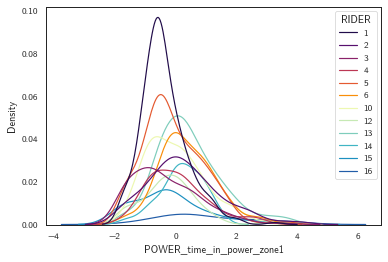

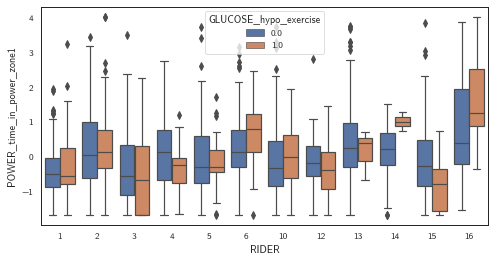

GLUCOSE_hypo_exercise~1+POWER_time_in_power_zone1+(1+POWER_time_in_power_zone1|RIDER)



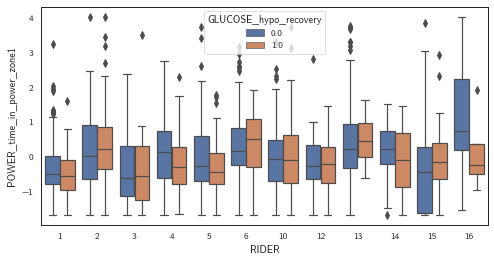

GLUCOSE_hypo_recovery~1+POWER_time_in_power_zone1+(1+POWER_time_in_power_zone1|RIDER)



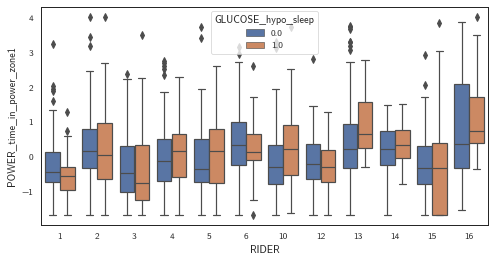

GLUCOSE_hypo_sleep~1+POWER_time_in_power_zone1+(1+POWER_time_in_power_zone1|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1632.9  1660.3 -811.4   1622.9     1773   1705.8  1733.2 -847.9   1695.8   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1908.4  1935.8 -949.2   1898.4     1753

exercise                              recovery                          \
       Min      1Q Median      3Q   Max      Min      1Q  Median      3Q   
0  -1.1184 -0.5301 -0.335 -0.1427  6.93  -1.2586 -0.4826 -0.3954 -0.1828   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  5.7098 -1.2296 -0.6958 -0.4102  0.8897  4.6125

exercise                 recovery           \
                                  Variance Std.Dev.  Corr  Variance Std.Dev.   
Groups Name                                                                    
RIDER  (Intercept)                1.371160   1.1710   NaN  1.325169  1.15116   
       POWER_time_in_power_zone1   0.04492   0.2119  0.11  0.004571  0.06761   

                                           sleep                 
                                  Corr  Variance Std.Dev.  Corr  
Groups Name                                                      
RIDER  (Intercept)                 NaN  0.754070   0.8684   NaN  
       POWER_time_in_power_zone1  0.54   0.05274   0.2296 -0.54

exercise                             \
                                       Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                      
Intercept                                 -1.60    -2.29    -0.91     0.00   
Time in power zone 1 (Active Recovery)    -0.03    -0.24     0.17     0.77   

                                            recovery                    \
                                       Sign Estimate CI_lower CI_upper   
Feature                                                                  
Intercept                               ***    -1.33    -2.00    -0.65   
Time in power zone 1 (Active Recovery)         -0.08    -0.23     0.06   

                                                        sleep           \
                                       Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                  
Intercept                                  0.00  ***    -1.06    -1.57   
Time in power zone 1 (Active Recovery)     0.26          0.05    -0.13   

                                                               
                                       CI_upper Pr(>|z|) Sign  
Feature                                                        
Intercept                                 -0.55     0.00  ***  
Time in power zone 1 (Active Recovery)     0.23     0.58

HYPO
binomial: hypo ~ POWER_time_in_power_zone2


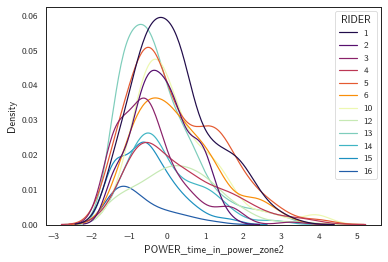

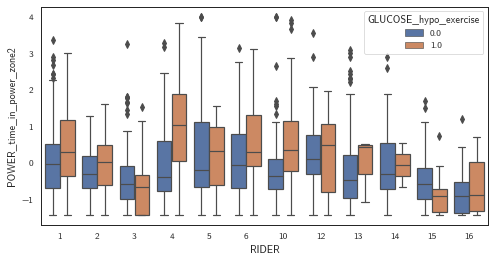

GLUCOSE_hypo_exercise~1+POWER_time_in_power_zone2+(1+POWER_time_in_power_zone2|RIDER)



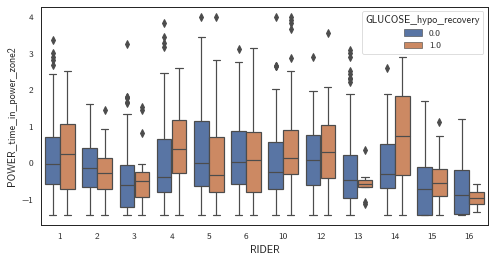

GLUCOSE_hypo_recovery~1+POWER_time_in_power_zone2+(1+POWER_time_in_power_zone2|RIDER)



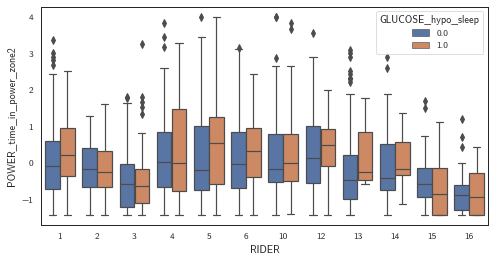

GLUCOSE_hypo_sleep~1+POWER_time_in_power_zone2+(1+POWER_time_in_power_zone2|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1598.9  1626.3 -794.5   1588.9     1773   1700.1  1727.5 -845.1   1690.1   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1911.2  1938.5 -950.6   1901.2     1753

exercise                                recovery                          \
       Min      1Q Median      3Q     Max      Min      1Q  Median      3Q   
0  -3.5746 -0.5109  -0.33 -0.1484  6.9453  -1.7545 -0.4724 -0.3949 -0.1688   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  7.7016 -1.1367 -0.7057 -0.4136  0.8895  4.3645

exercise                 recovery           \
                                  Variance Std.Dev.  Corr  Variance Std.Dev.   
Groups Name                                                                    
RIDER  (Intercept)                1.369000   1.1700   NaN  1.360400   1.1664   
       POWER_time_in_power_zone2   0.08311   0.2883  0.76    0.0339   0.1841   

                                          sleep                
                                 Corr  Variance Std.Dev. Corr  
Groups Name                                                    
RIDER  (Intercept)                NaN  0.716945   0.8467  NaN  
       POWER_time_in_power_zone2  1.0  0.008969   0.0947 -1.0

exercise                                  \
                                 Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                     
Intercept                           -1.61    -2.29    -0.92     0.00  ***   
Time in power zone 2 (Endurance)     0.21    -0.02     0.44     0.08    .   

                                 recovery                                  \
                                 Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                     
Intercept                           -1.35    -2.03    -0.66     0.00  ***   
Time in power zone 2 (Endurance)     0.01    -0.16     0.18     0.91        

                                    sleep                                  
                                 Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                    
Intercept                           -1.03    -1.52    -0.53     0.00  ***  
Time in power zone 2 (Endurance)     0.12     0.00     0.24     0.04    *

HYPO
binomial: hypo ~ POWER_time_in_power_zone3


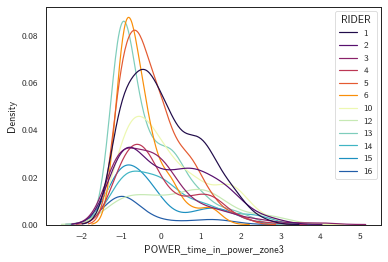

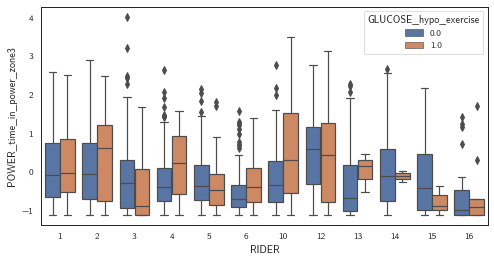

GLUCOSE_hypo_exercise~1+POWER_time_in_power_zone3+(1+POWER_time_in_power_zone3|RIDER)



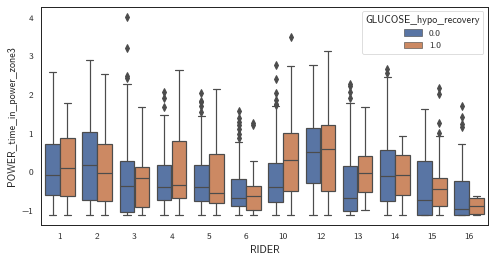

GLUCOSE_hypo_recovery~1+POWER_time_in_power_zone3+(1+POWER_time_in_power_zone3|RIDER)



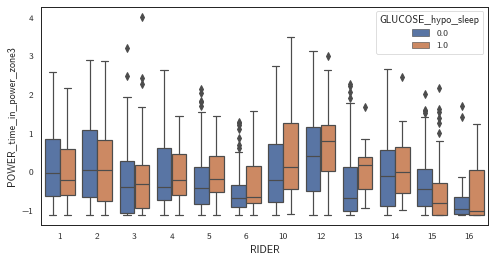

GLUCOSE_hypo_sleep~1+POWER_time_in_power_zone3+(1+POWER_time_in_power_zone3|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1620.0  1647.4 -805.0   1610.0     1773   1702.1  1729.5 -846.1   1692.1   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1908.2  1935.6 -949.1   1898.2     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -2.0099 -0.5333 -0.3397 -0.1376  7.6801  -1.5595 -0.4746 -0.3862 -0.1841   

            sleep                                 
      Max     Min      1Q  Median     3Q     Max  
0  5.4537 -1.1928 -0.6921 -0.4101  0.895  4.9126

exercise                 recovery           \
                                  Variance Std.Dev.  Corr  Variance Std.Dev.   
Groups Name                                                                    
RIDER  (Intercept)                1.393700   1.1806   NaN  1.318820   1.1484   
       POWER_time_in_power_zone3   0.07721   0.2779  0.93   0.01828   0.1352   

                                           sleep                
                                  Corr  Variance Std.Dev. Corr  
Groups Name                                                     
RIDER  (Intercept)                 NaN  0.657010   0.8106  NaN  
       POWER_time_in_power_zone3  0.77   0.03093   0.1759 -1.0

exercise                                  \
                             Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                 
Intercept                       -1.61     -2.3    -0.91     0.00  ***   
Time in power zone 3 (Tempo)     0.04     -0.2     0.28     0.76        

                             recovery                                  \
                             Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                 
Intercept                       -1.34    -2.01    -0.67      0.0  ***   
Time in power zone 3 (Tempo)     0.06    -0.11     0.23      0.5        

                                sleep                                  
                             Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                
Intercept                       -1.00    -1.48    -0.53     0.00  ***  
Time in power zone 3 (Tempo)     0.17     0.01     0.33     0.04    *

HYPO
binomial: hypo ~ POWER_time_in_power_zone4


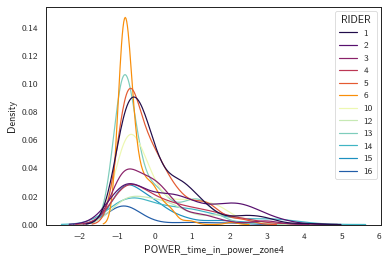

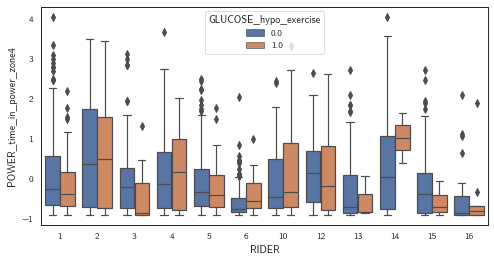

GLUCOSE_hypo_exercise~1+POWER_time_in_power_zone4+(1+POWER_time_in_power_zone4|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



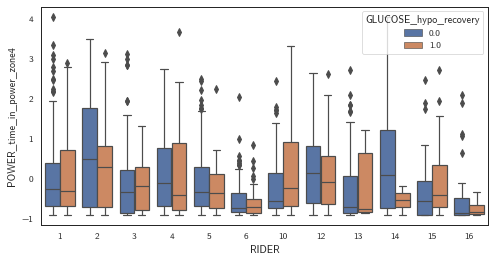

GLUCOSE_hypo_recovery~1+POWER_time_in_power_zone4+(1+POWER_time_in_power_zone4|RIDER)



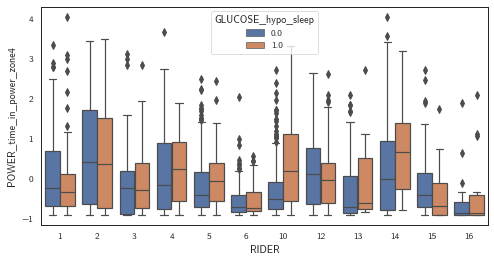

GLUCOSE_hypo_sleep~1+POWER_time_in_power_zone4+(1+POWER_time_in_power_zone4|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1632.1  1659.6 -811.1   1622.1     1773   1704.2  1731.6 -847.1   1694.2   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1907.9  1935.3 -949.0   1897.9     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -1.2524 -0.5338 -0.3486 -0.1326  7.3781  -1.4921 -0.4784 -0.3922 -0.1617   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  5.1623 -1.1639 -0.6977 -0.4118  0.8929  4.5596

exercise                recovery           \
                                  Variance Std.Dev. Corr  Variance Std.Dev.   
Groups Name                                                                   
RIDER  (Intercept)                1.418320   1.1909  NaN  1.362540    1.167   
       POWER_time_in_power_zone4   0.02655   0.1629  1.0   0.02249    0.150   

                                           sleep                 
                                  Corr  Variance Std.Dev.  Corr  
Groups Name                                                      
RIDER  (Intercept)                 NaN  0.694230   0.8332   NaN  
       POWER_time_in_power_zone4  0.94   0.04607   0.2146 -0.56

exercise                             \
                                         Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                        
Intercept                                   -1.59    -2.29    -0.90     0.00   
Time in power zone 4 (Lactate Threshold)    -0.12    -0.32     0.08     0.25   

                                              recovery                    \
                                         Sign Estimate CI_lower CI_upper   
Feature                                                                    
Intercept                                 ***    -1.35    -2.03    -0.67   
Time in power zone 4 (Lactate Threshold)         -0.02    -0.19     0.16   

                                                          sleep           \
                                         Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                    
Intercept                                    0.00  ***    -1.02    -1.51   
Time in power zone 4 (Lactate Threshold)     0.86          0.13    -0.05   

                                                                 
                                         CI_upper Pr(>|z|) Sign  
Feature                                                          
Intercept                                   -0.53     0.00  ***  
Time in power zone 4 (Lactate Threshold)     0.31     0.14

HYPO
binomial: hypo ~ POWER_time_in_power_zone5


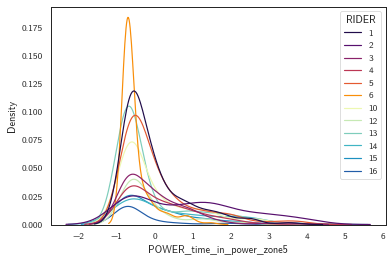

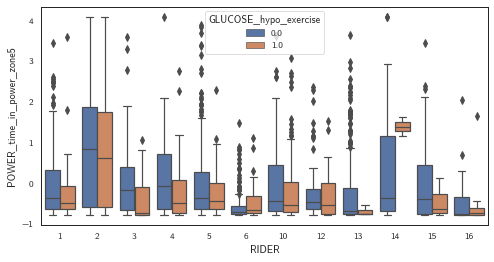

GLUCOSE_hypo_exercise~1+POWER_time_in_power_zone5+(1+POWER_time_in_power_zone5|RIDER)



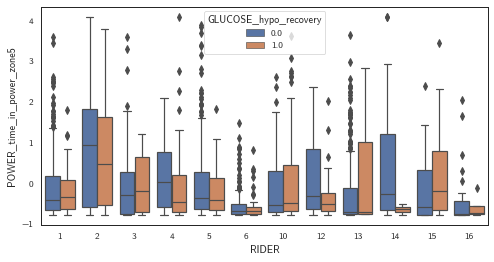

GLUCOSE_hypo_recovery~1+POWER_time_in_power_zone5+(1+POWER_time_in_power_zone5|RIDER)



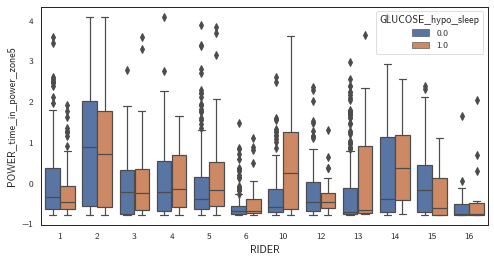

GLUCOSE_hypo_sleep~1+POWER_time_in_power_zone5+(1+POWER_time_in_power_zone5|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1625.1  1652.5 -807.6   1615.1     1773   1706.2  1733.6 -848.1   1696.2   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1897.1  1924.4 -943.5   1887.1     1753

exercise                               recovery                          \
       Min      1Q  Median      3Q   Max      Min      1Q  Median      3Q   
0  -1.1467 -0.5341 -0.3523 -0.1356  6.77  -1.2765 -0.4803 -0.3979 -0.1775   

            sleep                                 
      Max     Min      1Q  Median      3Q    Max  
0  4.9648 -1.5313 -0.6289 -0.4065  0.8846  4.603

exercise                 recovery           \
                                  Variance Std.Dev.  Corr  Variance Std.Dev.   
Groups Name                                                                    
RIDER  (Intercept)                1.431699  1.19654   NaN  1.353580   1.1634   
       POWER_time_in_power_zone5  0.006013  0.07755  0.81   0.01406   0.1186   

                                           sleep                 
                                  Corr  Variance Std.Dev.  Corr  
Groups Name                                                      
RIDER  (Intercept)                 NaN  0.709600   0.8424   NaN  
       POWER_time_in_power_zone5  0.15    0.1107   0.3326 -0.39

exercise                                  \
                              Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                  
Intercept                        -1.60    -2.30    -0.90     0.00  ***   
Time in power zone 5 (VO2max)    -0.26    -0.46    -0.05     0.01    *   

                              recovery                                  \
                              Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                  
Intercept                        -1.34    -2.01    -0.66     0.00  ***   
Time in power zone 5 (VO2max)    -0.07    -0.24     0.10     0.41        

                                 sleep                                  
                              Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                 
Intercept                        -1.02    -1.52    -0.53      0.0  ***  
Time in power zone 5 (VO2max)     0.08    -0.15     0.32      0.5

HYPO
binomial: hypo ~ POWER_time_in_power_zone6


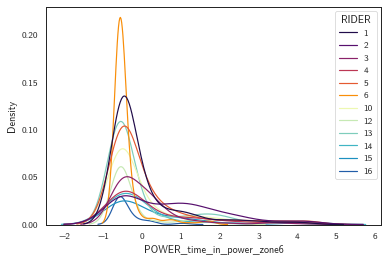

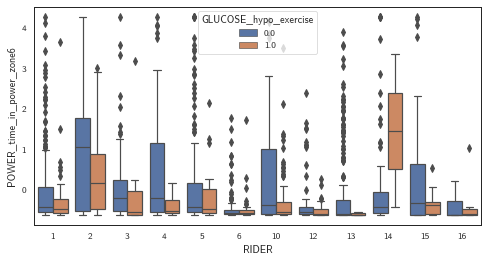

GLUCOSE_hypo_exercise~1+POWER_time_in_power_zone6+(1+POWER_time_in_power_zone6|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



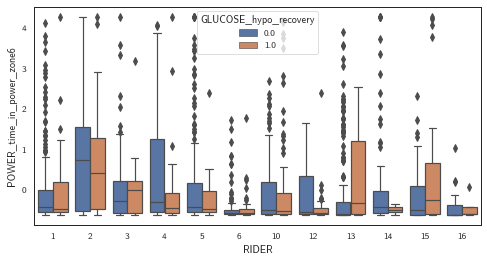

GLUCOSE_hypo_recovery~1+POWER_time_in_power_zone6+(1+POWER_time_in_power_zone6|RIDER)



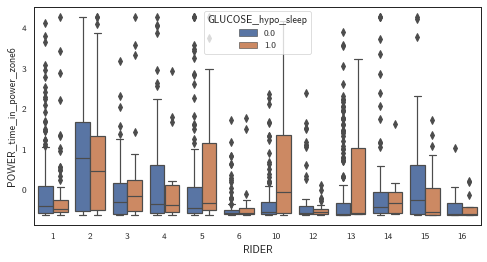

GLUCOSE_hypo_sleep~1+POWER_time_in_power_zone6+(1+POWER_time_in_power_zone6|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1588.3  1615.7 -789.2   1578.3     1773   1701.9  1729.3 -846.0   1691.9   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1896.0  1923.4 -943.0   1886.0     1753

exercise                                recovery                         \
       Min      1Q  Median     3Q     Max      Min     1Q  Median      3Q   
0  -1.2851 -0.5277 -0.3458 -0.149  7.2074  -1.3261 -0.478 -0.4064 -0.1952   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  5.1075 -1.4961 -0.6313 -0.3993  0.8887  4.3154

exercise                recovery           \
                                  Variance Std.Dev. Corr  Variance Std.Dev.   
Groups Name                                                                   
RIDER  (Intercept)                1.460960   1.2087  NaN  1.333800   1.1549   
       POWER_time_in_power_zone6   0.02596   0.1611 -1.0    0.0653   0.2555   

                                           sleep                 
                                  Corr  Variance Std.Dev.  Corr  
Groups Name                                                      
RIDER  (Intercept)                 NaN  0.704700   0.8394   NaN  
       POWER_time_in_power_zone6 -0.32    0.1167   0.3417 -0.21

exercise                             \
                                          Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                         
Intercept                                    -1.60    -2.31    -0.90      0.0   
Time in power zone 6 (Anaerobic Capacity)    -0.39    -0.61    -0.17      0.0   

                                               recovery                    \
                                          Sign Estimate CI_lower CI_upper   
Feature                                                                     
Intercept                                  ***    -1.34    -2.02    -0.67   
Time in power zone 6 (Anaerobic Capacity)  ***    -0.07    -0.29     0.14   

                                                           sleep           \
                                          Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                     
Intercept                                     0.00  ***    -1.04    -1.53   
Time in power zone 6 (Anaerobic Capacity)     0.49          0.02    -0.23   

                                                                  
                                          CI_upper Pr(>|z|) Sign  
Feature                                                           
Intercept                                    -0.54     0.00  ***  
Time in power zone 6 (Anaerobic Capacity)     0.27     0.87

HYPO
binomial: hypo ~ HR_heart_rate_mean


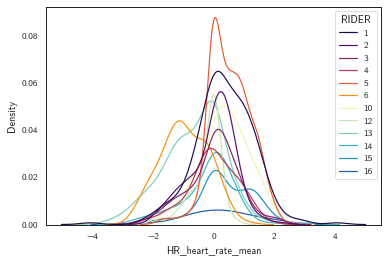

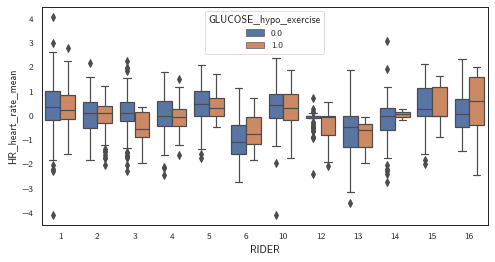

GLUCOSE_hypo_exercise~1+HR_heart_rate_mean+(1+HR_heart_rate_mean|RIDER)



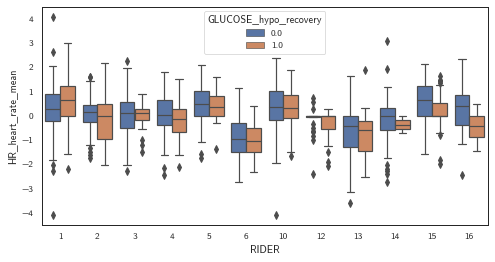

GLUCOSE_hypo_recovery~1+HR_heart_rate_mean+(1+HR_heart_rate_mean|RIDER)



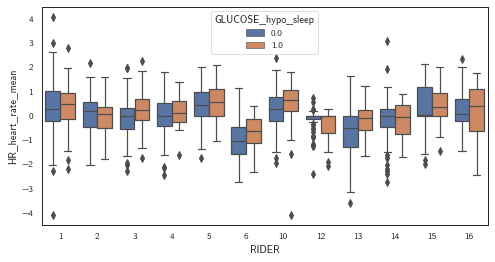

GLUCOSE_hypo_sleep~1+HR_heart_rate_mean+(1+HR_heart_rate_mean|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1633.2  1660.6 -811.6   1623.2     1773   1702.3  1729.7 -846.1   1692.3   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1909.7  1937.0 -949.8   1899.7     1753

exercise                                 recovery                         \
       Min      1Q  Median      3Q     Max      Min      1Q  Median     3Q   
0  -1.2938 -0.5359 -0.3389 -0.1462  6.8335  -1.7453 -0.4826 -0.3973 -0.193   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  5.1803 -1.1438 -0.7099 -0.4257  0.8906  5.2975

exercise                 recovery                 \
                           Variance Std.Dev.  Corr  Variance Std.Dev.  Corr   
Groups Name                                                                   
RIDER  (Intercept)         1.408870   1.1870   NaN  1.360420   1.1664   NaN   
       HR_heart_rate_mean   0.04143   0.2035 -0.07   0.04726   0.2174 -0.39   

                              sleep                
                           Variance Std.Dev. Corr  
Groups Name                                        
RIDER  (Intercept)         0.649050   0.8056  NaN  
       HR_heart_rate_mean   0.01756   0.1325 -1.0

exercise                                 recovery           \
           Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                 
Intercept     -1.56    -2.26    -0.87     0.00  ***    -1.34    -2.02   
Heart rate    -0.08    -0.29     0.14     0.47         -0.13    -0.34   

                                     sleep                                  
           CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                     
Intercept     -0.65     0.00  ***    -1.01    -1.48    -0.53     0.00  ***  
Heart rate     0.08     0.21          0.19     0.03     0.34     0.02    *

HYPO
binomial: hypo ~ HR_time_in_hr_zone1


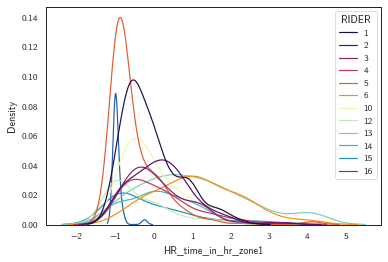

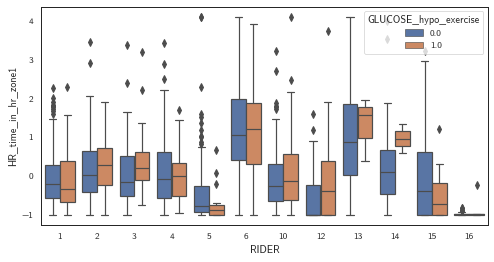

GLUCOSE_hypo_exercise~1+HR_time_in_hr_zone1+(1+HR_time_in_hr_zone1|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



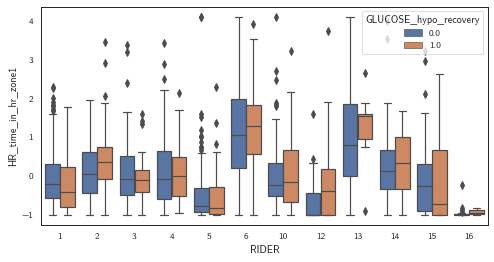

GLUCOSE_hypo_recovery~1+HR_time_in_hr_zone1+(1+HR_time_in_hr_zone1|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



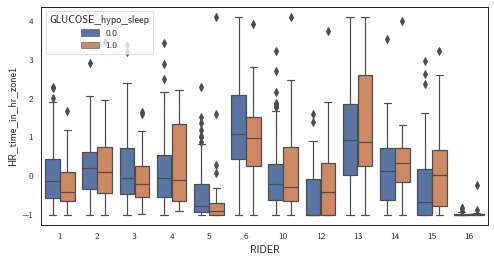

GLUCOSE_hypo_sleep~1+HR_time_in_hr_zone1+(1+HR_time_in_hr_zone1|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1632.3  1659.7 -811.1   1622.3     1773   1705.0  1732.4 -847.5   1695.0   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1914.3  1941.7 -952.2   1904.3     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -1.4651 -0.5294 -0.3326 -0.1299  7.9043  -1.4546 -0.4745 -0.3872 -0.1914   

            sleep                                 
      Max     Min      1Q Median      3Q     Max  
0  5.2637 -1.1802 -0.6898 -0.427  0.8955  4.0409

exercise                recovery                \
                            Variance Std.Dev. Corr  Variance Std.Dev. Corr   
Groups Name                                                                  
RIDER  (Intercept)          1.271300   1.1275  NaN  1.361166  1.16669  NaN   
       HR_time_in_hr_zone1   0.02228   0.1493  1.0  0.003042  0.05516  1.0   

                               sleep                 
                            Variance Std.Dev.  Corr  
Groups Name                                          
RIDER  (Intercept)          0.713530   0.8447   NaN  
       HR_time_in_hr_zone1   0.04157   0.2039 -0.03

exercise                                  \
                                    Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                        
Intercept                              -1.54    -2.20    -0.88      0.0  ***   
Time in HR zone 1 (Active Recovery)    -0.02    -0.21     0.16      0.8        

                                    recovery                                  \
                                    Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                        
Intercept                              -1.33    -2.01    -0.65     0.00  ***   
Time in HR zone 1 (Active Recovery)     0.07    -0.07     0.22     0.32        

                                       sleep                                  
                                    Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                       
Intercept                              -1.01    -1.51    -0.52     0.00  ***  
Time in HR zone 1 (Active Recovery)     0.01    -0.17     0.18     0.94

HYPO
binomial: hypo ~ HR_time_in_hr_zone2


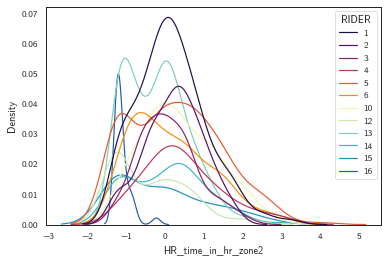

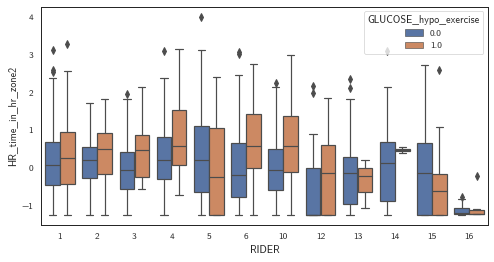

GLUCOSE_hypo_exercise~1+HR_time_in_hr_zone2+(1+HR_time_in_hr_zone2|RIDER)



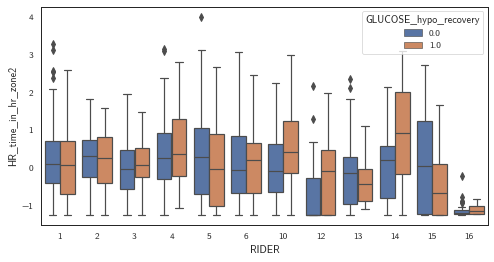

GLUCOSE_hypo_recovery~1+HR_time_in_hr_zone2+(1+HR_time_in_hr_zone2|RIDER)



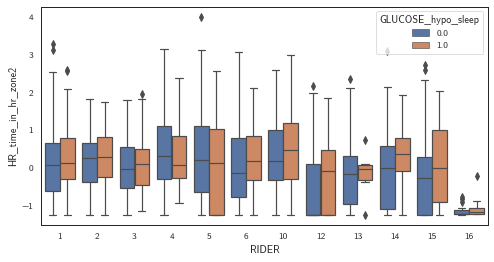

GLUCOSE_hypo_sleep~1+HR_time_in_hr_zone2+(1+HR_time_in_hr_zone2|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1590.4  1617.8 -790.2   1580.4     1773   1692.4  1719.8 -841.2   1682.4   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1910.0  1937.3 -950.0   1900.0     1753

exercise                                recovery                          \
       Min      1Q  Median      3Q    Max      Min      1Q  Median      3Q   
0  -2.1553 -0.5246 -0.3211 -0.1399  7.132   -2.216 -0.4759 -0.3995 -0.1915   

            sleep                                 
      Max     Min      1Q  Median     3Q     Max  
0  5.6612 -1.4034 -0.6926 -0.4163  0.891  4.1493

exercise                recovery                 \
                            Variance Std.Dev. Corr  Variance Std.Dev.  Corr   
Groups Name                                                                   
RIDER  (Intercept)          1.414400   1.1893  NaN  1.359300   1.1659   NaN   
       HR_time_in_hr_zone2    0.1154   0.3397  0.9    0.0913   0.3022  0.52   

                               sleep                
                            Variance Std.Dev. Corr  
Groups Name                                         
RIDER  (Intercept)          0.718830   0.8478  NaN  
       HR_time_in_hr_zone2   0.01178   0.1085  1.0

exercise                                  \
                              Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                  
Intercept                        -1.59    -2.29    -0.89     0.00  ***   
Time in HR zone 2 (Endurance)     0.29     0.03     0.54     0.03    *   

                              recovery                                  \
                              Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                  
Intercept                        -1.34    -2.03    -0.66     0.00  ***   
Time in HR zone 2 (Endurance)     0.05    -0.19     0.29     0.67        

                                 sleep                                  
                              Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                 
Intercept                        -1.01    -1.51    -0.51     0.00  ***  
Time in HR zone 2 (Endurance)     0.14    -0.00     0.27     0.05    .

HYPO
binomial: hypo ~ HR_time_in_hr_zone3


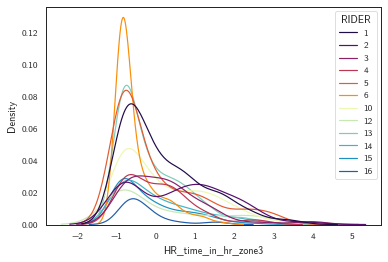

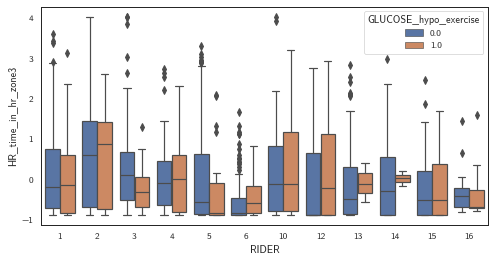

GLUCOSE_hypo_exercise~1+HR_time_in_hr_zone3+(1+HR_time_in_hr_zone3|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



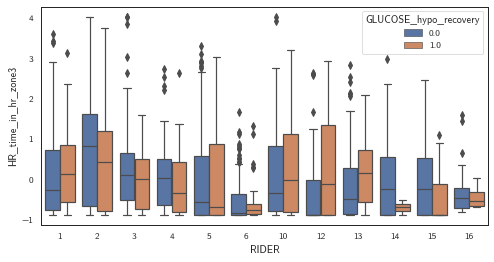

GLUCOSE_hypo_recovery~1+HR_time_in_hr_zone3+(1+HR_time_in_hr_zone3|RIDER)



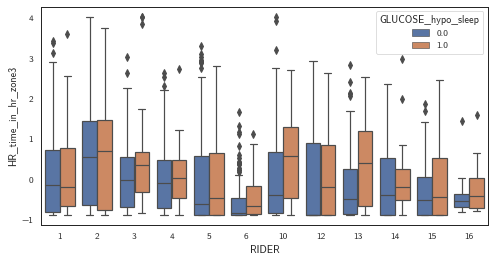

GLUCOSE_hypo_sleep~1+HR_time_in_hr_zone3+(1+HR_time_in_hr_zone3|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1633.0  1660.4 -811.5   1623.0     1773   1706.1  1733.5 -848.1   1696.1   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1909.5  1936.8 -949.7   1899.5     1753

exercise                                recovery                         \
       Min      1Q Median      3Q     Max      Min      1Q Median      3Q   
0   -1.306 -0.5356 -0.343 -0.1393  7.3508  -1.5193 -0.4799 -0.386 -0.1872   

            sleep                                
      Max     Min      1Q Median      3Q    Max  
0  5.1026 -1.2131 -0.6813 -0.414  0.8954  4.676

exercise                recovery                \
                            Variance Std.Dev. Corr  Variance Std.Dev. Corr   
Groups Name                                                                  
RIDER  (Intercept)          1.404470   1.1851  NaN  1.349910   1.1619  NaN   
       HR_time_in_hr_zone3   0.01422   0.1192  1.0   0.02476   0.1574  0.1   

                               sleep                
                            Variance Std.Dev. Corr  
Groups Name                                         
RIDER  (Intercept)          0.685700   0.8281  NaN  
       HR_time_in_hr_zone3   0.01235   0.1111 -0.7

exercise                                 recovery  \
                          Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate   
Feature                                                                       
Intercept                    -1.58    -2.28    -0.89     0.00  ***    -1.34   
Time in HR zone 3 (Tempo)    -0.07    -0.25     0.10     0.43         -0.01   

                                                             sleep           \
                          CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                       
Intercept                    -2.01    -0.66     0.00  ***    -1.02    -1.51   
Time in HR zone 3 (Tempo)    -0.19     0.16     0.87          0.17     0.04   

                                                  
                          CI_upper Pr(>|z|) Sign  
Feature                                           
Intercept                    -0.54     0.00  ***  
Time in HR zone 3 (Tempo)     0.31     0.01    *

HYPO
binomial: hypo ~ HR_time_in_hr_zone4


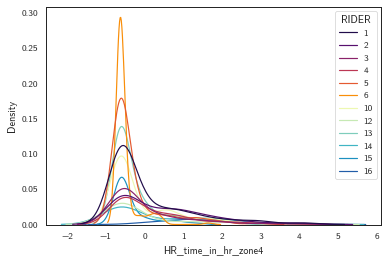

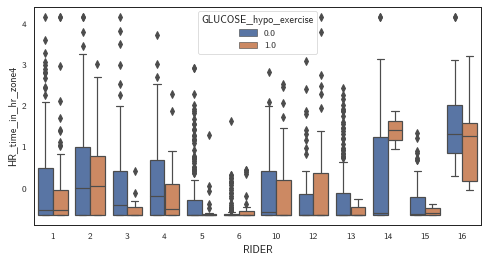

GLUCOSE_hypo_exercise~1+HR_time_in_hr_zone4+(1+HR_time_in_hr_zone4|RIDER)



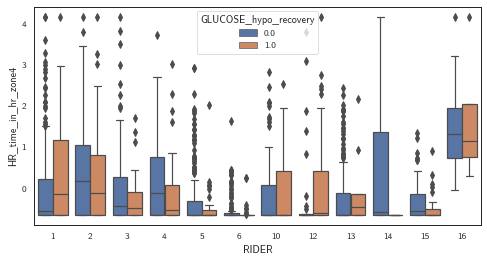

GLUCOSE_hypo_recovery~1+HR_time_in_hr_zone4+(1+HR_time_in_hr_zone4|RIDER)



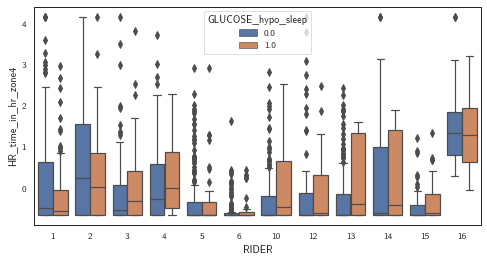

GLUCOSE_hypo_sleep~1+HR_time_in_hr_zone4+(1+HR_time_in_hr_zone4|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1631.5  1658.9 -810.7   1621.5     1773   1705.5  1732.9 -847.8   1695.5   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1909.2  1936.5 -949.6   1899.2     1753

exercise                                recovery                          \
       Min      1Q  Median     3Q     Max      Min      1Q  Median      3Q   
0  -1.0858 -0.5479 -0.3366 -0.143  6.7964  -1.3986 -0.4826 -0.3942 -0.1712   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  4.8516 -1.2511 -0.7001 -0.4094  0.8719  4.6419

exercise                 recovery                 \
                            Variance Std.Dev.  Corr  Variance Std.Dev.  Corr   
Groups Name                                                                    
RIDER  (Intercept)          1.443813  1.20159   NaN  1.350900   1.1623   NaN   
       HR_time_in_hr_zone4  0.008393  0.09162  0.97    0.0308   0.1755  0.13   

                               sleep                 
                            Variance Std.Dev.  Corr  
Groups Name                                          
RIDER  (Intercept)          0.726100   0.8521   NaN  
       HR_time_in_hr_zone4   0.05008   0.2238 -0.84

exercise                             \
                                      Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                     
Intercept                                -1.58    -2.28    -0.88     0.00   
Time in HR zone 4 (Lactate Threshold)    -0.17    -0.41     0.06     0.14   

                                           recovery                    \
                                      Sign Estimate CI_lower CI_upper   
Feature                                                                 
Intercept                              ***    -1.34    -2.02    -0.66   
Time in HR zone 4 (Lactate Threshold)         -0.09    -0.30     0.13   

                                                       sleep           \
                                      Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                 
Intercept                                 0.00  ***    -0.99    -1.50   
Time in HR zone 4 (Lactate Threshold)     0.42          0.08    -0.11   

                                                              
                                      CI_upper Pr(>|z|) Sign  
Feature                                                       
Intercept                                -0.49     0.00  ***  
Time in HR zone 4 (Lactate Threshold)     0.26     0.41

HYPO
binomial: hypo ~ HR_time_in_hr_zone5


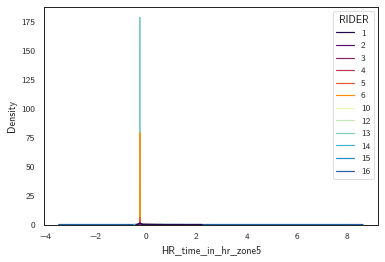

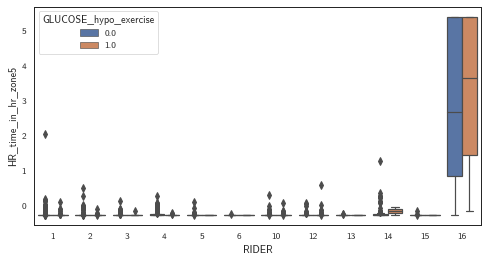

GLUCOSE_hypo_exercise~1+HR_time_in_hr_zone5+(1+HR_time_in_hr_zone5|RIDER)



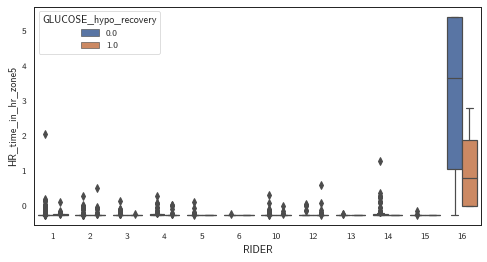

GLUCOSE_hypo_recovery~1+HR_time_in_hr_zone5+(1+HR_time_in_hr_zone5|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



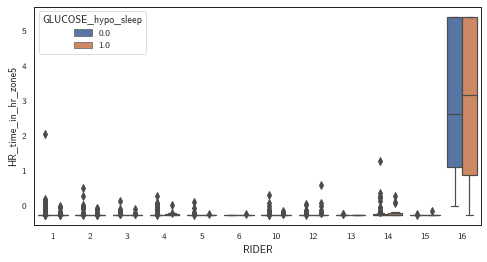

GLUCOSE_hypo_sleep~1+HR_time_in_hr_zone5+(1+HR_time_in_hr_zone5|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1631.4  1658.8 -810.7   1621.4     1773   1701.2  1728.6 -845.6   1691.2   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1917.0  1944.4 -953.5   1907.0     1753

exercise                                recovery                          \
       Min      1Q  Median     3Q     Max      Min      1Q  Median      3Q   
0  -1.0956 -0.5455 -0.3272 -0.147  6.8019  -1.2462 -0.4798 -0.3854 -0.1955   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  5.0987 -1.1536 -0.7065 -0.4253  0.8668  4.0066

exercise                 recovery                \
                            Variance Std.Dev.  Corr  Variance Std.Dev. Corr   
Groups Name                                                                   
RIDER  (Intercept)          1.468000    1.212   NaN  1.204140   1.0973  NaN   
       HR_time_in_hr_zone5     9.172    3.029  0.33   0.07854   0.2802 -1.0   

                               sleep                 
                            Variance Std.Dev.  Corr  
Groups Name                                          
RIDER  (Intercept)          0.373400   0.6111   NaN  
       HR_time_in_hr_zone5    2.4954   1.5797 -0.34

exercise                             \
                                       Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                      
Intercept                                 -2.23    -3.28    -1.18     0.00   
Time in HR zone 5 (Anaerobic Capacity)    -2.60    -6.28     1.09     0.17   

                                            recovery                    \
                                       Sign Estimate CI_lower CI_upper   
Feature                                                                  
Intercept                               ***    -1.35    -2.00    -0.69   
Time in HR zone 5 (Anaerobic Capacity)         -0.51    -1.18     0.17   

                                                        sleep           \
                                       Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                  
Intercept                                  0.00  ***    -1.17    -1.73   
Time in HR zone 5 (Anaerobic Capacity)     0.14         -0.48    -2.53   

                                                               
                                       CI_upper Pr(>|z|) Sign  
Feature                                                        
Intercept                                 -0.61     0.00  ***  
Time in HR zone 5 (Anaerobic Capacity)     1.56     0.64

HYPO
binomial: hypo ~ CALENDAR_race


/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


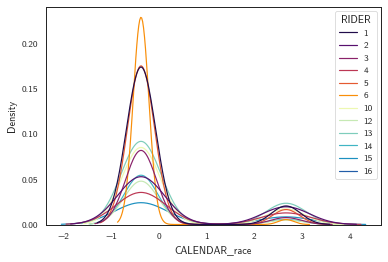

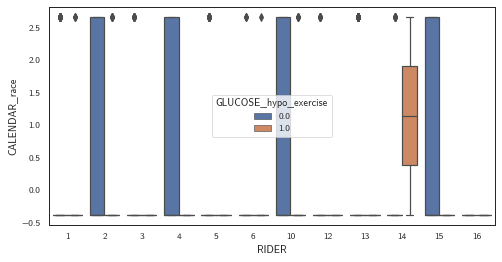

GLUCOSE_hypo_exercise~1+CALENDAR_race+(1+CALENDAR_race|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



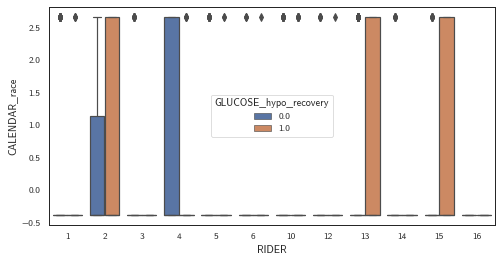

GLUCOSE_hypo_recovery~1+CALENDAR_race+(1+CALENDAR_race|RIDER)



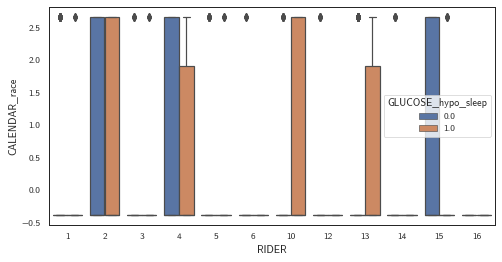

GLUCOSE_hypo_sleep~1+CALENDAR_race+(1+CALENDAR_race|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1562.4  1589.8 -776.2   1552.4     1773   1693.7  1721.1 -841.8   1683.7   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1902.7  1930.0 -946.3   1892.7     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -1.2633 -0.5178 -0.3398 -0.1575  9.3918   -1.338 -0.4783 -0.3873 -0.1886   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  5.3015 -1.1695 -0.6172 -0.4138  0.8842  4.1469

exercise                recovery                 \
                      Variance Std.Dev. Corr  Variance Std.Dev.  Corr   
Groups Name                                                             
RIDER  (Intercept)    1.470440   1.2126  NaN  1.417520   1.1906   NaN   
       CALENDAR_race   0.01395   0.1181 -1.0   0.05992   0.2448 -0.75   

                         sleep                 
                      Variance Std.Dev.  Corr  
Groups Name                                    
RIDER  (Intercept)    0.712600   0.8442   NaN  
       CALENDAR_race   0.08819   0.2970 -0.17

exercise                                 recovery           \
            Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                  
Intercept      -1.62    -2.33    -0.91      0.0  ***    -1.34    -2.03   
Competition    -0.55    -0.80    -0.29      0.0  ***    -0.08    -0.29   

                                      sleep                                  
            CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                      
Intercept      -0.64     0.00  ***    -1.05    -1.55    -0.55     0.00  ***  
Competition     0.13     0.44         -0.09    -0.32     0.15     0.47

HYPO
binomial: hypo ~ TIME_duration


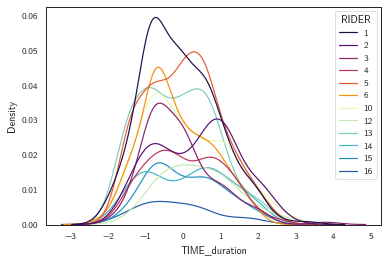

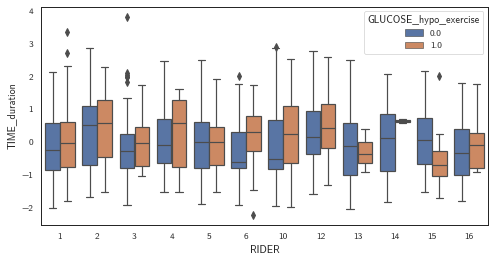

GLUCOSE_hypo_exercise~1+TIME_duration+(1+TIME_duration|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



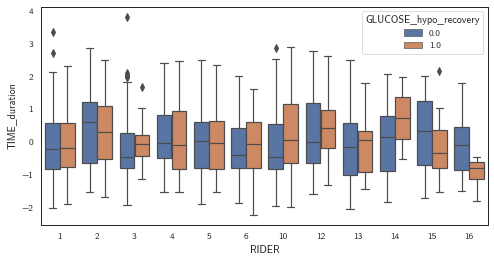

GLUCOSE_hypo_recovery~1+TIME_duration+(1+TIME_duration|RIDER)



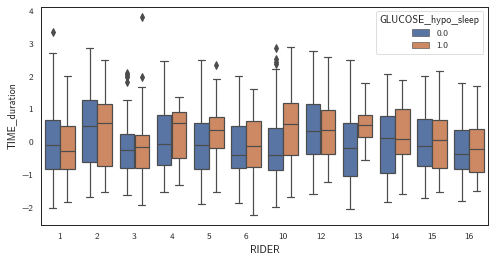

GLUCOSE_hypo_sleep~1+TIME_duration+(1+TIME_duration|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1620.4  1647.8 -805.2   1610.4     1773   1705.1  1732.5 -847.5   1695.1   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1903.3  1930.7 -946.7   1893.3     1753

exercise                                 recovery                         \
       Min      1Q  Median      3Q     Max      Min      1Q Median      3Q   
0  -1.7627 -0.5333 -0.3428 -0.1445  6.8798   -1.485 -0.4774 -0.387 -0.1858   

            sleep                                 
      Max     Min      1Q  Median     3Q     Max  
0  5.7064 -1.1554 -0.7127 -0.4137  0.902  4.7895

exercise                recovery                 \
                      Variance Std.Dev. Corr  Variance Std.Dev.  Corr   
Groups Name                                                             
RIDER  (Intercept)    1.337420   1.1565  NaN  1.322108  1.14983   NaN   
       TIME_duration   0.01574   0.1255  1.0  0.008767  0.09363  0.91   

                         sleep                 
                      Variance Std.Dev.  Corr  
Groups Name                                    
RIDER  (Intercept)    0.735120   0.8574   NaN  
       TIME_duration   0.04516   0.2125 -0.78

exercise                                 recovery                    \
          Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper   
Feature                                                                         
Intercept    -1.59    -2.27    -0.91     0.00  ***    -1.34    -2.01    -0.67   
Duration      0.16    -0.01     0.32     0.06    .     0.02    -0.12     0.17   

                           sleep                                  
          Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                           
Intercept     0.00  ***    -1.04    -1.54    -0.54     0.00  ***  
Duration      0.76          0.17     0.00     0.35     0.05    *

HYPO
binomial: hypo ~ POWER_chronic_training_load


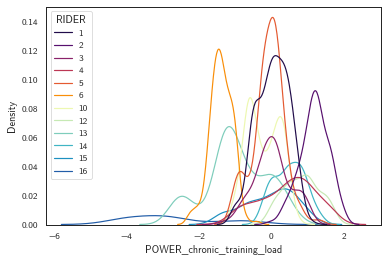

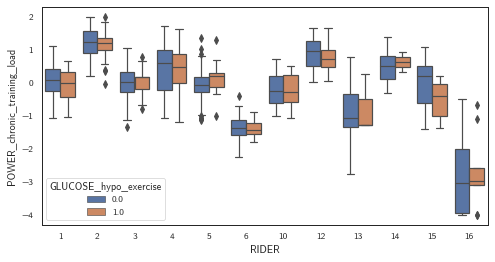

GLUCOSE_hypo_exercise~1+POWER_chronic_training_load+(1+POWER_chronic_training_load|RIDER)



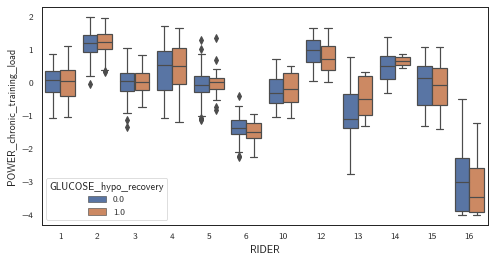

GLUCOSE_hypo_recovery~1+POWER_chronic_training_load+(1+POWER_chronic_training_load|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



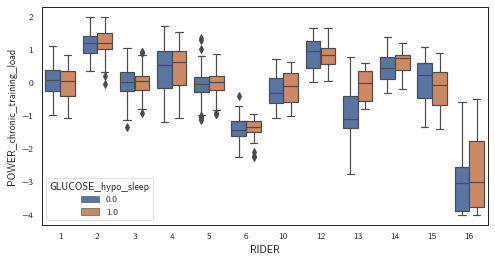

GLUCOSE_hypo_sleep~1+POWER_chronic_training_load+(1+POWER_chronic_training_load|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1633.0  1660.4 -811.5   1623.0     1773   1705.1  1732.5 -847.6   1695.1   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1908.9  1936.2 -949.4   1898.9     1753

exercise                                recovery                         \
       Min      1Q  Median      3Q    Max      Min     1Q  Median      3Q   
0  -1.1831 -0.5328 -0.3255 -0.1386  7.191   -1.318 -0.482 -0.3915 -0.1637   

           sleep                                  
      Max    Min      1Q  Median      3Q     Max  
0  5.0648 -1.195 -0.7181 -0.4326  0.9084  4.4442

exercise                 recovery  \
                                    Variance Std.Dev.  Corr  Variance   
Groups Name                                                             
RIDER  (Intercept)                  1.436200   1.1984   NaN  1.340610   
       POWER_chronic_training_load   0.02853   0.1689 -0.78   0.03471   

                                                     sleep                 
                                   Std.Dev. Corr  Variance Std.Dev.  Corr  
Groups Name                                                                
RIDER  (Intercept)                   1.1578  NaN  0.557100   0.7464   NaN  
       POWER_chronic_training_load   0.1863 -1.0    0.1292   0.3594 -0.65

exercise                                  \
                                Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                    
Intercept                          -1.56    -2.27    -0.85     0.00  ***   
Chronic training load (fitness)    -0.09    -0.36     0.18     0.52        

                                recovery                                  \
                                Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                    
Intercept                          -1.27    -1.95    -0.60     0.00  ***   
Chronic training load (fitness)     0.13    -0.12     0.39     0.31        

                                   sleep                                  
                                Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                   
Intercept                          -1.00    -1.45    -0.54     0.00  ***  
Chronic training load (fitness)     0.22    -0.08     0.51     0.15

HYPO
binomial: hypo ~ POWER_acute_training_load


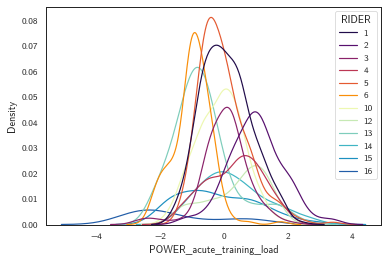

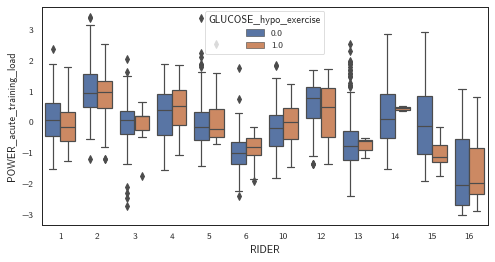

GLUCOSE_hypo_exercise~1+POWER_acute_training_load+(1+POWER_acute_training_load|RIDER)



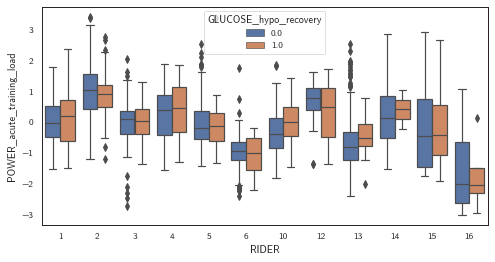

GLUCOSE_hypo_recovery~1+POWER_acute_training_load+(1+POWER_acute_training_load|RIDER)



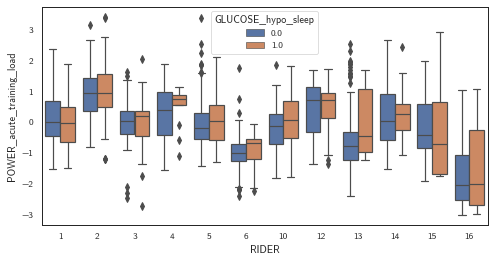

GLUCOSE_hypo_sleep~1+POWER_acute_training_load+(1+POWER_acute_training_load|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1630.9  1658.3 -810.4   1620.9     1773   1704.4  1731.8 -847.2   1694.4   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1911.5  1938.8 -950.7   1901.5     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -1.3518 -0.5355 -0.3284 -0.1445  6.8496  -1.5306 -0.4787 -0.3871 -0.1918   

           sleep                                  
     Max     Min      1Q  Median      3Q     Max  
0  5.206 -1.1551 -0.7166 -0.4225  0.9035  4.8059

exercise                 recovery           \
                                  Variance Std.Dev.  Corr  Variance Std.Dev.   
Groups Name                                                                    
RIDER  (Intercept)                1.509770   1.2287   NaN  1.376800   1.1734   
       POWER_acute_training_load   0.06427   0.2535  0.29   0.03274   0.1809   

                                           sleep                 
                                  Corr  Variance Std.Dev.  Corr  
Groups Name                                                      
RIDER  (Intercept)                 NaN  0.658540   0.8115   NaN  
       POWER_acute_training_load  0.15   0.03905   0.1976 -0.66

exercise                                  \
                              Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                  
Intercept                        -1.58     -2.3    -0.86     0.00  ***   
Acute training load (fatigue)    -0.07     -0.3     0.16     0.56        

                              recovery                                  \
                              Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                  
Intercept                        -1.32    -2.01    -0.64     0.00  ***   
Acute training load (fatigue)     0.06    -0.13     0.25     0.53        

                                 sleep                                  
                              Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                 
Intercept                        -1.01    -1.49    -0.53     0.00  ***  
Acute training load (fatigue)     0.12    -0.05     0.30     0.17

HYPO
binomial: hypo ~ POWER_training_stress_balance


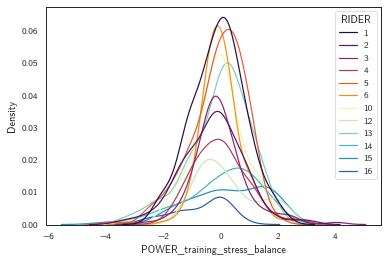

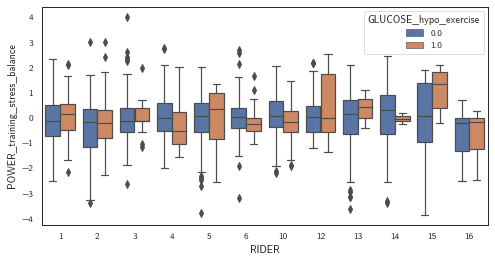

GLUCOSE_hypo_exercise~1+POWER_training_stress_balance+(1+POWER_training_stress_balance|RIDER)



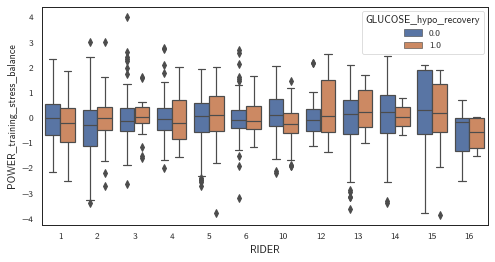

GLUCOSE_hypo_recovery~1+POWER_training_stress_balance+(1+POWER_training_stress_balance|RIDER)



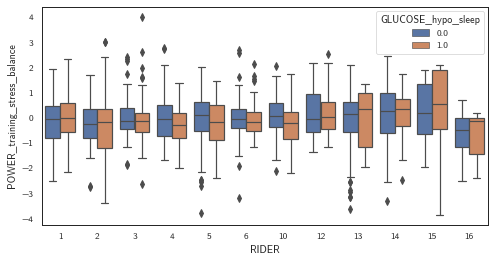

GLUCOSE_hypo_sleep~1+POWER_training_stress_balance+(1+POWER_training_stress_balance|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1628.6  1656.0 -809.3   1618.6     1773   1701.4  1728.8 -845.7   1691.4   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1915.6  1942.9 -952.8   1905.6     1753

exercise                                recovery                          \
       Min      1Q  Median      3Q    Max      Min      1Q  Median      3Q   
0    -1.51 -0.5341 -0.3365 -0.1344  7.308  -1.6953 -0.4796 -0.3919 -0.1788   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  5.3814 -1.1634 -0.7136 -0.4204  0.8972  4.3839

exercise                 recovery  \
                                      Variance Std.Dev.  Corr  Variance   
Groups Name                                                               
RIDER  (Intercept)                    1.436000    1.198   NaN  1.364150   
       POWER_training_stress_balance     0.074    0.272 -0.46   0.04665   

                                                        sleep                 
                                     Std.Dev.  Corr  Variance Std.Dev.  Corr  
Groups Name                                                                   
RIDER  (Intercept)                      1.168   NaN  0.700420   0.8369   NaN  
       POWER_training_stress_balance    0.216 -0.42   0.01617   0.1271  0.35

exercise                                  \
                               Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                   
Intercept                         -1.60    -2.31    -0.90     0.00  ***   
Training stress balance (form)     0.05    -0.18     0.27     0.67        

                               recovery                                  \
                               Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                   
Intercept                         -1.34    -2.02    -0.66     0.00  ***   
Training stress balance (form)    -0.02    -0.21     0.17     0.83        

                                  sleep                                  
                               Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                  
Intercept                         -1.02    -1.52    -0.53     0.00  ***  
Training stress balance (form)    -0.06    -0.21     0.08     0.37

HYPO
binomial: hypo ~ TIME_day_in_season


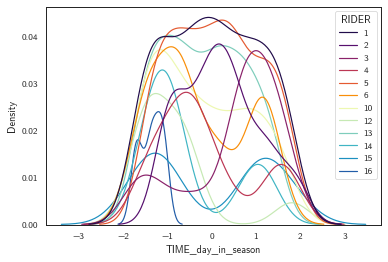

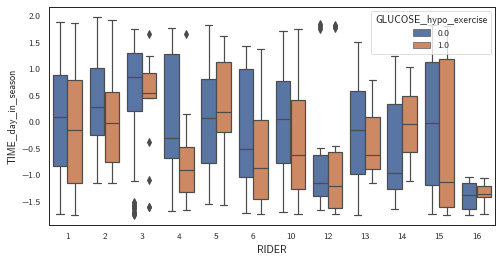

GLUCOSE_hypo_exercise~1+TIME_day_in_season+(1+TIME_day_in_season|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



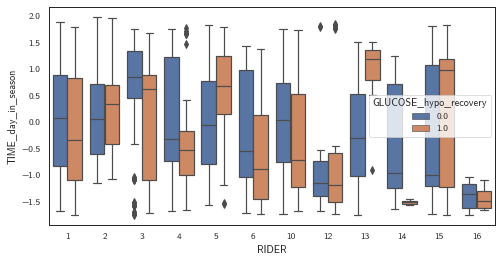

GLUCOSE_hypo_recovery~1+TIME_day_in_season+(1+TIME_day_in_season|RIDER)



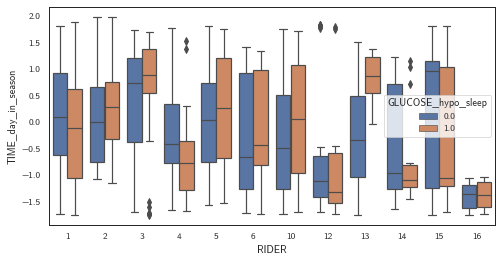

GLUCOSE_hypo_sleep~1+TIME_day_in_season+(1+TIME_day_in_season|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1612.0  1639.4 -801.0   1602.0     1773   1691.5  1718.9 -840.7   1681.5   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1907.8  1935.1 -948.9   1897.8     1753

exercise                               recovery                          \
       Min      1Q  Median     3Q    Max      Min      1Q  Median      3Q   
0  -1.5146 -0.5426 -0.3378 -0.142  7.173  -1.4167 -0.5135 -0.3906 -0.1159   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  6.9374 -1.2627 -0.6985 -0.4163  0.8996  4.2125

exercise                recovery                 \
                           Variance Std.Dev. Corr  Variance Std.Dev.  Corr   
Groups Name                                                                  
RIDER  (Intercept)         1.265470   1.1249  NaN  1.323400    1.150   NaN   
       TIME_day_in_season   0.03286   0.1813 -1.0    0.1437    0.379 -0.55   

                              sleep                 
                           Variance Std.Dev.  Corr  
Groups Name                                         
RIDER  (Intercept)         0.704500   0.8393   NaN  
       TIME_day_in_season   0.07595   0.2756 -0.48

exercise                                 recovery           \
              Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                    
Intercept        -1.63    -2.29    -0.97     0.00  ***    -1.35    -2.02   
Day in season    -0.19    -0.37    -0.01     0.04    *     0.03    -0.23   

                                        sleep                                  
              CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                        
Intercept        -0.68      0.0  ***    -1.04    -1.53    -0.54     0.00  ***  
Day in season     0.30      0.8          0.10    -0.10     0.31     0.32

HYPO
binomial: hypo ~ CALENDAR_travel_3d_any


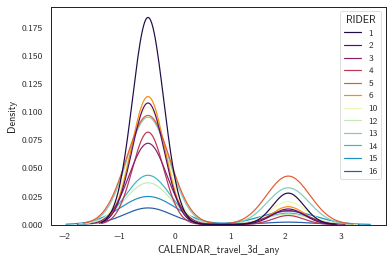

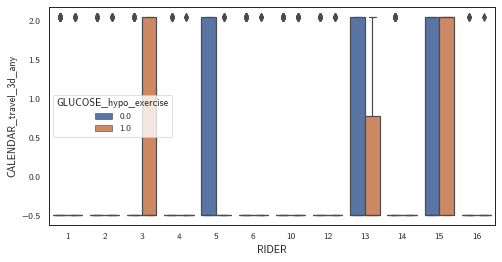

GLUCOSE_hypo_exercise~1+CALENDAR_travel_3d_any+(1+CALENDAR_travel_3d_any|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



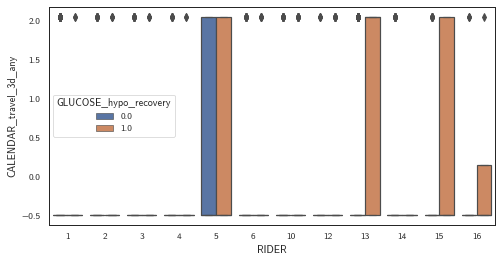

GLUCOSE_hypo_recovery~1+CALENDAR_travel_3d_any+(1+CALENDAR_travel_3d_any|RIDER)



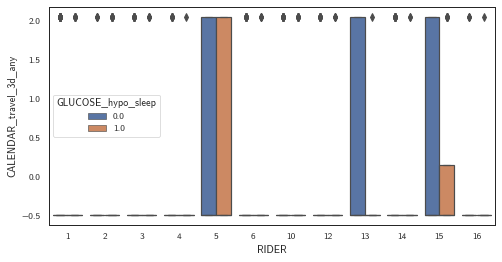

GLUCOSE_hypo_sleep~1+CALENDAR_travel_3d_any+(1+CALENDAR_travel_3d_any|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1632.2  1659.6 -811.1   1622.2     1773   1704.8  1732.2 -847.4   1694.8   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1913.1  1940.5 -951.6   1903.1     1753

exercise                                recovery                          \
       Min      1Q  Median     3Q     Max      Min      1Q  Median      3Q   
0  -1.1228 -0.5359 -0.3413 -0.139  7.1936   -1.407 -0.4668 -0.3865 -0.1898   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  5.2693 -1.1331 -0.7195 -0.4536  0.8841  5.4799

exercise                recovery           \
                               Variance Std.Dev. Corr  Variance Std.Dev.   
Groups Name                                                                
RIDER  (Intercept)             1.386860   1.1777  NaN  1.369840   1.1704   
       CALENDAR_travel_3d_any   0.01216   0.1103 -1.0   0.03308   0.1819   

                                        sleep                
                               Corr  Variance Std.Dev. Corr  
Groups Name                                                  
RIDER  (Intercept)              NaN  0.697489  0.83516  NaN  
       CALENDAR_travel_3d_any -0.15  0.007179  0.08473  1.0

exercise                                 recovery                    \
          Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper   
Feature                                                                         
Intercept    -1.59    -2.28    -0.90     0.00  ***    -1.35    -2.04    -0.67   
Travel       -0.02    -0.18     0.13     0.76          0.06    -0.12     0.23   

                           sleep                                  
          Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                           
Intercept     0.00  ***    -1.03    -1.52    -0.54     0.00  ***  
Travel        0.53         -0.13    -0.27     0.01     0.07    .

HYPO
binomial: hypo ~ LOC_temperature_mean


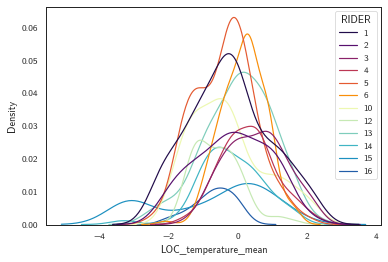

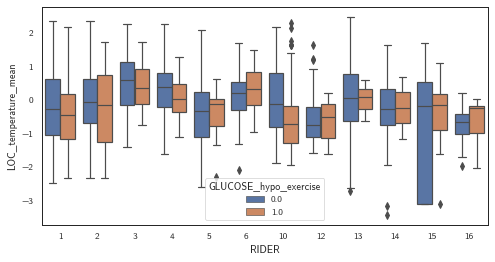

GLUCOSE_hypo_exercise~1+LOC_temperature_mean+(1+LOC_temperature_mean|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



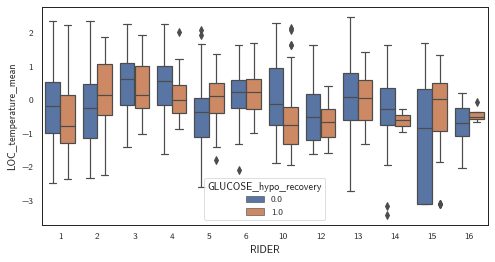

GLUCOSE_hypo_recovery~1+LOC_temperature_mean+(1+LOC_temperature_mean|RIDER)



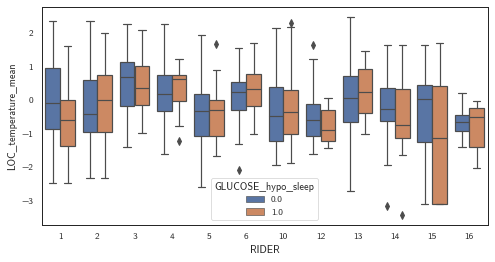

GLUCOSE_hypo_sleep~1+LOC_temperature_mean+(1+LOC_temperature_mean|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1618.4  1645.8 -804.2   1608.4     1773   1678.6  1706.0 -834.3   1668.6   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1901.5  1928.9 -945.8   1891.5     1753

exercise                               recovery                          \
       Min     1Q  Median      3Q    Max      Min      1Q  Median      3Q   
0   -1.528 -0.528 -0.3348 -0.1357  7.479  -1.7689 -0.4828 -0.3858 -0.1886   

            sleep                                 
      Max     Min      1Q  Median      3Q    Max  
0  5.3319 -1.2547 -0.6873 -0.4221  0.8888  4.108

exercise                recovery                 \
                             Variance Std.Dev. Corr  Variance Std.Dev.  Corr   
Groups Name                                                                    
RIDER  (Intercept)           1.274630    1.129  NaN  1.279500    1.131   NaN   
       LOC_temperature_mean   0.05429    0.233 -1.0    0.1505    0.388 -0.42   

                                sleep                
                             Variance Std.Dev. Corr  
Groups Name                                          
RIDER  (Intercept)           0.667880   0.8172  NaN  
       LOC_temperature_mean   0.04542   0.2131 -0.2

exercise                                 recovery           \
            Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                  
Intercept      -1.60    -2.26    -0.94     0.00  ***    -1.33    -1.99   
Temperature    -0.08    -0.28     0.12     0.42         -0.04    -0.31   

                                      sleep                                  
            CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                      
Intercept      -0.66     0.00  ***    -1.07    -1.56    -0.59     0.00  ***  
Temperature     0.24     0.79         -0.11    -0.29     0.07     0.23

HYPO
binomial: hypo ~ LOC_altitude_mean


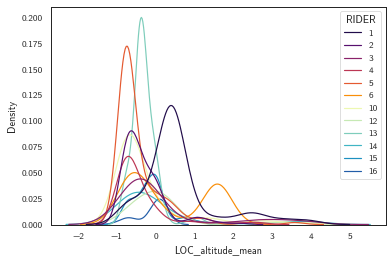

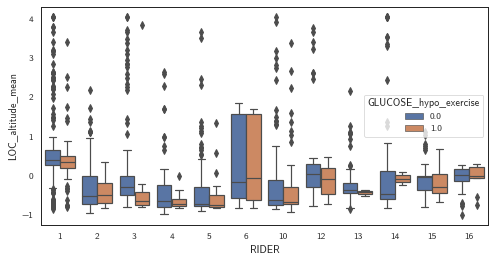

GLUCOSE_hypo_exercise~1+LOC_altitude_mean+(1+LOC_altitude_mean|RIDER)



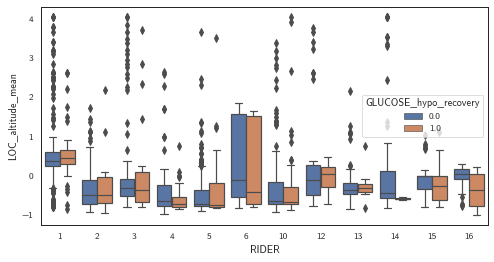

GLUCOSE_hypo_recovery~1+LOC_altitude_mean+(1+LOC_altitude_mean|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



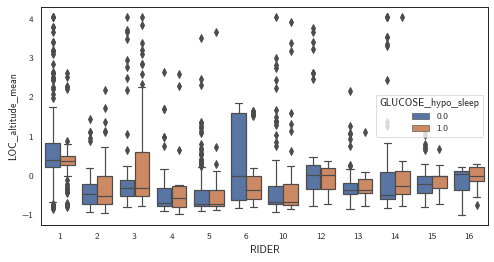

GLUCOSE_hypo_sleep~1+LOC_altitude_mean+(1+LOC_altitude_mean|RIDER)



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1617.2  1644.6 -803.6   1607.2     1773   1693.8  1721.2 -841.9   1683.8   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1911.2  1938.6 -950.6   1901.2     1753

exercise                                 recovery                         \
       Min      1Q  Median      3Q     Max      Min      1Q  Median     3Q   
0  -1.2082 -0.5449 -0.3388 -0.1467  6.7369  -1.5436 -0.4817 -0.3817 -0.192   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  5.2151 -1.1521 -0.7014 -0.4219  0.8894  4.2757

exercise                 recovery                \
                          Variance Std.Dev.  Corr  Variance Std.Dev. Corr   
Groups Name                                                                 
RIDER  (Intercept)        1.382910    1.176   NaN  1.276870   1.1300  NaN   
       LOC_altitude_mean   0.01796    0.134 -0.62   0.04093   0.2023 -1.0   

                             sleep                 
                          Variance Std.Dev.  Corr  
Groups Name                                        
RIDER  (Intercept)        0.672810   0.8202   NaN  
       LOC_altitude_mean   0.05406   0.2325 -0.48

exercise                                 recovery                    \
          Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper   
Feature                                                                         
Intercept     -1.6    -2.30    -0.91     0.00  ***    -1.33    -1.99    -0.67   
Altitude      -0.3    -0.58    -0.02     0.04    *    -0.15    -0.34     0.04   

                           sleep                                  
          Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                           
Intercept     0.00  ***    -0.99    -1.48    -0.51     0.00  ***  
Altitude      0.12         -0.04    -0.24     0.17     0.72

HYPO
binomial: hypo ~ TIME_time_start


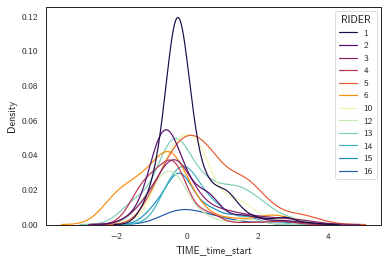

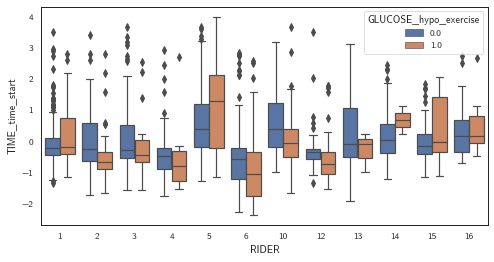

GLUCOSE_hypo_exercise~1+TIME_time_start+(1+TIME_time_start|RIDER)



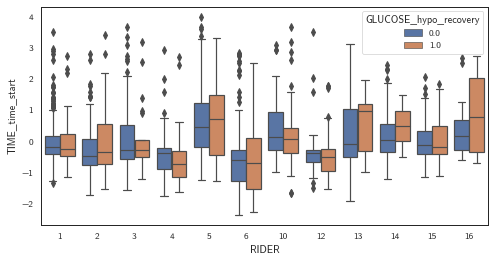

GLUCOSE_hypo_recovery~1+TIME_time_start+(1+TIME_time_start|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



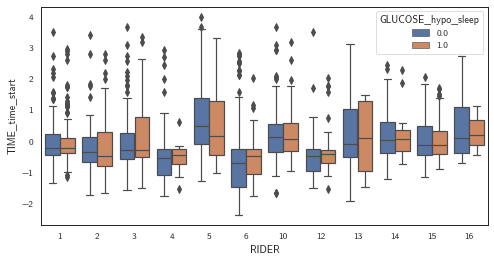

GLUCOSE_hypo_sleep~1+TIME_time_start+(1+TIME_time_start|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1605.4  1632.8 -797.7   1595.4     1773   1703.4  1730.8 -846.7   1693.4   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1769  1917.2  1944.6 -953.6   1907.2     1753

exercise                                recovery                          \
       Min     1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -1.6085 -0.518 -0.3555 -0.1475  7.0234  -1.3864 -0.4778 -0.3912 -0.1745   

           sleep                                  
     Max     Min      1Q  Median      3Q     Max  
0  5.776 -1.2591 -0.7061 -0.4238  0.9076  4.1103

exercise                 recovery                \
                        Variance Std.Dev.  Corr  Variance Std.Dev. Corr   
Groups Name                                                               
RIDER  (Intercept)      1.448200   1.2034   NaN  1.421160    1.192  NaN   
       TIME_time_start    0.1601   0.4001 -0.69   0.02464    0.157 -1.0   

                            sleep                
                         Variance Std.Dev. Corr  
Groups Name                                      
RIDER  (Intercept)       0.692257   0.8320  NaN  
       TIME_time_start  0.0008883   0.0298  1.0

exercise                                 recovery           \
              Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                    
Intercept        -1.65    -2.36    -0.95     0.00  ***    -1.36    -2.06   
Starting time    -0.11    -0.39     0.18     0.46          0.02    -0.14   

                                        sleep                                  
              CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                        
Intercept        -0.67      0.0  ***    -1.02    -1.51    -0.53     0.00  ***  
Starting time     0.18      0.8          0.02    -0.10     0.14     0.71

In [132]:
fe, re, score, res = {}, {}, {}, {}
for col, name in cols_X.items():
    fe[name], re[name], score[name], res[name] = regress(data, x=[col], name='_'.join(col.split('_')[1:]), event='hypo', show_hist=True, show_boxplot=True, random_effects=True)

In [140]:
fe = pd.concat(fe)
fe = fe.drop(fe.loc[pd.IndexSlice[:, 'Intercept'], :].index).reset_index().set_index('Feature').drop('level_0', axis=1)
re = pd.concat(re)

In [155]:
with open(SAVE_PATH+"model_binomial_hypo_univariate.tex", 'w') as file:
	file.write(fe.to_latex(column_format='c', escape=False))
	file.write(re.to_latex(column_format='c', escape=False))

HYPER
binomial: hyper ~ POWER_normalised_power


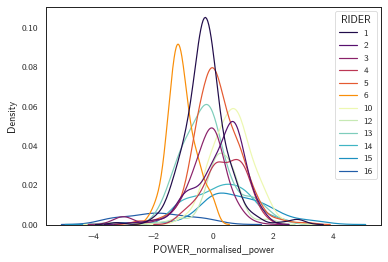

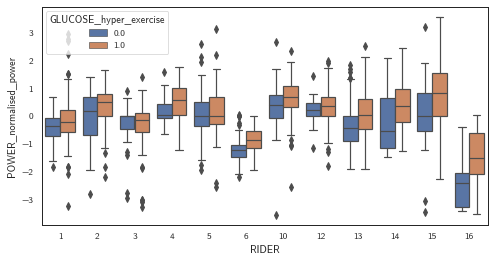

GLUCOSE_hyper_exercise~1+POWER_normalised_power+(1+POWER_normalised_power|RIDER)



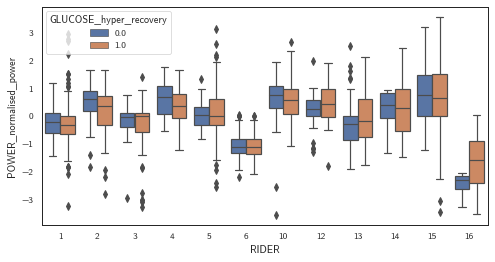

GLUCOSE_hyper_recovery~1+POWER_normalised_power+(1+POWER_normalised_power|RIDER)



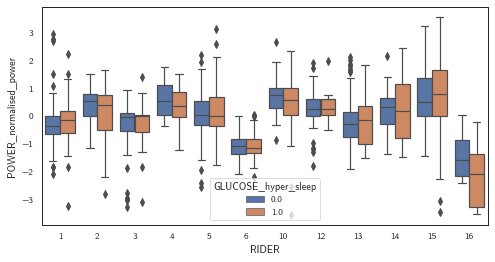

GLUCOSE_hyper_sleep~1+POWER_normalised_power+(1+POWER_normalised_power|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2203.5  2230.9 -1096.7   2193.5     1773   1963.8  1991.2 -976.9   1953.8   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2173.2  2200.5 -1081.6   2163.2     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -4.3579 -0.8284  0.4887  0.7712  2.4967  -4.3394 -0.7531  0.4335  0.5759   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  2.9317 -1.9776 -0.8323 -0.3861  0.9916  3.3238

exercise                 recovery                 \
                         Variance Std.Dev.  Corr  Variance Std.Dev.  Corr   
Groups Name                                                                 
RIDER  Intercept         0.413970   0.6434   NaN  1.144730   1.0699   NaN   
       Normalised power   0.05582   0.2363  0.06   0.04401   0.2098 -0.92   

                            sleep                
                         Variance Std.Dev. Corr  
Groups Name                                      
RIDER  Intercept         0.893500   0.9453  NaN  
       Normalised power    0.0452   0.2126 -1.0

exercise                                 recovery           \
                 Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                       
Intercept            0.57     0.17     0.96      0.0   **     0.87     0.25   
Normalised power     0.57     0.37     0.77      0.0  ***    -0.03    -0.22   

                                           sleep                             \
                 CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                       
Intercept            1.49     0.01   **    -0.25    -0.80     0.30     0.37   
Normalised power     0.15     0.74         -0.04    -0.22     0.13     0.63   

                       
                 Sign  
Feature                
Intercept              
Normalised power

HYPER
binomial: hyper ~ POWER_intensity_factor


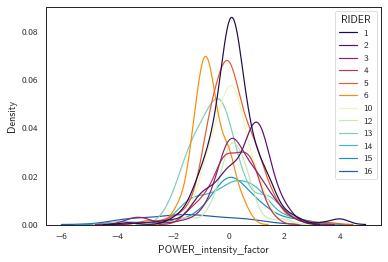

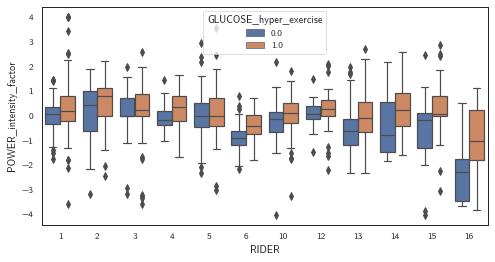

GLUCOSE_hyper_exercise~1+POWER_intensity_factor+(1+POWER_intensity_factor|RIDER)



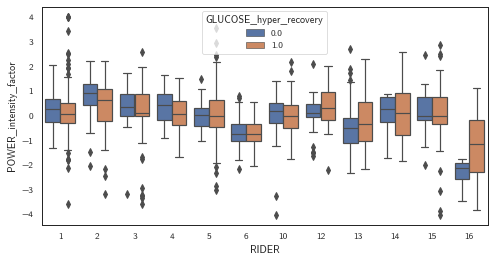

GLUCOSE_hyper_recovery~1+POWER_intensity_factor+(1+POWER_intensity_factor|RIDER)



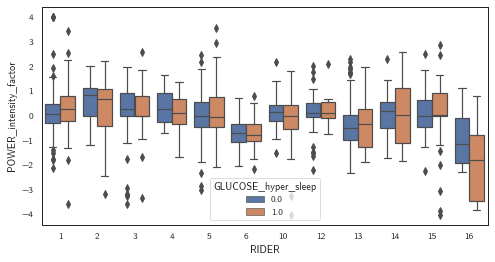

GLUCOSE_hyper_sleep~1+POWER_intensity_factor+(1+POWER_intensity_factor|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2200.4  2227.8 -1095.2   2190.4     1773   1964.0  1991.4 -977.0   1954.0   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2171.7  2199.1 -1080.9   2161.7     1753

exercise                                 recovery                         \
       Min      1Q  Median      3Q     Max      Min      1Q  Median     3Q   
0  -3.8551 -0.8324  0.4857  0.7584  2.5471  -4.2471 -0.7564  0.4303  0.581   

            sleep                                 
      Max     Min      1Q Median      3Q     Max  
0  2.8226 -2.0112 -0.8262  -0.39  1.0032  3.4043

exercise                 recovery                 \
                         Variance Std.Dev.  Corr  Variance Std.Dev.  Corr   
Groups Name                                                                 
RIDER  Intercept         0.423850   0.6510   NaN  1.135130   1.0654   NaN   
       Intensity factor   0.04873   0.2208  0.04   0.03213   0.1792 -0.86   

                            sleep                
                         Variance Std.Dev. Corr  
Groups Name                                      
RIDER  Intercept         0.797790   0.8932  NaN  
       Intensity factor   0.04424   0.2103 -1.0

exercise                                 recovery           \
                 Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                       
Intercept            0.57     0.18     0.97      0.0   **     0.87     0.25   
Intensity factor     0.52     0.34     0.70      0.0  ***    -0.03    -0.19   

                                           sleep                             \
                 CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                       
Intercept            1.49     0.01   **    -0.26    -0.78     0.25     0.32   
Intensity factor     0.13     0.72         -0.05    -0.21     0.12     0.57   

                       
                 Sign  
Feature                
Intercept              
Intensity factor

HYPER
binomial: hyper ~ POWER_training_stress_score


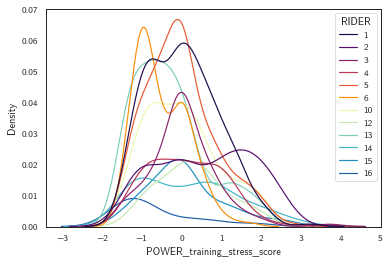

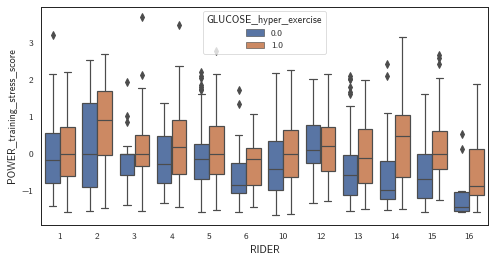

GLUCOSE_hyper_exercise~1+POWER_training_stress_score+(1+POWER_training_stress_score|RIDER)



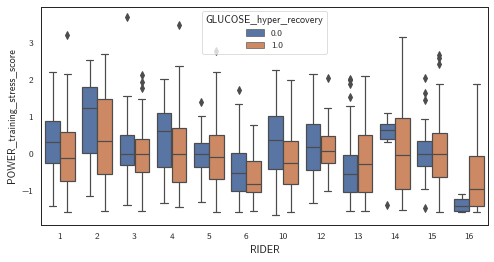

GLUCOSE_hyper_recovery~1+POWER_training_stress_score+(1+POWER_training_stress_score|RIDER)



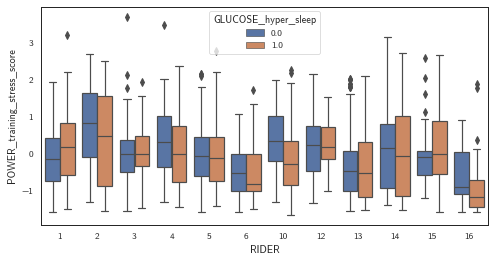

GLUCOSE_hyper_sleep~1+POWER_training_stress_score+(1+POWER_training_stress_score|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2216.2  2243.6 -1103.1   2206.2     1773   1951.6  1979.0 -970.8   1941.6   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2168.2  2195.6 -1079.1   2158.2     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -3.3668 -0.8409  0.4745  0.7767  1.8098  -4.0602 -0.7758  0.4103  0.5947   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  2.2275 -2.2212 -0.8309 -0.3856  0.9911  3.0322

exercise                 recovery           \
                              Variance Std.Dev.  Corr  Variance Std.Dev.   
Groups Name                                                                
RIDER  Intercept              0.439166  0.66270   NaN  1.215080   1.1023   
       Training stress score  0.005217  0.07223  0.32   0.04781   0.2187   

                                       sleep                 
                              Corr  Variance Std.Dev.  Corr  
Groups Name                                                  
RIDER  Intercept               NaN  0.822060   0.9067   NaN  
       Training stress score -0.16   0.05632   0.2373 -0.74

exercise                                 recovery  \
                      Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate   
Feature                                                                   
Intercept                 0.51     0.11      0.9     0.01    *     0.90   
Training stress score     0.45     0.31      0.6     0.00  ***    -0.18   

                                                         sleep           \
                      CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                   
Intercept                 0.26     1.54     0.01   **    -0.26    -0.79   
Training stress score    -0.37    -0.00     0.05    *    -0.06    -0.24   

                                              
                      CI_upper Pr(>|z|) Sign  
Feature                                       
Intercept                 0.26     0.33       
Training stress score     0.12     0.53

HYPER
binomial: hyper ~ POWER_variability_index


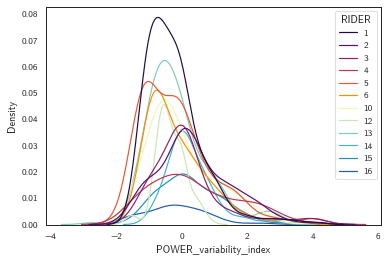

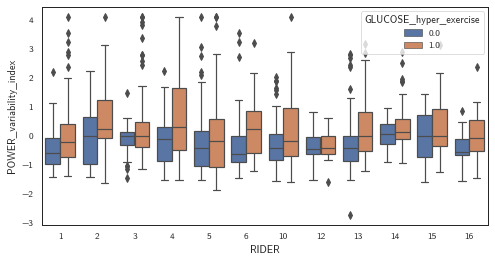

GLUCOSE_hyper_exercise~1+POWER_variability_index+(1+POWER_variability_index|RIDER)



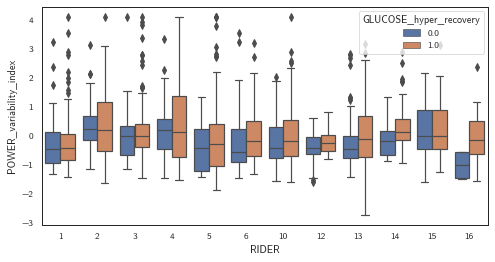

GLUCOSE_hyper_recovery~1+POWER_variability_index+(1+POWER_variability_index|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



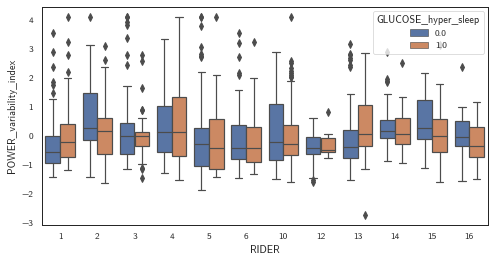

GLUCOSE_hyper_sleep~1+POWER_variability_index+(1+POWER_variability_index|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2199.6  2227.0 -1094.8   2189.6     1773   1955.7  1983.1 -972.8   1945.7   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2171.2  2198.5 -1080.6   2161.2     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -2.6756 -0.8344  0.4682  0.7733  1.8474  -3.5086 -0.7185  0.4104  0.5894   

           sleep                                 
      Max    Min      1Q Median      3Q     Max  
0  2.1378 -1.812 -0.8169 -0.378  0.9297  4.2027

exercise                recovery                \
                          Variance Std.Dev. Corr  Variance Std.Dev. Corr   
Groups Name                                                                
RIDER  Intercept          0.417480   0.6461  NaN  1.093568  1.04574  NaN   
       Variability index   0.01446   0.1203  0.1  0.007592  0.08713 -1.0   

                             sleep                 
                          Variance Std.Dev.  Corr  
Groups Name                                        
RIDER  Intercept          0.815900   0.9033   NaN  
       Variability index   0.05503   0.2346 -0.62

exercise                                 recovery           \
                  Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                        
Intercept             0.49     0.11     0.88     0.01    *     0.87     0.26   
Variability index     0.49     0.34     0.64     0.00  ***     0.18     0.06   

                                            sleep                             \
                  CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                        
Intercept             1.47     0.01   **    -0.24    -0.77     0.29     0.37   
Variability index     0.31     0.00   **    -0.04    -0.22     0.14     0.65   

                        
                  Sign  
Feature                 
Intercept               
Variability index

HYPER
binomial: hyper ~ POWER_efficiency_factor


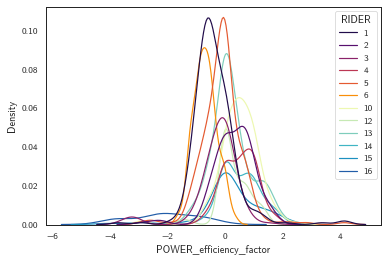

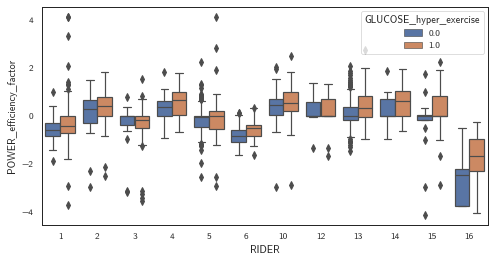

GLUCOSE_hyper_exercise~1+POWER_efficiency_factor+(1+POWER_efficiency_factor|RIDER)



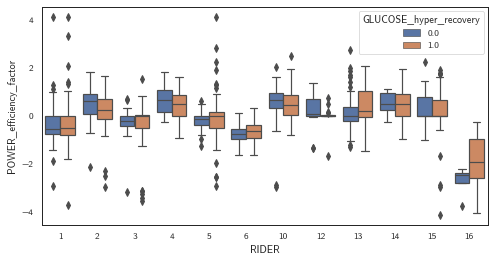

GLUCOSE_hyper_recovery~1+POWER_efficiency_factor+(1+POWER_efficiency_factor|RIDER)



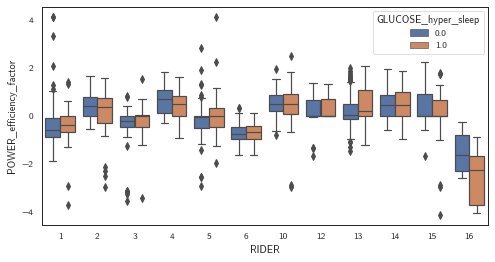

GLUCOSE_hyper_sleep~1+POWER_efficiency_factor+(1+POWER_efficiency_factor|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2236.4  2263.9 -1113.2   2226.4     1773   1961.8  1989.2 -975.9   1951.8   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2173.1  2200.4 -1081.5   2163.1     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -2.7691 -0.8217  0.5152  0.7536  2.1345  -3.4786 -0.7505  0.4135  0.5855   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  2.2079 -2.0389 -0.8289 -0.3832  0.9736  3.6063

exercise                 recovery                 \
                          Variance Std.Dev.  Corr  Variance Std.Dev.  Corr   
Groups Name                                                                  
RIDER  Intercept          0.468680   0.6846   NaN  1.155400   1.0749   NaN   
       Efficiency factor   0.01585   0.1259 -0.23    0.1313   0.3624 -0.02   

                             sleep                 
                          Variance Std.Dev.  Corr  
Groups Name                                        
RIDER  Intercept          0.955520   0.9775   NaN  
       Efficiency factor   0.06071   0.2464 -0.98

exercise                                 recovery           \
                  Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                        
Intercept             0.52     0.11     0.92     0.01    *     0.93     0.30   
Efficiency factor     0.45     0.28     0.62     0.00  ***    -0.09    -0.36   

                                            sleep                             \
                  CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                        
Intercept             1.57     0.00   **    -0.26    -0.82     0.31     0.37   
Efficiency factor     0.19     0.54         -0.04    -0.24     0.17     0.71   

                        
                  Sign  
Feature                 
Intercept               
Efficiency factor

HYPER
binomial: hyper ~ POWER_time_in_power_zone1


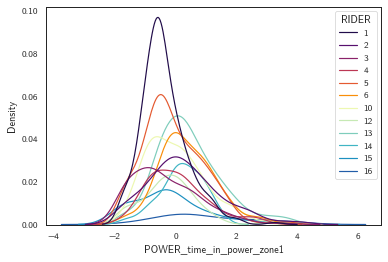

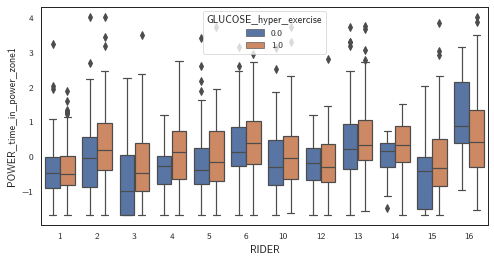

GLUCOSE_hyper_exercise~1+POWER_time_in_power_zone1+(1+POWER_time_in_power_zone1|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



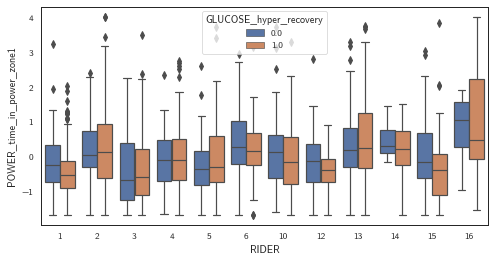

GLUCOSE_hyper_recovery~1+POWER_time_in_power_zone1+(1+POWER_time_in_power_zone1|RIDER)



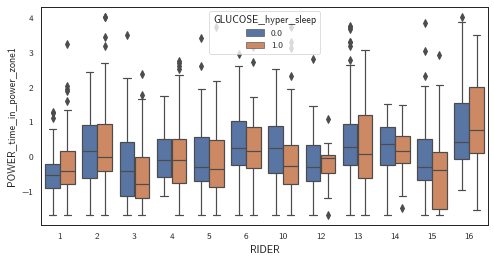

GLUCOSE_hyper_sleep~1+POWER_time_in_power_zone1+(1+POWER_time_in_power_zone1|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2256.0  2283.4 -1123.0   2246.0     1773   1965.9  1993.3 -977.9   1955.9   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2176.7  2204.1 -1083.3   2166.7     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -2.7531 -0.8278  0.5157  0.7781  1.6237  -3.5027 -0.7647  0.4105  0.5792   

            sleep                                 
      Max     Min     1Q  Median      3Q     Max  
0  2.0813 -1.8416 -0.828 -0.3833  0.9799  2.9866

exercise                \
                                               Variance Std.Dev. Corr   
Groups Name                                                             
RIDER  Intercept                               0.536100  0.73221  NaN   
       Time in power zone 1 (Active Recovery)    0.0024  0.04899  1.0   

                                               recovery                 \
                                               Variance Std.Dev.  Corr   
Groups Name                                                              
RIDER  Intercept                               1.177100   1.0849   NaN   
       Time in power zone 1 (Active Recovery)    0.0173   0.1315  0.11   

                                                  sleep                 
                                               Variance Std.Dev.  Corr  
Groups Name                                                             
RIDER  Intercept                               0.814430   0.9025   NaN  
       Time in power zone 1 (Active Recovery)   0.02076   0.1441 -0.14

exercise                             \
                                       Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                      
Intercept                                  0.47     0.04     0.90     0.03   
Time in power zone 1 (Active Recovery)     0.24     0.13     0.35     0.00   

                                            recovery                    \
                                       Sign Estimate CI_lower CI_upper   
Feature                                                                  
Intercept                                 *     0.86     0.23     1.49   
Time in power zone 1 (Active Recovery)  ***    -0.07    -0.21     0.07   

                                                        sleep           \
                                       Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                  
Intercept                                  0.01   **    -0.26    -0.79   
Time in power zone 1 (Active Recovery)     0.32         -0.06    -0.20   

                                                               
                                       CI_upper Pr(>|z|) Sign  
Feature                                                        
Intercept                                  0.27     0.33       
Time in power zone 1 (Active Recovery)     0.07     0.37

HYPER
binomial: hyper ~ POWER_time_in_power_zone2


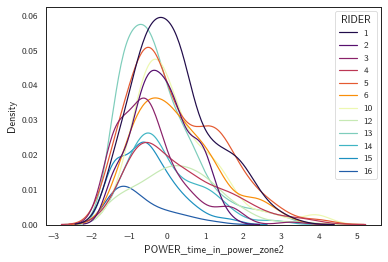

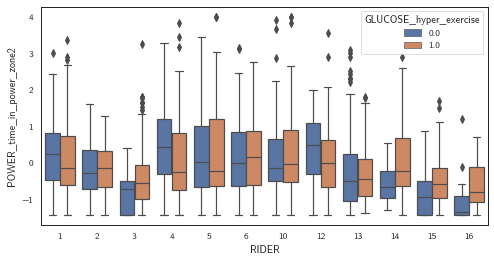

GLUCOSE_hyper_exercise~1+POWER_time_in_power_zone2+(1+POWER_time_in_power_zone2|RIDER)



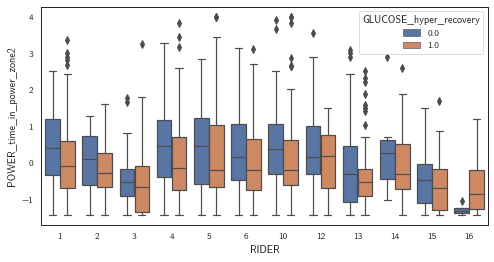

GLUCOSE_hyper_recovery~1+POWER_time_in_power_zone2+(1+POWER_time_in_power_zone2|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



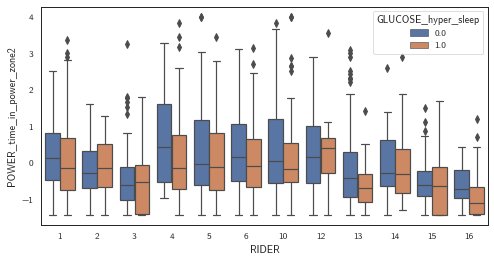

GLUCOSE_hyper_sleep~1+POWER_time_in_power_zone2+(1+POWER_time_in_power_zone2|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2271.2  2298.6 -1130.6   2261.2     1773   1947.0  1974.4 -968.5   1937.0   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2172.4  2199.8 -1081.2   2162.4     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0   -2.359 -0.8176  0.5322  0.7876  1.5325  -3.8152 -0.7444  0.4533  0.5877   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  2.4176 -1.9178 -0.8393 -0.3853  0.9906  2.8648

exercise                 recovery  \
                                         Variance Std.Dev.  Corr  Variance   
Groups Name                                                                  
RIDER  Intercept                         0.563910   0.7509   NaN  1.151111   
       Time in power zone 2 (Endurance)   0.04067   0.2017  0.72  0.001052   

                                                           sleep                
                                        Std.Dev. Corr   Variance Std.Dev. Corr  
Groups Name                                                                     
RIDER  Intercept                         1.07290  NaN   0.817503  0.90416  NaN  
       Time in power zone 2 (Endurance)  0.03244  1.0  0.0008887  0.02981 -1.0

exercise                                  \
                                 Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                     
Intercept                            0.53     0.08     0.97     0.02    *   
Time in power zone 2 (Endurance)     0.09    -0.09     0.28     0.33        

                                 recovery                                  \
                                 Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                     
Intercept                            0.86     0.23     1.48     0.01   **   
Time in power zone 2 (Endurance)    -0.25    -0.36    -0.14     0.00  ***   

                                    sleep                                  
                                 Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                    
Intercept                           -0.28    -0.80     0.25     0.30       
Time in power zone 2 (Endurance)    -0.14    -0.25    -0.04     0.01   **

HYPER
binomial: hyper ~ POWER_time_in_power_zone3


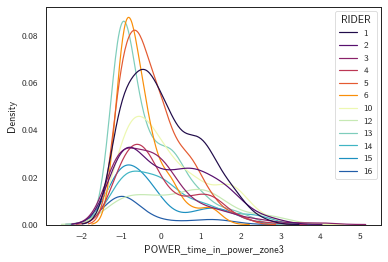

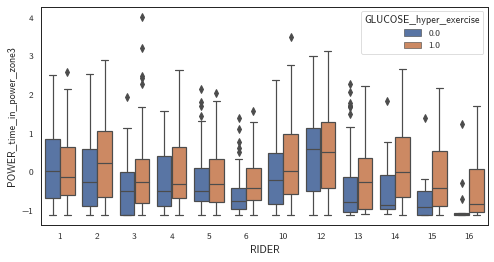

GLUCOSE_hyper_exercise~1+POWER_time_in_power_zone3+(1+POWER_time_in_power_zone3|RIDER)



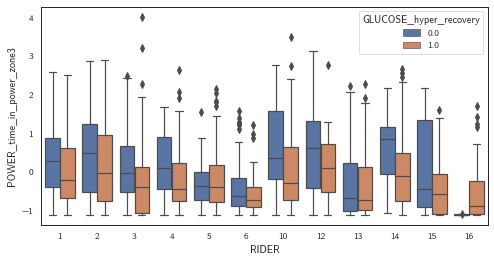

GLUCOSE_hyper_recovery~1+POWER_time_in_power_zone3+(1+POWER_time_in_power_zone3|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



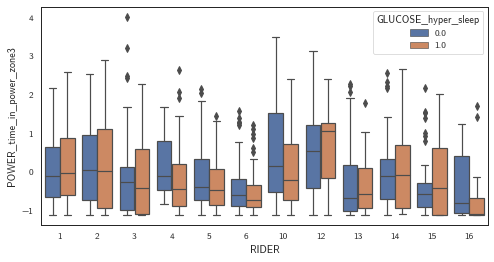

GLUCOSE_hyper_sleep~1+POWER_time_in_power_zone3+(1+POWER_time_in_power_zone3|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2246.6  2274.0 -1118.3   2236.6     1773   1948.7  1976.1 -969.4   1938.7   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2175.1  2202.4 -1082.5   2165.1     1753

exercise                                recovery                          \
       Min      1Q Median      3Q     Max      Min      1Q  Median      3Q   
0  -3.3717 -0.8333   0.51  0.8136  1.5991   -4.262 -0.7678  0.4546  0.5852   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  2.5014 -1.8988 -0.8365 -0.3819  1.0065  2.8439

exercise                 recovery  \
                                     Variance Std.Dev.  Corr  Variance   
Groups Name                                                              
RIDER  Intercept                     0.473880   0.6884   NaN  1.176371   
       Time in power zone 3 (Tempo)   0.06497   0.2549  0.27  0.001248   

                                                      sleep                 
                                    Std.Dev. Corr  Variance Std.Dev.  Corr  
Groups Name                                                                 
RIDER  Intercept                     1.08461  NaN  0.817190   0.9040   NaN  
       Time in power zone 3 (Tempo)  0.03533 -1.0   0.01656   0.1287 -0.97

exercise                                  \
                             Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                 
Intercept                        0.56     0.15     0.97     0.01   **   
Time in power zone 3 (Tempo)     0.37     0.16     0.57     0.00  ***   

                             recovery                                  \
                             Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                 
Intercept                        0.86     0.23     1.49     0.01   **   
Time in power zone 3 (Tempo)    -0.28    -0.40    -0.15     0.00  ***   

                                sleep                                  
                             Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                
Intercept                       -0.27     -0.8     0.25     0.31       
Time in power zone 3 (Tempo)    -0.06     -0.2     0.08     0.37

HYPER
binomial: hyper ~ POWER_time_in_power_zone4


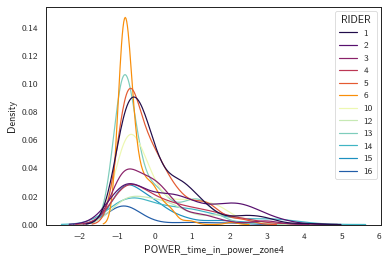

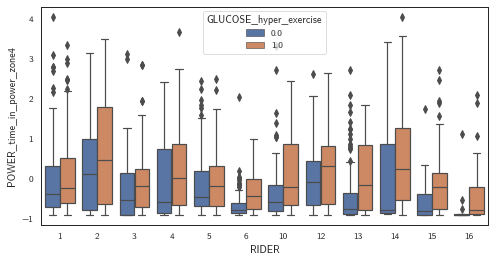

GLUCOSE_hyper_exercise~1+POWER_time_in_power_zone4+(1+POWER_time_in_power_zone4|RIDER)



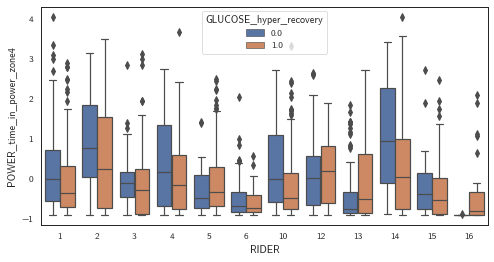

GLUCOSE_hyper_recovery~1+POWER_time_in_power_zone4+(1+POWER_time_in_power_zone4|RIDER)



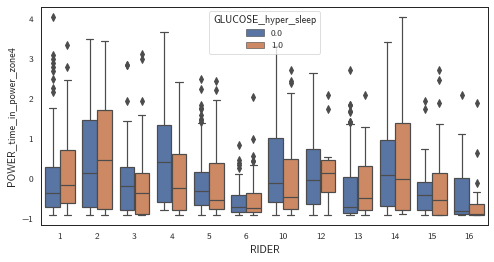

GLUCOSE_hyper_sleep~1+POWER_time_in_power_zone4+(1+POWER_time_in_power_zone4|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2233.3  2260.7 -1111.6   2223.3     1773   1953.7  1981.1 -971.8   1943.7   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2172.3  2199.7 -1081.2   2162.3     1753

exercise                                recovery                          \
       Min      1Q  Median      3Q    Max      Min      1Q  Median      3Q   
0  -3.2129 -0.8243  0.5111  0.7808  1.749  -4.1374 -0.7651  0.4117  0.5754   

         sleep                                  
    Max    Min      1Q  Median      3Q     Max  
0  1.97 -1.989 -0.8239 -0.3641  1.0212  3.0356

exercise                 \
                                                 Variance Std.Dev.  Corr   
Groups Name                                                                
RIDER  Intercept                                 0.390460   0.6249   NaN   
       Time in power zone 4 (Lactate Threshold)   0.06812   0.2610 -0.31   

                                                 recovery                 \
                                                 Variance Std.Dev.  Corr   
Groups Name                                                                
RIDER  Intercept                                 1.238280   1.1128   NaN   
       Time in power zone 4 (Lactate Threshold)   0.06163   0.2483 -0.27   

                                                    sleep                
                                                 Variance Std.Dev. Corr  
Groups Name                                                              
RIDER  Intercept                                 0.822480   0.9069  NaN  
       Time in power zone 4 (Lactate Threshold)   0.03603   0.1898 -1.0

exercise                             \
                                         Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                        
Intercept                                    0.53     0.16     0.91     0.01   
Time in power zone 4 (Lactate Threshold)     0.40     0.19     0.62     0.00   

                                              recovery                    \
                                         Sign Estimate CI_lower CI_upper   
Feature                                                                    
Intercept                                  **     0.90     0.25     1.55   
Time in power zone 4 (Lactate Threshold)  ***    -0.11    -0.30     0.08   

                                                          sleep           \
                                         Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                    
Intercept                                    0.01   **    -0.26    -0.79   
Time in power zone 4 (Lactate Threshold)     0.26          0.03    -0.13   

                                                                 
                                         CI_upper Pr(>|z|) Sign  
Feature                                                          
Intercept                                    0.27     0.34       
Time in power zone 4 (Lactate Threshold)     0.18     0.74

HYPER
binomial: hyper ~ POWER_time_in_power_zone5


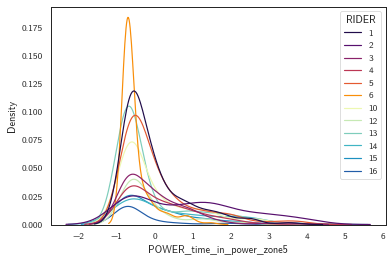

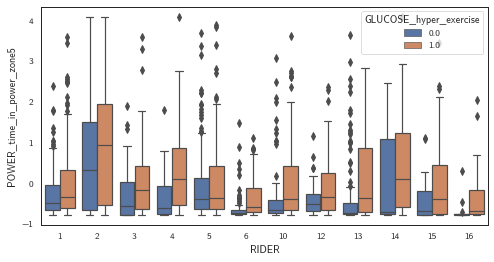

GLUCOSE_hyper_exercise~1+POWER_time_in_power_zone5+(1+POWER_time_in_power_zone5|RIDER)



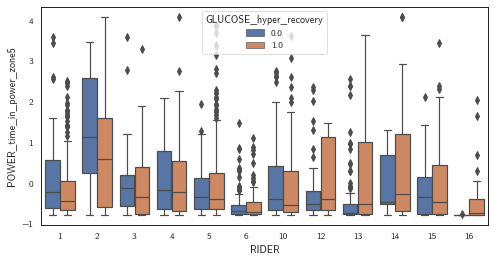

GLUCOSE_hyper_recovery~1+POWER_time_in_power_zone5+(1+POWER_time_in_power_zone5|RIDER)



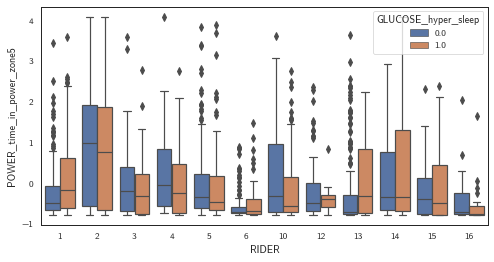

GLUCOSE_hyper_sleep~1+POWER_time_in_power_zone5+(1+POWER_time_in_power_zone5|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2219.2  2246.6 -1104.6   2209.2     1773   1951.2  1978.6 -970.6   1941.2   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2169.8  2197.2 -1079.9   2159.8     1753

exercise                                 recovery                         \
       Min      1Q  Median      3Q     Max      Min     1Q  Median      3Q   
0  -3.0324 -0.7979  0.4814  0.7763  1.6401  -3.4117 -0.737  0.4242  0.5824   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  2.2694 -1.9116 -0.8145 -0.3524  1.0072  3.0497

exercise                 recovery  \
                                      Variance Std.Dev.  Corr  Variance   
Groups Name                                                               
RIDER  Intercept                      0.407990   0.6387   NaN  1.077700   
       Time in power zone 5 (VO2max)   0.05593   0.2365 -0.02    0.0829   

                                                        sleep                 
                                     Std.Dev.  Corr  Variance Std.Dev.  Corr  
Groups Name                                                                   
RIDER  Intercept                       1.0381   NaN  0.791190   0.8895   NaN  
       Time in power zone 5 (VO2max)   0.2879 -0.66   0.04729   0.2175 -0.85

exercise                                  \
                              Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                  
Intercept                         0.55     0.16     0.93     0.01   **   
Time in power zone 5 (VO2max)     0.51     0.28     0.73     0.00  ***   

                              recovery                                  \
                              Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                  
Intercept                         0.90     0.30     1.51     0.00   **   
Time in power zone 5 (VO2max)     0.07    -0.15     0.28     0.54        

                                 sleep                                  
                              Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                 
Intercept                        -0.26    -0.77     0.26     0.33       
Time in power zone 5 (VO2max)     0.04    -0.13     0.20     0.66

HYPER
binomial: hyper ~ POWER_time_in_power_zone6


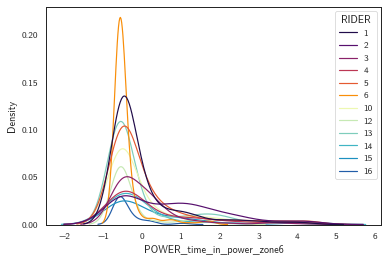

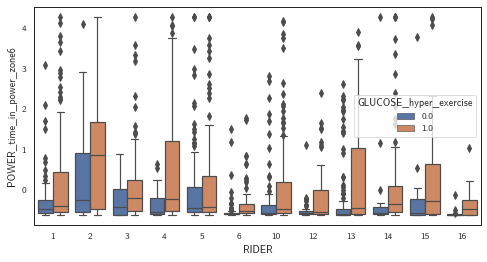

GLUCOSE_hyper_exercise~1+POWER_time_in_power_zone6+(1+POWER_time_in_power_zone6|RIDER)



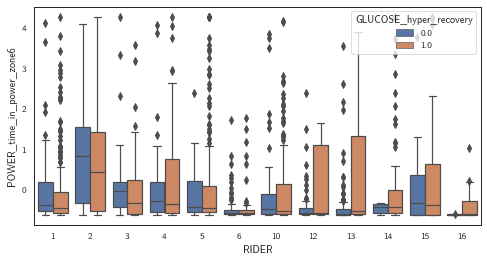

GLUCOSE_hyper_recovery~1+POWER_time_in_power_zone6+(1+POWER_time_in_power_zone6|RIDER)



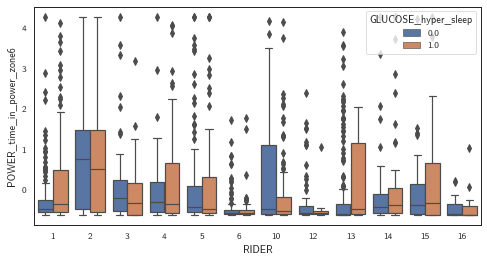

GLUCOSE_hyper_sleep~1+POWER_time_in_power_zone6+(1+POWER_time_in_power_zone6|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2199.1  2226.5 -1094.6   2189.1     1773   1945.9  1973.3 -967.9   1935.9   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2167.6  2194.9 -1078.8   2157.6     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -5.9397 -0.7793  0.4559  0.7727  1.6122  -3.2781 -0.7286  0.4251  0.5601   

            sleep                                 
      Max     Min      1Q Median      3Q     Max  
0  2.2496 -1.7235 -0.8237  -0.35  0.9618  2.9607

exercise                 \
                                                  Variance Std.Dev.  Corr   
Groups Name                                                                 
RIDER  Intercept                                  0.436070   0.6604   NaN   
       Time in power zone 6 (Anaerobic Capacity)   0.03649   0.1910  0.14   

                                                  recovery                 \
                                                  Variance Std.Dev.  Corr   
Groups Name                                                                 
RIDER  Intercept                                  0.996770   0.9984   NaN   
       Time in power zone 6 (Anaerobic Capacity)   0.09666   0.3109 -0.84   

                                                     sleep                
                                                  Variance Std.Dev. Corr  
Groups Name                                                               
RIDER  Intercept                                  0.799480   0.8941  NaN  
       Time in power zone 6 (Anaerobic Capacity)   0.04644   0.2155 -0.6

exercise                             \
                                          Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                         
Intercept                                     0.54     0.14     0.93     0.01   
Time in power zone 6 (Anaerobic Capacity)     0.58     0.36     0.81     0.00   

                                               recovery                    \
                                          Sign Estimate CI_lower CI_upper   
Feature                                                                     
Intercept                                   **     0.89     0.31     1.47   
Time in power zone 6 (Anaerobic Capacity)  ***     0.18    -0.04     0.40   

                                                           sleep           \
                                          Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                     
Intercept                                     0.00   **    -0.26    -0.78   
Time in power zone 6 (Anaerobic Capacity)     0.11          0.06    -0.11   

                                                                  
                                          CI_upper Pr(>|z|) Sign  
Feature                                                           
Intercept                                     0.26     0.32       
Time in power zone 6 (Anaerobic Capacity)     0.23     0.48

HYPER
binomial: hyper ~ HR_heart_rate_mean


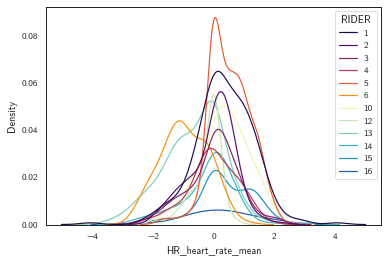

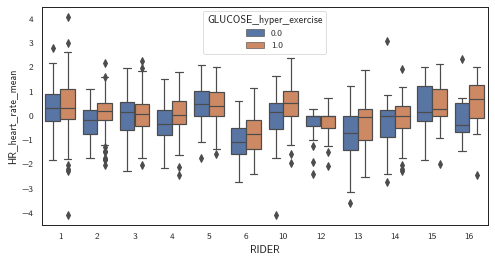

GLUCOSE_hyper_exercise~1+HR_heart_rate_mean+(1+HR_heart_rate_mean|RIDER)



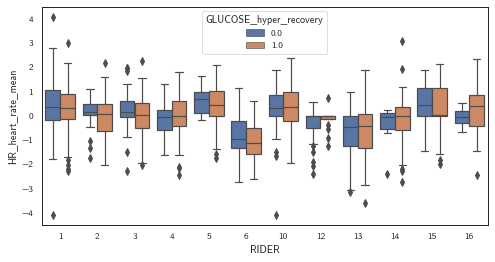

GLUCOSE_hyper_recovery~1+HR_heart_rate_mean+(1+HR_heart_rate_mean|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



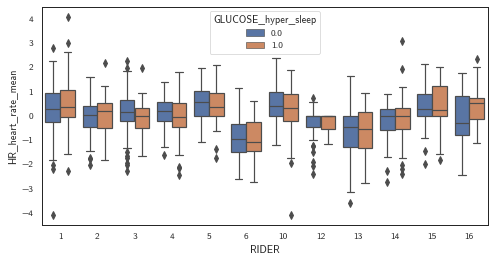

GLUCOSE_hyper_sleep~1+HR_heart_rate_mean+(1+HR_heart_rate_mean|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2237.8  2265.2 -1113.9   2227.8     1773   1965.4  1992.8 -977.7   1955.4   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2179.8  2207.1 -1084.9   2169.8     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -2.8387 -0.8512  0.5206  0.7849  2.3676  -4.2102 -0.7578  0.4156  0.5884   

            sleep                                
      Max     Min    1Q  Median      3Q     Max  
0  2.0004 -1.7943 -0.83 -0.3802  1.0089  2.8334

exercise                 recovery                   sleep  \
                  Variance Std.Dev.  Corr  Variance Std.Dev. Corr  Variance   
Groups Name                                                                   
RIDER  Intercept   0.38450   0.6201   NaN  1.215213   1.1024  NaN  0.799138   
       Heart rate    0.039   0.1975 -0.02  0.001339   0.0366 -1.0  0.007909   

                                  
                  Std.Dev.  Corr  
Groups Name                       
RIDER  Intercept   0.89395   NaN  
       Heart rate  0.08893 -0.35

exercise                                 recovery           \
           Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                 
Intercept      0.52     0.14     0.89     0.01   **     0.87     0.23   
Heart rate     0.36     0.18     0.53     0.00  ***    -0.12    -0.25   

                                     sleep                                  
           CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                     
Intercept      1.52     0.01   **    -0.27    -0.79     0.25     0.31       
Heart rate     0.02     0.09    .     0.00    -0.13     0.14     0.95

HYPER
binomial: hyper ~ HR_time_in_hr_zone1


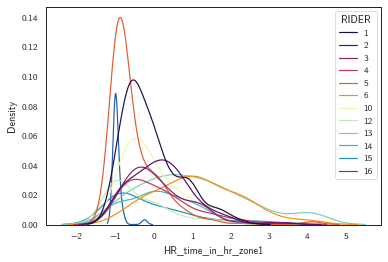

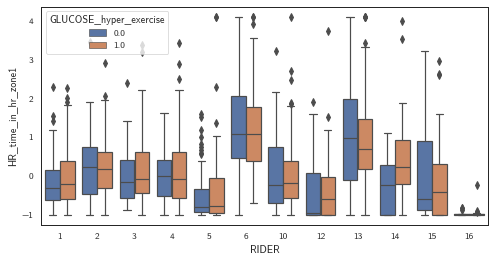

GLUCOSE_hyper_exercise~1+HR_time_in_hr_zone1+(1+HR_time_in_hr_zone1|RIDER)



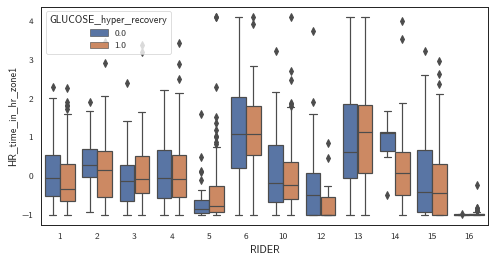

GLUCOSE_hyper_recovery~1+HR_time_in_hr_zone1+(1+HR_time_in_hr_zone1|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



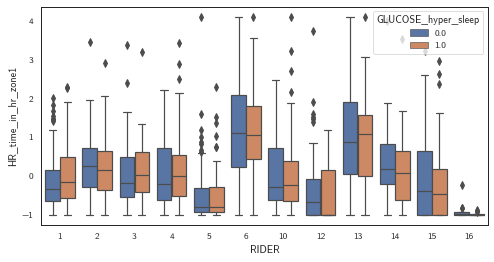

GLUCOSE_hyper_sleep~1+HR_time_in_hr_zone1+(1+HR_time_in_hr_zone1|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2273.0  2300.4 -1131.5   2263.0     1773   1966.2  1993.6 -978.1   1956.2   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2180.2  2207.5 -1085.1   2170.2     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -2.2423 -0.8104  0.5434  0.7646  1.4079  -3.7951 -0.7573  0.4137  0.5857   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  1.9767 -1.7248 -0.8458 -0.3746  1.0087  2.7066

exercise                 recovery  \
                                            Variance Std.Dev.  Corr  Variance   
Groups Name                                                                     
RIDER  Intercept                            0.475917  0.68987   NaN  1.142754   
       Time in HR zone 1 (Active Recovery)  0.005448  0.07381  0.54  0.007205   

                                                              sleep           \
                                           Std.Dev. Corr   Variance Std.Dev.   
Groups Name                                                                    
RIDER  Intercept                            1.06900  NaN      0.807  0.89835   
       Time in HR zone 1 (Active Recovery)  0.08489 -1.0  4.733e-05  0.00688   

                                                 
                                           Corr  
Groups Name                                      
RIDER  Intercept                            NaN  
       Time in HR zone 1 (Active Recovery)  1.0

exercise                                  \
                                    Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                        
Intercept                               0.48     0.07     0.89     0.02    *   
Time in HR zone 1 (Active Recovery)     0.09    -0.05     0.22     0.21        

                                    recovery                                  \
                                    Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                        
Intercept                               0.86     0.24     1.48     0.01   **   
Time in HR zone 1 (Active Recovery)    -0.09    -0.22     0.05     0.20        

                                       sleep                                  
                                    Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                       
Intercept                              -0.27    -0.79     0.25     0.31       
Time in HR zone 1 (Active Recovery)     0.01    -0.11     0.12     0.92

HYPER
binomial: hyper ~ HR_time_in_hr_zone2


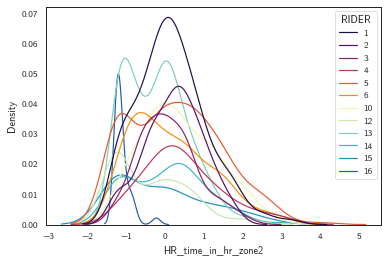

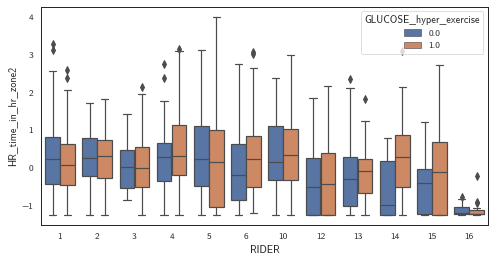

GLUCOSE_hyper_exercise~1+HR_time_in_hr_zone2+(1+HR_time_in_hr_zone2|RIDER)



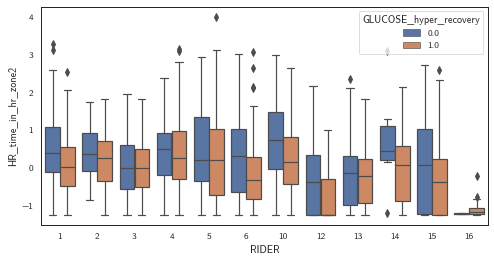

GLUCOSE_hyper_recovery~1+HR_time_in_hr_zone2+(1+HR_time_in_hr_zone2|RIDER)



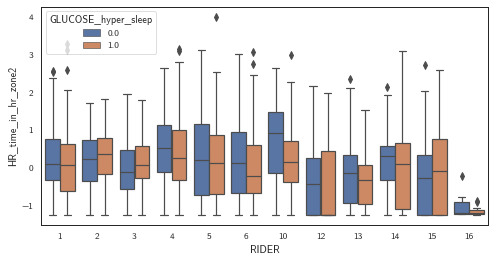

GLUCOSE_hyper_sleep~1+HR_time_in_hr_zone2+(1+HR_time_in_hr_zone2|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2270.7  2298.1 -1130.4   2260.7     1773   1937.2  1964.7 -963.6   1927.2   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2174.8  2202.1 -1082.4   2164.8     1753

exercise                                recovery                          \
       Min      1Q Median      3Q     Max      Min      1Q  Median      3Q   
0  -2.2589 -0.8182  0.535  0.8124  1.3933  -4.6521 -0.7572  0.4248  0.5819   

            sleep                                 
      Max     Min      1Q  Median     3Q     Max  
0  2.3646 -2.1188 -0.8373 -0.3884  1.014  2.8584

exercise                 recovery  \
                                      Variance Std.Dev.  Corr  Variance   
Groups Name                                                               
RIDER  Intercept                      0.490600   0.7004   NaN  1.258490   
       Time in HR zone 2 (Endurance)   0.02495   0.1580  0.55   0.01069   

                                                       sleep                 
                                     Std.Dev. Corr  Variance Std.Dev.  Corr  
Groups Name                                                                  
RIDER  Intercept                       1.1218  NaN  0.827990   0.9099   NaN  
       Time in HR zone 2 (Endurance)   0.1034 -0.4   0.01501   0.1225 -0.98

exercise                                  \
                              Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                  
Intercept                         0.49     0.07     0.90     0.02    *   
Time in HR zone 2 (Endurance)     0.11    -0.04     0.27     0.16        

                              recovery                                  \
                              Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                  
Intercept                         0.90     0.24     1.55     0.01   **   
Time in HR zone 2 (Endurance)    -0.34    -0.47    -0.20     0.00  ***   

                                 sleep                                  
                              Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                 
Intercept                        -0.25    -0.78     0.27     0.35       
Time in HR zone 2 (Endurance)    -0.08    -0.22     0.06     0.25

HYPER
binomial: hyper ~ HR_time_in_hr_zone3


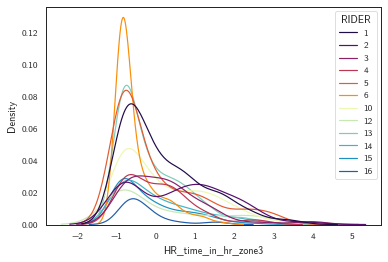

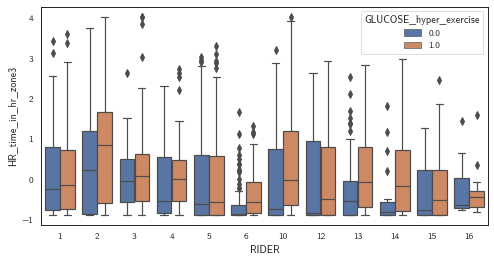

GLUCOSE_hyper_exercise~1+HR_time_in_hr_zone3+(1+HR_time_in_hr_zone3|RIDER)



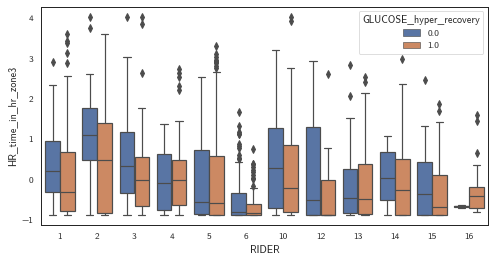

GLUCOSE_hyper_recovery~1+HR_time_in_hr_zone3+(1+HR_time_in_hr_zone3|RIDER)



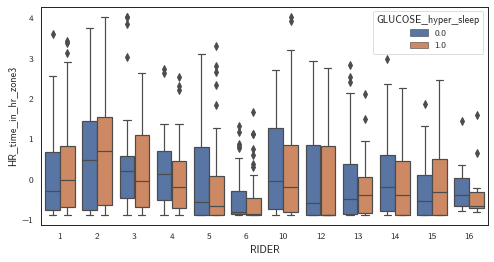

GLUCOSE_hyper_sleep~1+HR_time_in_hr_zone3+(1+HR_time_in_hr_zone3|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2249.1  2276.5 -1119.5   2239.1     1773   1957.3  1984.7 -973.7   1947.3   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2179.3  2206.7 -1084.7   2169.3     1753

exercise                                 recovery                        \
       Min      1Q  Median      3Q     Max      Min      1Q Median     3Q   
0  -2.6942 -0.8263  0.5241  0.7885  1.6534  -3.7164 -0.7806  0.425  0.588   

           sleep                                  
      Max    Min      1Q  Median      3Q     Max  
0  2.7517 -1.781 -0.8418 -0.3753  1.0035  2.6957

exercise                 recovery           \
                                  Variance Std.Dev.  Corr  Variance Std.Dev.   
Groups Name                                                                    
RIDER  Intercept                  0.433800   0.6586   NaN  1.233620   1.1107   
       Time in HR zone 3 (Tempo)    0.0353   0.1879 -0.09   0.01284   0.1133   

                                           sleep                 
                                  Corr  Variance Std.Dev.  Corr  
Groups Name                                                      
RIDER  Intercept                   NaN  0.813252  0.90180   NaN  
       Time in HR zone 3 (Tempo)  0.22  0.004038  0.06355 -0.51

exercise                                 recovery  \
                          Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate   
Feature                                                                       
Intercept                     0.50     0.10     0.89     0.01    *     0.88   
Time in HR zone 3 (Tempo)     0.29     0.12     0.46     0.00  ***    -0.18   

                                                             sleep           \
                          CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                       
Intercept                     0.23     1.53     0.01   **    -0.27    -0.79   
Time in HR zone 3 (Tempo)    -0.32    -0.05     0.01   **    -0.04    -0.15   

                                                  
                          CI_upper Pr(>|z|) Sign  
Feature                                           
Intercept                     0.25     0.31       
Time in HR zone 3 (Tempo)     0.07     0.48

HYPER
binomial: hyper ~ HR_time_in_hr_zone4


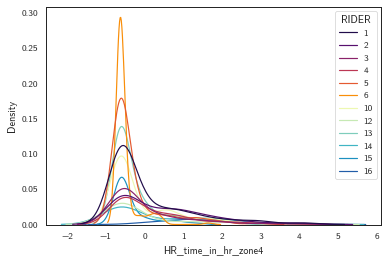

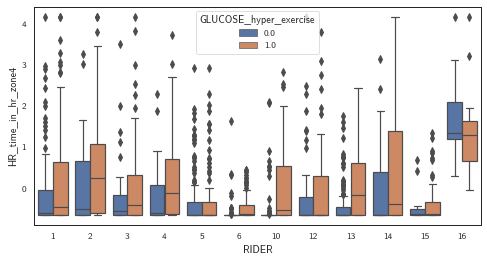

GLUCOSE_hyper_exercise~1+HR_time_in_hr_zone4+(1+HR_time_in_hr_zone4|RIDER)



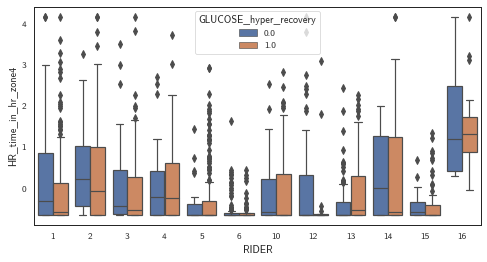

GLUCOSE_hyper_recovery~1+HR_time_in_hr_zone4+(1+HR_time_in_hr_zone4|RIDER)



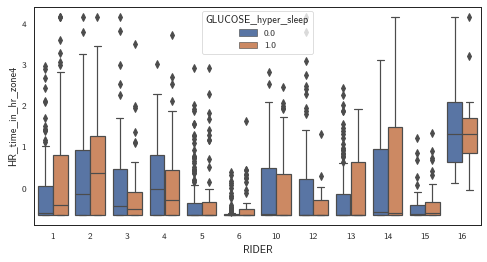

GLUCOSE_hyper_sleep~1+HR_time_in_hr_zone4+(1+HR_time_in_hr_zone4|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2229.1  2256.5 -1109.5   2219.1     1773   1963.2  1990.6 -976.6   1953.2   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2171.7  2199.0 -1080.8   2161.7     1753

exercise                                 recovery                         \
       Min      1Q  Median      3Q     Max      Min      1Q Median      3Q   
0  -2.9504 -0.7872  0.5128  0.7769  1.7232  -3.4996 -0.7512  0.416  0.5777   

            sleep                                
      Max     Min      1Q Median      3Q    Max  
0  2.0561 -1.7705 -0.8122 -0.373  0.9847  2.901

exercise                 \
                                              Variance Std.Dev.  Corr   
Groups Name                                                             
RIDER  Intercept                              0.389300   0.6239   NaN   
       Time in HR zone 4 (Lactate Threshold)    0.1254   0.3542 -0.36   

                                              recovery                 \
                                              Variance Std.Dev.  Corr   
Groups Name                                                             
RIDER  Intercept                              1.169240   1.0813   NaN   
       Time in HR zone 4 (Lactate Threshold)   0.04386   0.2094 -0.17   

                                                 sleep                 
                                              Variance Std.Dev.  Corr  
Groups Name                                                            
RIDER  Intercept                              0.784010   0.8854   NaN  
       Time in HR zone 4 (Lactate Threshold)   0.03077   0.1754 -0.57

exercise                             \
                                      Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                     
Intercept                                 0.55     0.17     0.93      0.0   
Time in HR zone 4 (Lactate Threshold)     0.40     0.15     0.66      0.0   

                                           recovery                    \
                                      Sign Estimate CI_lower CI_upper   
Feature                                                                 
Intercept                               **     0.89     0.26     1.52   
Time in HR zone 4 (Lactate Threshold)   **     0.01    -0.17     0.20   

                                                       sleep           \
                                      Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                 
Intercept                                 0.01   **    -0.26    -0.78   
Time in HR zone 4 (Lactate Threshold)     0.88          0.10    -0.06   

                                                              
                                      CI_upper Pr(>|z|) Sign  
Feature                                                       
Intercept                                 0.26     0.32       
Time in HR zone 4 (Lactate Threshold)     0.26     0.22

HYPER
binomial: hyper ~ HR_time_in_hr_zone5


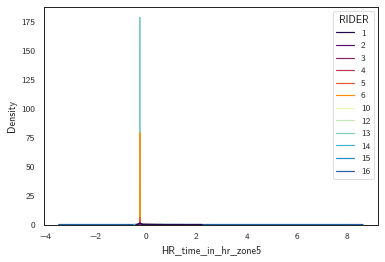

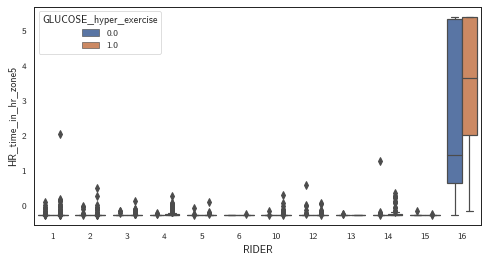

GLUCOSE_hyper_exercise~1+HR_time_in_hr_zone5+(1+HR_time_in_hr_zone5|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



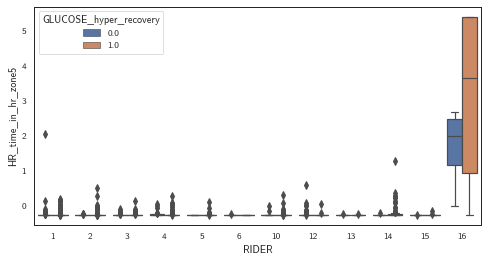

GLUCOSE_hyper_recovery~1+HR_time_in_hr_zone5+(1+HR_time_in_hr_zone5|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



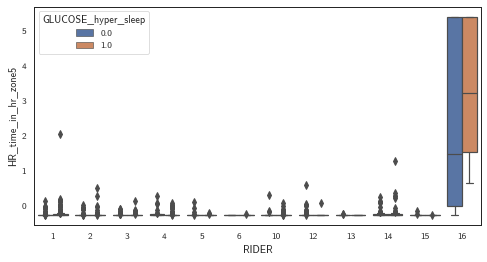

GLUCOSE_hyper_sleep~1+HR_time_in_hr_zone5+(1+HR_time_in_hr_zone5|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2271.6  2299.0 -1130.8   2261.6     1773   1965.5  1992.9 -977.8   1955.5   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2175.8  2203.2 -1082.9   2165.8     1753

exercise                                 recovery                        \
       Min      1Q  Median      3Q     Max      Min     1Q Median      3Q   
0   -2.018 -0.8049  0.5396  0.6931  1.3847  -3.4073 -0.753  0.382  0.5729   

            sleep                                 
      Max     Min     1Q  Median      3Q     Max  
0  1.9666 -1.7572 -0.838 -0.3737  1.0094  2.6762

exercise                \
                                               Variance Std.Dev. Corr   
Groups Name                                                             
RIDER  Intercept                               0.500440   0.7074  NaN   
       Time in HR zone 5 (Anaerobic Capacity)  0.004817   0.0694 -1.0   

                                               recovery                \
                                               Variance Std.Dev. Corr   
Groups Name                                                             
RIDER  Intercept                               1.007180   1.0036  NaN   
       Time in HR zone 5 (Anaerobic Capacity)   0.02746   0.1657 -1.0   

                                                  sleep                
                                               Variance Std.Dev. Corr  
Groups Name                                                            
RIDER  Intercept                               0.685750   0.8281  NaN  
       Time in HR zone 5 (Anaerobic Capacity)   0.05606   0.2368 -1.0

exercise                             \
                                       Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                      
Intercept                                  0.47     0.04     0.89     0.03   
Time in HR zone 5 (Anaerobic Capacity)     0.19    -0.36     0.74     0.50   

                                            recovery                    \
                                       Sign Estimate CI_lower CI_upper   
Feature                                                                  
Intercept                                 *     0.88     0.29     1.47   
Time in HR zone 5 (Anaerobic Capacity)          0.38    -0.03     0.80   

                                                        sleep           \
                                       Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                  
Intercept                                  0.00   **    -0.25    -0.74   
Time in HR zone 5 (Anaerobic Capacity)     0.07    .     0.28     0.00   

                                                               
                                       CI_upper Pr(>|z|) Sign  
Feature                                                        
Intercept                                  0.24     0.32       
Time in HR zone 5 (Anaerobic Capacity)     0.55     0.05    *

HYPER
binomial: hyper ~ CALENDAR_race


/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


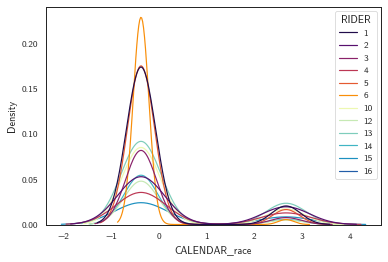

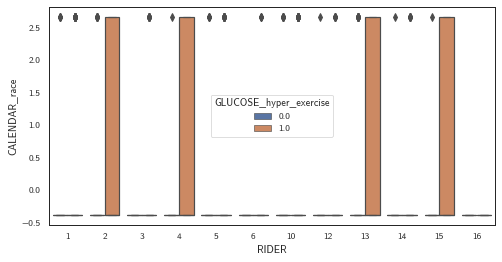

GLUCOSE_hyper_exercise~1+CALENDAR_race+(1+CALENDAR_race|RIDER)



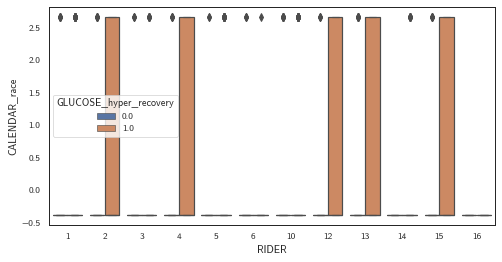

GLUCOSE_hyper_recovery~1+CALENDAR_race+(1+CALENDAR_race|RIDER)



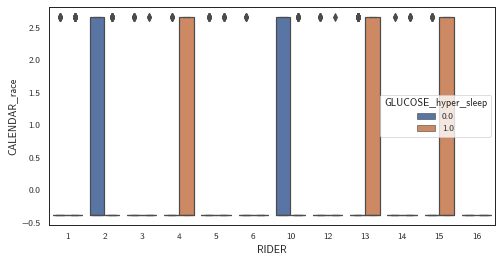

GLUCOSE_hyper_sleep~1+CALENDAR_race+(1+CALENDAR_race|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2201.0  2228.4 -1095.5   2191.0     1773   1931.0  1958.4 -960.5   1921.0   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2161.9  2189.3 -1076.0   2151.9     1753

exercise                               recovery                          \
       Min      1Q  Median     3Q    Max      Min      1Q  Median      3Q   
0  -2.9911 -0.7858  0.4422  0.734  1.678  -3.4056 -0.7486  0.4169  0.5992   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  2.2673 -1.8781 -0.8014 -0.3244  0.9614  3.0829

exercise                 recovery                   sleep  \
                    Variance Std.Dev.  Corr  Variance Std.Dev. Corr  Variance   
Groups Name                                                                     
RIDER  Intercept    0.471770   0.6869   NaN  1.134640    1.065  NaN  0.867290   
       Competition   0.01342   0.1158 -0.71   0.06349    0.252 -1.0   0.06537   

                                  
                   Std.Dev. Corr  
Groups Name                       
RIDER  Intercept     0.9313  NaN  
       Competition   0.2557 -0.4

exercise                                 recovery           \
            Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                  
Intercept       0.48     0.07     0.89     0.02    *     0.84     0.22   
Competition     0.44     0.27     0.61     0.00  ***     0.23     0.05   

                                      sleep                                  
            CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                      
Intercept       1.46     0.01   **    -0.28    -0.82     0.26     0.31       
Competition     0.41     0.01    *     0.04    -0.15     0.23     0.67

HYPER
binomial: hyper ~ TIME_duration


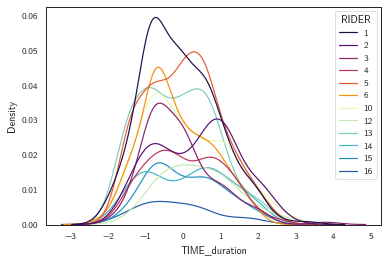

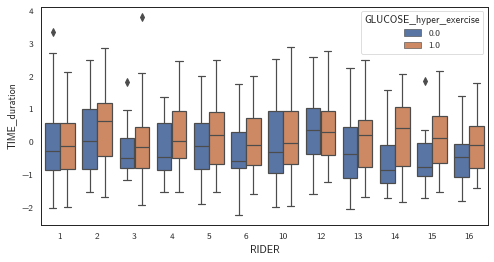

GLUCOSE_hyper_exercise~1+TIME_duration+(1+TIME_duration|RIDER)



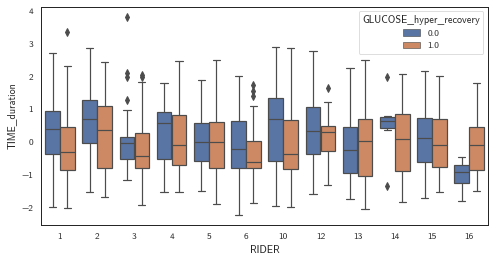

GLUCOSE_hyper_recovery~1+TIME_duration+(1+TIME_duration|RIDER)



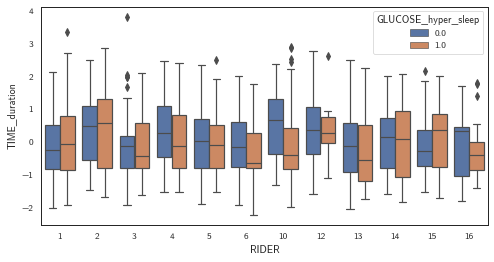

GLUCOSE_hyper_sleep~1+TIME_duration+(1+TIME_duration|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2240.6  2268.0 -1115.3   2230.6     1773   1950.0  1977.4 -970.0   1940.0   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2172.1  2199.4 -1081.0   2162.1     1753

exercise                                 recovery                         \
       Min      1Q  Median      3Q     Max      Min      1Q Median      3Q   
0  -2.8176 -0.8652  0.4896  0.7825  1.6959  -4.2107 -0.7723  0.422  0.5962   

           sleep                                 
      Max    Min      1Q Median      3Q     Max  
0  2.2749 -2.111 -0.8341  -0.38  1.0184  2.7378

exercise                 recovery                    sleep  \
                  Variance Std.Dev.  Corr  Variance Std.Dev.  Corr  Variance   
Groups Name                                                                    
RIDER  Intercept  0.491378  0.70098   NaN  1.182100   1.0872   NaN  0.833790   
       Duration   0.007961  0.08922  0.54   0.02042   0.1429 -0.09   0.03126   

                                 
                 Std.Dev.  Corr  
Groups Name                      
RIDER  Intercept   0.9131   NaN  
       Duration    0.1768 -0.54

exercise                                 recovery                    \
          Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper   
Feature                                                                         
Intercept     0.48     0.07     0.90     0.02    *     0.89     0.26     1.52   
Duration      0.32     0.19     0.46     0.00  ***    -0.22    -0.37    -0.08   

                           sleep                                  
          Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                           
Intercept     0.01   **    -0.27    -0.80     0.27     0.33       
Duration      0.00   **    -0.08    -0.23     0.07     0.30

HYPER
binomial: hyper ~ POWER_chronic_training_load


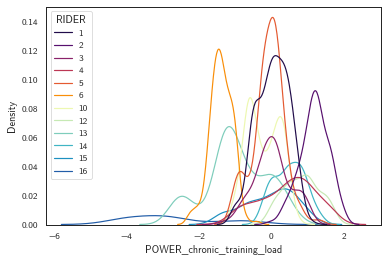

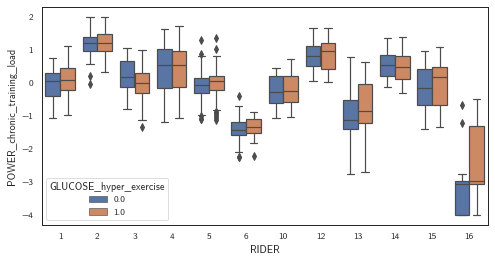

GLUCOSE_hyper_exercise~1+POWER_chronic_training_load+(1+POWER_chronic_training_load|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



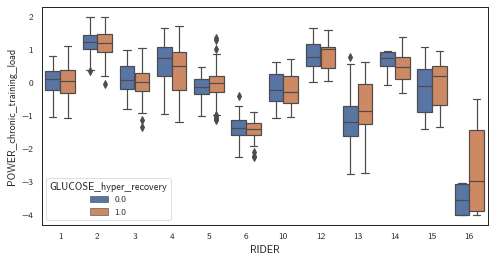

GLUCOSE_hyper_recovery~1+POWER_chronic_training_load+(1+POWER_chronic_training_load|RIDER)



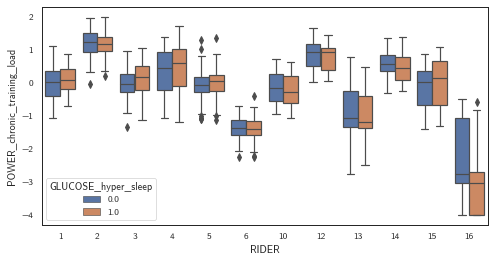

GLUCOSE_hyper_sleep~1+POWER_chronic_training_load+(1+POWER_chronic_training_load|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2257.9  2285.4 -1124.0   2247.9     1773   1961.8  1989.2 -975.9   1951.8   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2177.7  2205.1 -1083.8   2167.7     1753

exercise                               recovery                          \
       Min      1Q  Median     3Q    Max      Min      1Q  Median      3Q   
0  -1.9154 -0.8532  0.5428  0.748  2.138  -3.4949 -0.7462  0.4048  0.5699   

            sleep                                 
      Max     Min      1Q Median      3Q     Max  
0  2.0588 -1.9216 -0.8247 -0.375  0.9781  2.6751

exercise                recovery  \
                                        Variance Std.Dev. Corr  Variance   
Groups Name                                                                
RIDER  Intercept                        0.359650   0.5997  NaN  1.158730   
       Chronic training load (fitness)   0.04437   0.2106 -1.0   0.05179   

                                                          sleep                 
                                       Std.Dev.  Corr  Variance Std.Dev.  Corr  
Groups Name                                                                     
RIDER  Intercept                         1.0764   NaN  0.746570   0.8640   NaN  
       Chronic training load (fitness)   0.2276 -0.29   0.07097   0.2664  0.16

exercise                                  \
                                Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                    
Intercept                           0.54     0.18     0.90     0.00   **   
Chronic training load (fitness)     0.21    -0.01     0.43     0.07    .   

                                recovery                                  \
                                Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                    
Intercept                           0.92     0.28     1.55     0.00   **   
Chronic training load (fitness)     0.08    -0.17     0.33     0.55        

                                   sleep                                  
                                Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                   
Intercept                          -0.33    -0.85     0.19     0.22       
Chronic training load (fitness)     0.04    -0.20     0.28     0.74

HYPER
binomial: hyper ~ POWER_acute_training_load


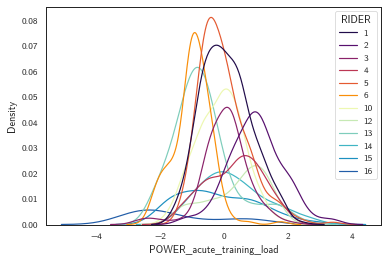

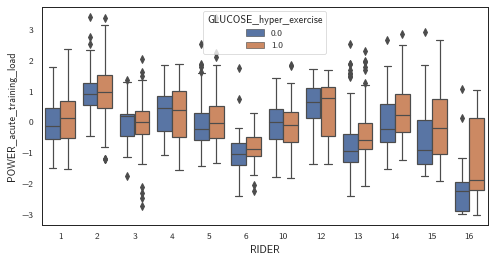

GLUCOSE_hyper_exercise~1+POWER_acute_training_load+(1+POWER_acute_training_load|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



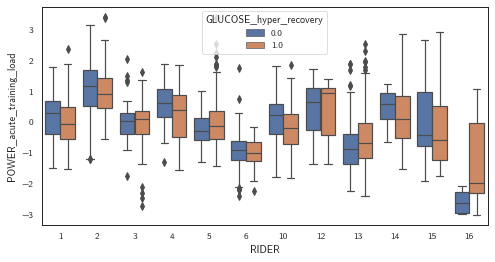

GLUCOSE_hyper_recovery~1+POWER_acute_training_load+(1+POWER_acute_training_load|RIDER)



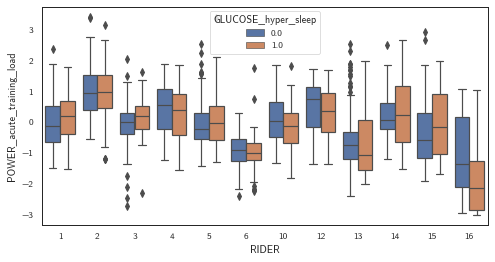

GLUCOSE_hyper_sleep~1+POWER_acute_training_load+(1+POWER_acute_training_load|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2256.2  2283.6 -1123.1   2246.2     1773   1957.9  1985.3 -973.9   1947.9   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2175.5  2202.9 -1082.8   2165.5     1753

exercise                                recovery                          \
       Min     1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0    -1.95 -0.836  0.5472  0.7315  1.8369  -3.6161 -0.7488  0.4174  0.5791   

            sleep                                 
      Max     Min      1Q Median      3Q     Max  
0  2.0596 -1.8661 -0.8252 -0.383  0.9974  3.0646

exercise                recovery  \
                                      Variance Std.Dev. Corr  Variance   
Groups Name                                                              
RIDER  Intercept                      0.386070   0.6213  NaN  1.244100   
       Acute training load (fatigue)   0.01626   0.1275 -1.0   0.08006   

                                                        sleep                
                                     Std.Dev.  Corr  Variance Std.Dev. Corr  
Groups Name                                                                  
RIDER  Intercept                        1.115   NaN  0.780560   0.8835  NaN  
       Acute training load (fatigue)    0.283  0.08   0.03534   0.1880 -0.6

exercise                                  \
                              Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                  
Intercept                         0.51     0.14     0.88     0.01   **   
Acute training load (fatigue)     0.18     0.04     0.33     0.01    *   

                              recovery                                  \
                              Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                  
Intercept                         0.91     0.26     1.56     0.01   **   
Acute training load (fatigue)    -0.10    -0.31     0.12     0.39        

                                 sleep                                  
                              Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                 
Intercept                        -0.27    -0.79     0.25     0.30       
Acute training load (fatigue)     0.03    -0.14     0.19     0.75

HYPER
binomial: hyper ~ POWER_training_stress_balance


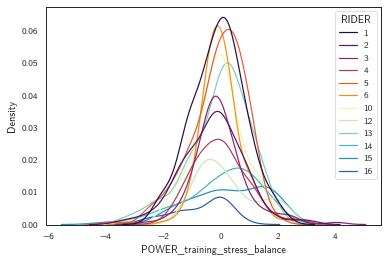

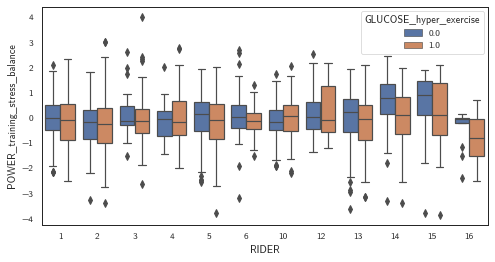

GLUCOSE_hyper_exercise~1+POWER_training_stress_balance+(1+POWER_training_stress_balance|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



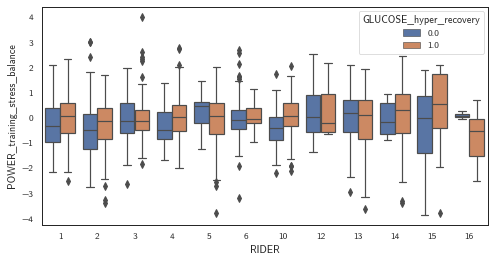

GLUCOSE_hyper_recovery~1+POWER_training_stress_balance+(1+POWER_training_stress_balance|RIDER)



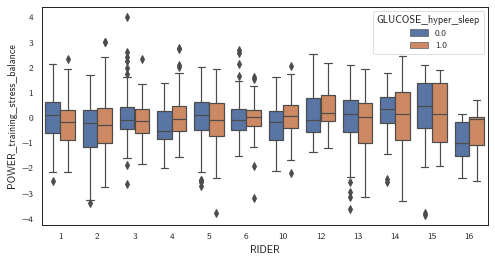

GLUCOSE_hyper_sleep~1+POWER_training_stress_balance+(1+POWER_training_stress_balance|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2265.4  2292.8 -1127.7   2255.4     1773   1955.9  1983.4 -973.0   1945.9   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2173.6  2200.9 -1081.8   2163.6     1753

exercise                                recovery                          \
       Min      1Q Median      3Q     Max      Min      1Q  Median      3Q   
0  -2.0676 -0.8372  0.545  0.7433  1.7877  -3.6195 -0.7518  0.4159  0.5776   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  2.0518 -2.0571 -0.8283 -0.3835  1.0126  3.6113

exercise                recovery  \
                                       Variance Std.Dev. Corr  Variance   
Groups Name                                                               
RIDER  Intercept                       0.486473  0.69748  NaN  1.198370   
       Training stress balance (form)  0.004833  0.06952  1.0   0.06249   

                                                         sleep                 
                                      Std.Dev.  Corr  Variance Std.Dev.  Corr  
Groups Name                                                                    
RIDER  Intercept                         1.095   NaN  0.827740   0.9098   NaN  
       Training stress balance (form)    0.250 -0.11   0.03052   0.1747  0.94

exercise                                  \
                               Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                   
Intercept                          0.46     0.05     0.88     0.03    *   
Training stress balance (form)    -0.13    -0.24    -0.02     0.03    *   

                               recovery                                  \
                               Estimate CI_lower CI_upper Pr(>|z|) Sign   
Feature                                                                   
Intercept                          0.87     0.24     1.51     0.01   **   
Training stress balance (form)     0.14    -0.05     0.33     0.16        

                                  sleep                                  
                               Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                  
Intercept                         -0.26    -0.79     0.27     0.34       
Training stress balance (form)    -0.01    -0.16     0.14     0.86

HYPER
binomial: hyper ~ TIME_day_in_season


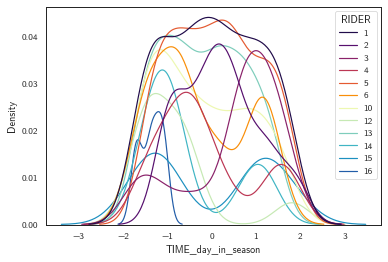

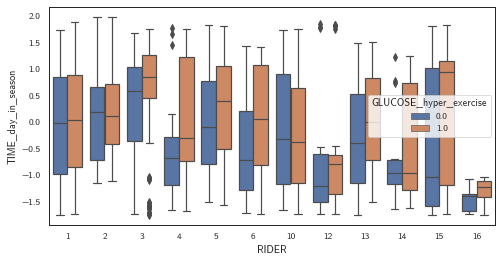

GLUCOSE_hyper_exercise~1+TIME_day_in_season+(1+TIME_day_in_season|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



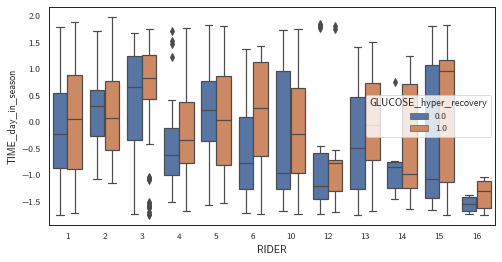

GLUCOSE_hyper_recovery~1+TIME_day_in_season+(1+TIME_day_in_season|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



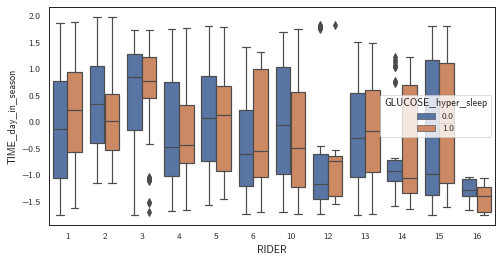

GLUCOSE_hyper_sleep~1+TIME_day_in_season+(1+TIME_day_in_season|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2255.1  2282.5 -1122.5   2245.1     1773   1941.2  1968.6 -965.6   1931.2   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2178.0  2205.4 -1084.0   2168.0     1753

exercise                                 recovery                         \
       Min      1Q  Median      3Q     Max      Min     1Q  Median      3Q   
0  -2.1475 -0.8628  0.5378  0.7435  1.6918  -3.5989 -0.672  0.4198  0.5914   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  2.5028 -1.7876 -0.8264 -0.3909  0.9992  2.9101

exercise                recovery                \
                      Variance Std.Dev. Corr  Variance Std.Dev. Corr   
Groups Name                                                            
RIDER  Intercept      0.465094  0.68198  NaN  0.926180   0.9624  NaN   
       Day in season  0.003348  0.05786 -1.0   0.04668   0.2160 -1.0   

                         sleep                 
                      Variance Std.Dev.  Corr  
Groups Name                                    
RIDER  Intercept      0.762750   0.8734   NaN  
       Day in season   0.01465   0.1210 -0.57

exercise                                 recovery           \
              Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                    
Intercept         0.52     0.11     0.92     0.01    *     0.90     0.34   
Day in season     0.20     0.09     0.31     0.00  ***     0.18     0.01   

                                        sleep                                  
              CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                        
Intercept         1.46     0.00   **    -0.27    -0.78     0.24     0.30       
Day in season     0.34     0.03    *     0.01    -0.12     0.13     0.92

HYPER
binomial: hyper ~ CALENDAR_travel_3d_any


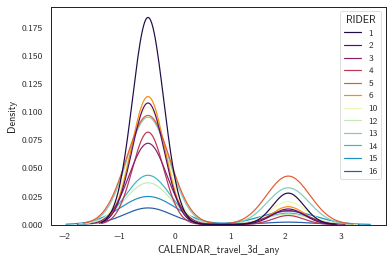

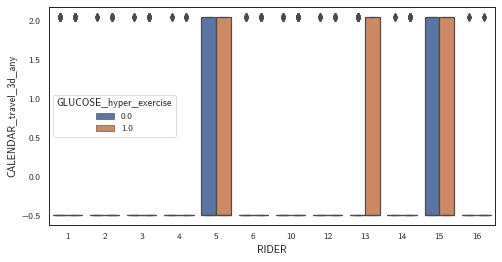

GLUCOSE_hyper_exercise~1+CALENDAR_travel_3d_any+(1+CALENDAR_travel_3d_any|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



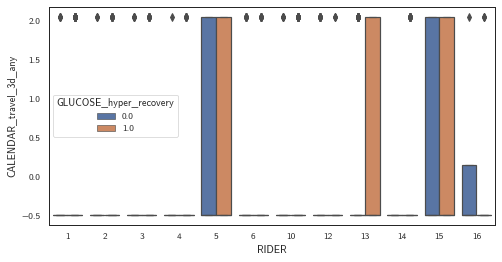

GLUCOSE_hyper_recovery~1+CALENDAR_travel_3d_any+(1+CALENDAR_travel_3d_any|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



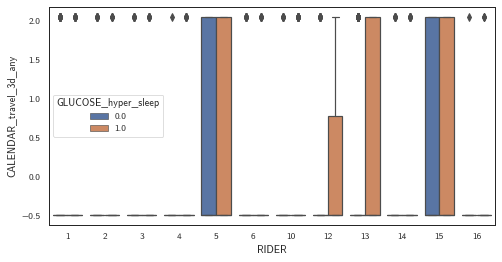

GLUCOSE_hyper_sleep~1+CALENDAR_travel_3d_any+(1+CALENDAR_travel_3d_any|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2264.7  2292.1 -1127.4   2254.7     1773   1962.4  1989.9 -976.2   1952.4   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2178.4  2205.8 -1084.2   2168.4     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -1.9396 -0.7705  0.5421  0.7517  1.5009   -3.403 -0.7281  0.4195  0.5805   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  2.0681 -1.6961 -0.8359 -0.3506  1.0072  2.8522

exercise                recovery                   sleep  \
                 Variance Std.Dev. Corr  Variance Std.Dev. Corr  Variance   
Groups Name                                                                 
RIDER  Intercept  0.50270   0.7090  NaN  1.170740  1.08201  NaN  0.822876   
       Travel       0.011   0.1049 -1.0   0.00276  0.05254 -1.0  0.003445   

                                
                 Std.Dev. Corr  
Groups Name                     
RIDER  Intercept   0.9071  NaN  
       Travel      0.0587 -1.0

exercise                                 recovery                    \
          Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper   
Feature                                                                         
Intercept     0.47     0.05     0.89     0.03    *     0.87     0.24     1.50   
Travel        0.08    -0.05     0.20     0.24          0.12    -0.00     0.25   

                           sleep                                  
          Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                           
Intercept     0.01   **    -0.28    -0.81     0.25     0.30       
Travel        0.06    .     0.04    -0.07     0.16     0.43

HYPER
binomial: hyper ~ LOC_temperature_mean


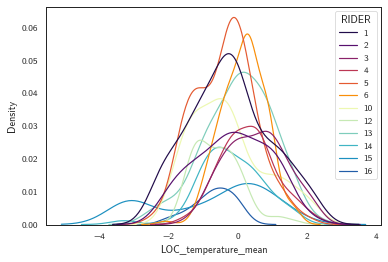

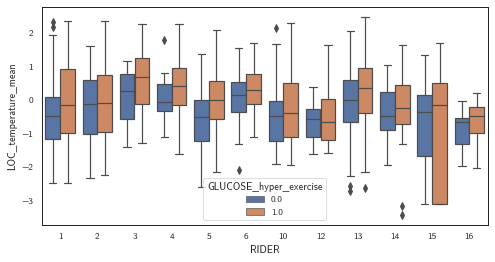

GLUCOSE_hyper_exercise~1+LOC_temperature_mean+(1+LOC_temperature_mean|RIDER)



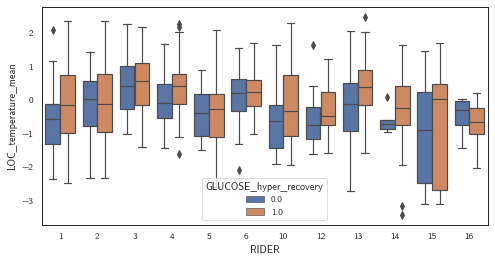

GLUCOSE_hyper_recovery~1+LOC_temperature_mean+(1+LOC_temperature_mean|RIDER)



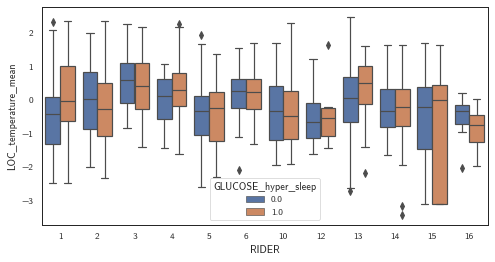

GLUCOSE_hyper_sleep~1+LOC_temperature_mean+(1+LOC_temperature_mean|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2235.1  2262.5 -1112.5   2225.1     1773   1926.4  1953.8 -958.2   1916.4   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2170.6  2198.0 -1080.3   2160.6     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -2.2184 -0.8768  0.5203  0.7454  2.5424  -3.4308 -0.6813  0.4041  0.5961   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  2.8756 -1.8185 -0.8275 -0.3924  0.9419  3.3606

exercise                 recovery                 \
                    Variance Std.Dev.  Corr  Variance Std.Dev.  Corr   
Groups Name                                                            
RIDER  Intercept    0.482190   0.6944   NaN  1.118680    1.058   NaN   
       Temperature   0.02093   0.1447 -0.77   0.04622    0.215 -0.86   

                       sleep                 
                    Variance Std.Dev.  Corr  
Groups Name                                  
RIDER  Intercept    0.788450   0.8879   NaN  
       Temperature   0.03546   0.1883 -0.17

exercise                                 recovery           \
            Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                  
Intercept       0.52     0.11     0.93     0.01    *     0.92     0.30   
Temperature     0.31     0.17     0.45     0.00  ***     0.33     0.15   

                                      sleep                                  
            CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                      
Intercept       1.54      0.0   **    -0.27    -0.79     0.25     0.31       
Temperature     0.50      0.0  ***     0.06    -0.10     0.22     0.46

HYPER
binomial: hyper ~ LOC_altitude_mean


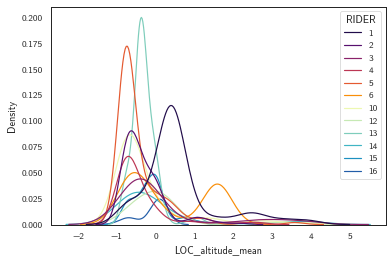

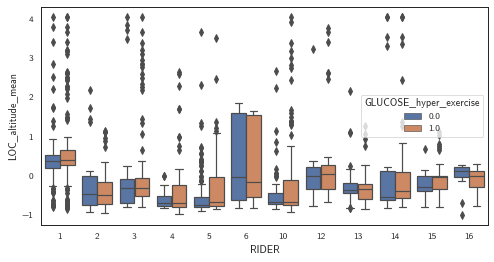

GLUCOSE_hyper_exercise~1+LOC_altitude_mean+(1+LOC_altitude_mean|RIDER)



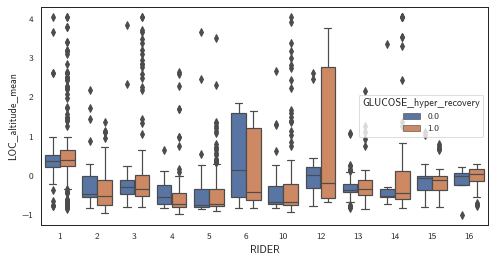

GLUCOSE_hyper_recovery~1+LOC_altitude_mean+(1+LOC_altitude_mean|RIDER)



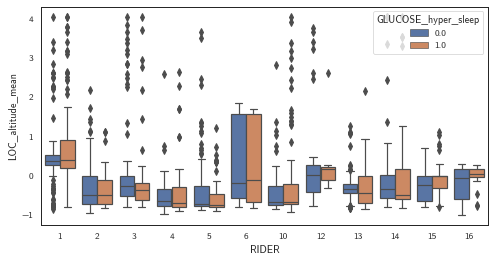

GLUCOSE_hyper_sleep~1+LOC_altitude_mean+(1+LOC_altitude_mean|RIDER)



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2268.4  2295.8 -1129.2   2258.4     1773   1962.7  1990.1 -976.3   1952.7   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2178.9  2206.2 -1084.4   2168.9     1753

exercise                               recovery                          \
       Min     1Q  Median      3Q    Max      Min      1Q  Median      3Q   
0  -1.9947 -0.819  0.5342  0.7281  1.412  -3.5384 -0.7982  0.4186  0.5852   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  2.3646 -1.7639 -0.8355 -0.3757  1.0003  2.9327

exercise                 recovery                    sleep  \
                  Variance Std.Dev.  Corr  Variance Std.Dev.  Corr  Variance   
Groups Name                                                                    
RIDER  Intercept  0.481470   0.6939   NaN  1.181910   1.0872   NaN  0.829840   
       Altitude    0.03665   0.1914 -0.07   0.06393   0.2528 -0.25   0.01715   

                                 
                 Std.Dev.  Corr  
Groups Name                      
RIDER  Intercept    0.911   NaN  
       Altitude     0.131  0.33

exercise                                 recovery                    \
          Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper   
Feature                                                                         
Intercept     0.49     0.08     0.91     0.02    *     0.86     0.22     1.49   
Altitude      0.12    -0.06     0.30     0.19          0.03    -0.18     0.24   

                           sleep                                  
          Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                           
Intercept     0.01   **    -0.28    -0.81     0.25      0.3       
Altitude      0.79         -0.01    -0.16     0.14      0.9

HYPER
binomial: hyper ~ TIME_time_start


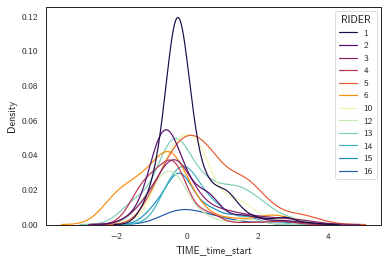

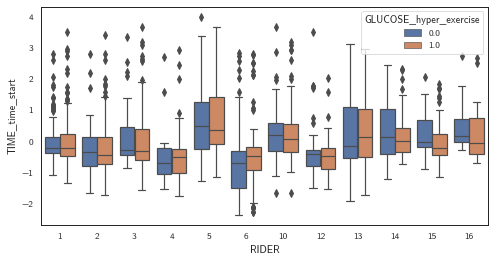

GLUCOSE_hyper_exercise~1+TIME_time_start+(1+TIME_time_start|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



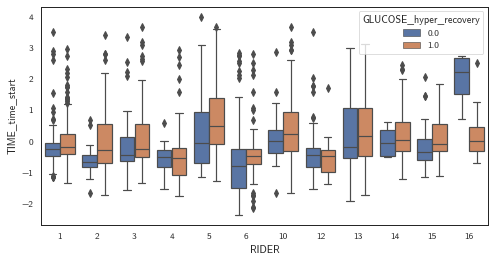

GLUCOSE_hyper_recovery~1+TIME_time_start+(1+TIME_time_start|RIDER)



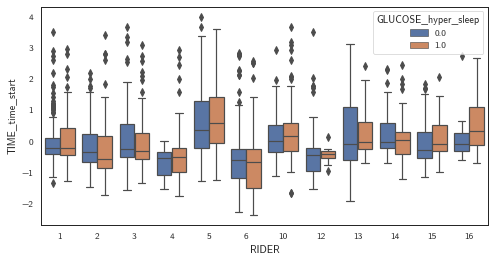

GLUCOSE_hyper_sleep~1+TIME_time_start+(1+TIME_time_start|RIDER)


R[write to console]: boundary (singular) fit: see ?isSingular



exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2272.0  2299.4 -1131.0   2262.0     1773   1951.3  1978.7 -970.7   1941.3   

             sleep                                    
  df.resid     AIC     BIC  logLik deviance df.resid  
0     1769  2178.9  2206.3 -1084.5   2168.9     1753

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -2.0525 -0.8116  0.5266  0.8042  1.5122  -4.7161 -0.7488  0.4343  0.5992   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  2.0589 -1.7888 -0.8384 -0.3845  1.0015  2.8891

exercise                recovery                 \
                      Variance Std.Dev. Corr  Variance Std.Dev.  Corr   
Groups Name                                                             
RIDER  Intercept      0.499735  0.70692  NaN  1.082060  1.04022   NaN   
       Starting time  0.007401  0.08603 -1.0   0.00973  0.09864  0.78   

                         sleep                
                      Variance Std.Dev. Corr  
Groups Name                                   
RIDER  Intercept      0.818480  0.90470  NaN  
       Starting time  0.003788  0.06155  1.0

exercise                                 recovery           \
              Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                    
Intercept         0.48     0.06     0.90     0.02    *     0.85     0.25   
Starting time    -0.04    -0.16     0.09     0.56          0.27     0.12   

                                        sleep                                  
              CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                                        
Intercept         1.46     0.01   **    -0.27    -0.79     0.26     0.32       
Starting time     0.42     0.00  ***     0.04    -0.07     0.16     0.46

In [156]:
fe, re, score, res = {}, {}, {}, {}
for col, name in cols_X.items():
    fe[name], re[name], score[name], res[name] = regress(data, x=[col], name='_'.join(col.split('_')[1:]), event='hyper', show_hist=True, show_boxplot=True, random_effects=True)

In [157]:
fe = pd.concat(fe)
fe = fe.drop(fe.loc[pd.IndexSlice[:, 'Intercept'], :].index).reset_index().set_index('Feature').drop('level_0', axis=1)
re = pd.concat(re)

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [158]:
with open(SAVE_PATH+"model_binomial_hyper_univariate.tex", 'w') as file:
	file.write(fe.to_latex(column_format='c', escape=False))
	file.write(re.to_latex(column_format='c', escape=False))

In [174]:
fe

exercise                      \
                                           Estimate  CI_lower  CI_upper   
Feature                                                                   
Normalised power                           1.768267  1.447735  2.159766   
Intensity factor                           1.682028  1.404948  2.013753   
Training stress score                      1.568312  1.363425  1.822119   
Variability index                          1.632316  1.404948  1.896481   
Efficiency factor                          1.568312  1.323130  1.858928   
Time in power zone 1 (Active Recovery)     1.271249  1.138828  1.419068   
Time in power zone 2 (Endurance)           1.094174  0.913931  1.323130   
Time in power zone 3 (Tempo)               1.447735  1.173511  1.768267   
Time in power zone 4 (Lactate Threshold)   1.491825  1.209250  1.858928   
Time in power zone 5 (VO2max)              1.665291  1.323130  2.075081   
Time in power zone 6 (Anaerobic Capacity)  1.786038  1.433329  2.247908   
Heart rate                                 1.433329  1.197217  1.698932   
Time in HR zone 1 (Active Recovery)        1.094174  0.951229  1.246077   
Time in HR zone 2 (Endurance)              1.116278  0.960789  1.309964   
Time in HR zone 3 (Tempo)                  1.336427  1.127497  1.584074   
Time in HR zone 4 (Lactate Threshold)      1.491825  1.161834  1.934792   
Time in HR zone 5 (Anaerobic Capacity)     1.209250  0.697676  2.095936   
Competition                                1.552707  1.309964  1.840431   
Duration                                   1.377128  1.209250  1.584074   
Chronic training load (fitness)            1.233678  0.990050  1.537258   
Acute training load (fatigue)              1.197217  1.040811  1.390968   
Training stress balance (form)             0.878095  0.786628  0.980199   
Day in season                              1.221403  1.094174  1.363425   
Travel                                     1.083287  0.951229  1.221403   
Temperature                                1.363425  1.185305  1.568312   
Altitude                                   1.127497  0.941765  1.349859   
Starting time                              0.960789  0.852144  1.094174   

                                                         recovery            \
                                          Pr(>|z|) Sign  Estimate  CI_lower   
Feature                                                                       
Normalised power                              0.00  ***  0.970446  0.802519   
Intensity factor                              0.00  ***  0.970446  0.826959   
Training stress score                         0.00  ***  0.835270  0.690734   
Variability index                             0.00  ***  1.197217  1.061837   
Efficiency factor                             0.00  ***  0.913931  0.697676   
Time in power zone 1 (Active Recovery)        0.00  ***  0.932394  0.810584   
Time in power zone 2 (Endurance)              0.33       0.778801  0.697676   
Time in power zone 3 (Tempo)                  0.00  ***  0.755784  0.670320   
Time in power zone 4 (Lactate Threshold)      0.00  ***  0.895834  0.740818   
Time in power zone 5 (VO2max)                 0.00  ***  1.072508  0.860708   
Time in power zone 6 (Anaerobic Capacity)     0.00  ***  1.197217  0.960789   
Heart rate                                    0.00  ***  0.886920  0.778801   
Time in HR zone 1 (Active Recovery)           0.21       0.913931  0.802519   
Time in HR zone 2 (Endurance)                 0.16       0.711770  0.625002   
Time in HR zone 3 (Tempo)                     0.00  ***  0.835270  0.726149   
Time in HR zone 4 (Lactate Threshold)         0.00   **  1.010050  0.843665   
Time in HR zone 5 (Anaerobic Capacity)        0.50       1.462285  0.970446   
Competition                                   0.00  ***  1.258600  1.051271   
Duration                                      0.00  ***  0.802519  0.690734   
Chronic training load (fitness)               0.07    

In [204]:
colors = ((np.log(fe[sec]['Estimate']) / np.log(fe[sec]['Estimate']).abs().max())+1)/2

In [214]:
fe[sec][['Estimate', 'CI_lower', 'CI_upper']].abs().max().max()

1.7332530178673953

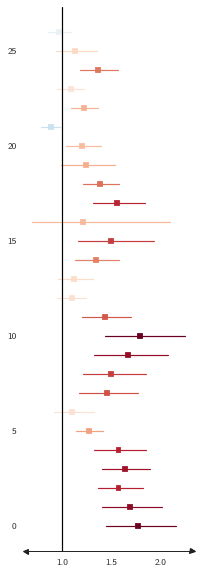

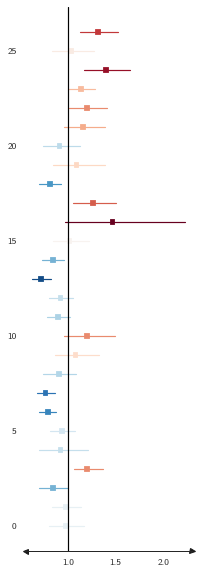

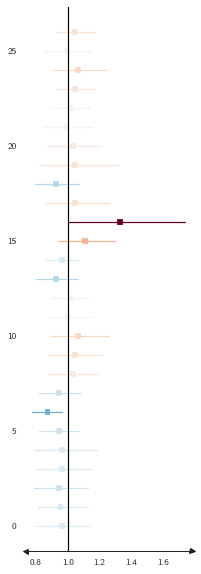

In [225]:
import matplotlib
for sec in ('exercise', 'recovery', 'sleep'):
    
    cmap = matplotlib.cm.get_cmap('RdBu_r')    
    colors = ((np.log(fe[sec]['Estimate']) / np.log(fe[sec]['Estimate']).abs().max())+1)/2
    
    fig, ax = plt.subplots(figsize=(3, 10))
    x = np.arange(fe[sec].shape[0])
    ax.scatter(fe[(sec, 'Estimate')], x, marker='s', color=cmap(colors))
    # plot CI manually
    for n in x:
        ax.plot((fe[(sec, 'CI_lower')].iloc[n], fe[(sec, 'CI_upper')].iloc[n]), (n,n), color=cmap(colors[n]))
    ax.axvline(1, color='black')
    sns.despine(left=True, right=True)
    ax.plot(1, 0, ">k", markersize=5, transform=ax.transAxes, clip_on=False)
    ax.plot(0, 0, "<k", markersize=5, transform=ax.transAxes, clip_on=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


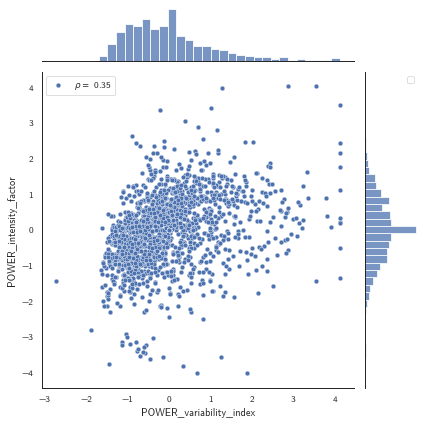

In [132]:
import scipy as sp
sns.jointplot(data=data, x='POWER_variability_index', y='POWER_intensity_factor', 
              label=r"$\rho =$ {:.2f}".format(sp.stats.pearsonr(data['POWER_variability_index'], data['POWER_intensity_factor'])[0]))
plt.legend() ; plt.show()